In [1]:
!pip install transformers
!pip install datasets


[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip


In [1]:
import torch.nn as nn
import torch
from transformers import pipeline, set_seed
from transformers import GPT2Tokenizer


class MLP(nn.Module):
    ## multi layer perceptron thats inserted into distilgpt2
    ## function is simple, its 2 linear layers that take the output of the transformer in distilgpt2 and it learns to steer the text into making better prompts
    ## however, we only want to update parameters for the 2 linear layers, not the rest, hence the requires grad being set to false
    ## output of the lm_head in this case is our Q value
    ## lm_head outputs 50k size tensors, and it's argmax is the token that it represents (aka which word to pick out of the 50k vocab size)
    ## according to the paper, this 50k size tensor also represents Q value since it decides which word to pick for our prompt
    ## our 2 linear layers get fed in states aka the previous prompts that we've generated
    ## they learn the appropriate Q value that the lm_head should output for the action of picking a word based on current reward and discounted max future reward (aka the target)
    def __init__(self):
        super().__init__()
        self.lm_pipeline = pipeline('text-generation', model='distilgpt2')
        self.policy = nn.Sequential(
            nn.Linear(768, 2048),
            nn.ReLU(),
            nn.Linear(2048, 768),
            # nn.ReLU(),
        )
        def _init_weights(m):
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight, gain=0.0001)
                m.bias.data.fill_(-0.0001)
        self.policy.apply(_init_weights)
        self.lm_pipeline.model.lm_head.requires_grad_(False)
        self.lm_pipeline.model.transformer.requires_grad_(False)
        self.lm_pipeline.model.lm_head = self.lm_pipeline.model.lm_head.to('mps')
        self.lm_pipeline.model.transformer = self.lm_pipeline.model.transformer.to('mps')
        self.tokenizer = GPT2Tokenizer.from_pretrained('distilgpt2', truncation_side = 'left')
        self.tokenizer.pad_token = self.tokenizer.eos_token
        self.lm_pipeline.model.train()
    def forward(self, x):
        # assert(x.shape[1] == 768)
        # print(x.shape)
        x = self.policy(x)
        return self.lm_pipeline.model.lm_head(x)
    def truncate(self, x):
        arr1 = []
        arr2 = []
        for i in x:
            token = self.tokenizer([i], return_tensors = 'pt')
            inp = token['input_ids'][0,-3:]
#             print(inp.shape)
            
            masks = token['attention_mask'][0,-3:]
#             print(masks.shape)
            arr1.append(inp)
            arr2.append(masks)
        return {'input_ids':torch.cat(arr1).reshape(len(x),-1), 'attention_mask': torch.cat(arr2).reshape(len(x),-1)}
            
    def get_lm_output(self, x):
        with torch.no_grad():
          input = self.truncate(x)
          for key, value in zip(input.keys(), input.values()):
            input[key] = value.to('mps')
#             print("key value", value.shape)
          return self.lm_pipeline.model.transformer(**input, use_cache=True).last_hidden_state
    def get_prompt(self, x):
        # print(x.shape)
        return  self.lm_pipeline.tokenizer.decode(x.softmax(-1).argmax(-1).reshape(1))
    def get_prompt_greedy(self, x, epsilon):
        # print(x.shape)
        if torch.rand(1) < epsilon:
            return  self.lm_pipeline.tokenizer.decode(torch.randint(0, x.shape[-1], (1,)))
        return  self.lm_pipeline.tokenizer.decode(x.softmax(-1).argmax(-1).reshape(1))
    def get_prompt_softmax_greedy(self, x):
        # print(x.shape)
        return  self.lm_pipeline.tokenizer.decode()
    

In [2]:
from transformers import pipeline

import torch


class MLM():
  ### Our masked LM model
  ### no learning involved here, just try to get the reward for having it fill it with good vs bad
  def __init__(self):
   self.unmasker = pipeline('fill-mask', model='distilroberta-base')

  def get_masked_word_class(self, input, prompt):
    return self.unmasker(f'{input} {prompt} <mask>', targets = ['good', 'bad'])




In [15]:

import torch
from tqdm import tqdm

### we have states which represents words that we feed into the distilgpt to get better words/prompts
### prompt at time t is a result of picking the action from the mlp that results in the highest reward
### can be written as argmax(reward(MLP(states)), arg = prompt)
### our loss/regression target is essentially reward+discount*max(Q(s_t+1, a'_t+1) for all a')
### this technically isn't the softqlearner, and is generally unstable and produces sparse rewards and takes an extremely long time to train
class QLearner():

    def __init__(self):
        self.mlm = MLM()
        self.mlp = MLP().to('mps')
        self.target = MLP().to('mps')
#         self.target.load_state_dict(self.mlp.state_dict())
        # torch.manual_seed(95)

        self.last_state = 'this'
        self.prompt_reward = [0]
        self.max_reward = 0
        self.optimizer = torch.optim.AdamW(self.mlp.parameters(), lr=1e-4)
        self.accuracy = []
        self.loss_ = []
    def randomize(self, Q, epsilon): 
#         print(Q.shape)
        r = torch.rand(1)
        # print(Q.argmax(-1))
        if r > epsilon:
            index = torch.randint(0, Q.shape[-1], (1,))
            m = 2*Q.max().item()
            detached = Q.detach()
            detached[:] = 0
            detached[index] = m
      # print(Q.argmax(-1))
        return Q
    # gets the actions for every state, and their Q values. actions in this case are the prompts
    def get_actions_Q (self, last_state):
        actions = []
        Q = []
        for i in range(5):
          lm_output = self.mlp.get_lm_output([last_state]).to('mps') 
          Q_ = self.mlp(lm_output)
          Q.append(Q_)
          last_state = self.mlp.get_prompt(Q_)
          actions.append(last_state)
        if type(actions) == str:
          actions = [actions]
        return actions, torch.cat(Q), last_state

    def get_actions_Q_target (self, last_state):
        actions = []
        Q = []
        for i in range(5):
          lm_output = self.target.get_lm_output([last_state]).to('mps') 
          Q_ = self.target(lm_output)
          Q.append(Q_)
          last_state = self.target.get_prompt(Q_)
          actions.append(last_state)
        if type(actions) == str:
          actions = [actions]
        return actions, torch.cat(Q), last_state


    def get_actions_Q_input_specific (self, batch_input):
        actions = []
#         print(len(batch_input))
        lm_output = self.mlp.get_lm_output(batch_input).to('mps') 
        Q_ = self.mlp(lm_output)
#         print(Q_.shape)
        Q_ = Q_[:,-1].reshape(Q_.shape[0], Q_.shape[-1]) #(16, 50k)
        for i in range(Q_.shape[0]):
          actions.append([self.mlp.get_prompt(Q_[i], .1)])
        Q = [[self.randomize(Q_[i]).reshape(1, Q_.shape[-1])] for i in range(Q_.shape[0])]



        for i in range(4):
          lm_output = self.mlp.get_lm_output([ batch_input[j]+"".join(actions[j]) for j in range(len(actions))]).to('mps') 
          Q_ = self.mlp(lm_output)
        
          Q_ = Q_[:,-1].reshape(Q_.shape[0], Q_.shape[-1])
          for j in range(Q_.shape[0]):
            Q[j].append(self.randomize(Q_[j]).reshape(1, Q_.shape[-1]))
          
          for j in range(Q_.shape[0]):
            actions[j].append(self.mlp.get_prompt(Q_[j]))
        if type(actions) == str:
          actions = [actions]
        # print(Q)
        # print(actions)
        Q = [torch.cat(Q__).reshape(1,5,-1) for Q__ in Q]
        # print(torch.cat(Q).shape)
        return actions, torch.cat(Q)

    def get_actions_Q_input_specific_target (self, batch_input):
        actions = []

        lm_output = self.target.get_lm_output(batch_input).to('mps') 
        Q_ = self.target(lm_output)
        Q_ = Q_[:,-1].reshape(Q_.shape[0], Q_.shape[-1])
        for i in range(Q_.shape[0]):
          actions.append([self.mlp.get_prompt(Q_[i])])
        Q = [[Q_[i].reshape(1, Q_.shape[-1])] for i in range(Q_.shape[0])]



        for i in range(4):
          lm_output = self.mlp.get_lm_output([batch_input[j]+"".join(actions[j]) for j in range(len(actions))]).to('mps') 
          Q_ = self.target(lm_output)
          Q_ = Q_[:,-1].reshape(Q_.shape[0], Q_.shape[-1])
          for j in range(Q_.shape[0]):
            Q[j].append(Q_[j].reshape(1, Q_.shape[-1]))
          
          for j in range(Q_.shape[0]):
            actions[j].append(self.mlp.get_prompt(Q_[j]))
        if type(actions) == str:
          actions = [actions]

        Q = [torch.cat(Q__).reshape(1,5,-1) for Q__ in Q]
        # for i in Q:
        #   for j in i:
        #     print(j.shape)
        # print(torch.cat(Q).shape)
        return actions, torch.cat(Q)

    # to be updated but currently the reward is set to how many correct classifications can this model make
    def get_reward(self, train_x, train_y, prompt):
        reward = 0
        count = 0
        
        for sentence, cls in zip(train_x, train_y):
                word_cls = self.mlm.get_masked_word_class(sentence, prompt)
#                 if (word_cls[0]['token_str'] == 'good' and cls == 1) or (word_cls[0]['token_str'] == 'bad' and cls == 0):
#                     reward = 
#                 else:
#                     incorrect +=1
                if (word_cls[0]['token_str'] == 'good' and cls == 1) or (word_cls[0]['token_str'] == 'bad' and cls == 0):
                    reward += word_cls[0]['score']- word_cls[1]['score']
                else:
                    reward += word_cls[1]['score']- word_cls[0]['score']
                count +=1
        return reward/count
    def get_accuracy(self, train_x, train_y, prompt):
        count = 0
        accurate = 0
        for sentence, cls in zip(train_x, train_y):
                word_cls = self.mlm.get_masked_word_class(sentence, prompt)
#                 if (word_cls[0]['token_str'] == 'good' and cls == 1) or (word_cls[0]['token_str'] == 'bad' and cls == 0):
#                     reward = 
#                 else:
#                     incorrect +=1
                if (word_cls[0]['token_str'] == 'good' and cls == 1) or (word_cls[0]['token_str'] == 'bad' and cls == 0):
                    reward = word_cls[0]['score']- word_cls[1]['score']
                else:
                    reward = word_cls[1]['score']- word_cls[0]['score']
                count +=1
                accurate = accurate + 1 if reward >0 else accurate
        return accurate/count
#     def get_rewards(self, train_x, train_y, prompts):
#         correct, incorrect = 0, 0
#         reward_ = dict()
#         for sentence, cls in zip(train_x, train_y):
#                 word_cls = self.mlm.get_masked_word_class(sentence, prompt)
#                 if (word_cls[0]['token_str'] == 'good' and cls == 1) or (word_cls[0]['token_str'] == 'bad' and cls == 0):
#                     correct +=1
#                 else:
#                     incorrect +=1
#         return (correct)/(correct+incorrect)
  
    def loss(self, train_x, train_y):
          # get actions and their corresponding Q values
        # actions, Q, mlp_last_state = self.get_actions_Q(self.last_state)

        actions, Q = self.get_actions_Q_input_specific(train_x)
        # print(actions)
        # print(Q.shape)
        #find which action gives the highest reward
        # high_reward =  self.get_reward(train_x, train_y, ' '.join(actions))
#         print(Q.argmax(-1))
#         print(Q.argmax(-1))
        high_reward = torch.tensor([self.get_reward(train_x, train_y, ' '.join(action)) for action in actions]).to('mps')
        accuracy = torch.tensor([self.get_accuracy(train_x, train_y, ' '.join(action)) for action in actions])
        reward = high_reward*2-1
        if reward.std() > 1e-3:
            reward = (reward-reward.mean())/reward.std()
        reward = (200**(reward>0))*(100**(reward<=0))*reward
        print([' '.join(action) for action in actions])

        # print(high_reward.shape)
        # print(Q.shape)
        # high_reward_index = high_reward.index(max(high_reward))
        # action_ = actions[high_reward_index]
        # print(f'reward: {high_reward[high_reward_index]}')

        #figure out future Q_ value with highest reward
        with torch.no_grad():
          actions_, Q_, = self.get_actions_Q_input_specific_target(train_x)
          # high_reward_ = torch.tensor(self.get_reward(train_x, train_y, x)).to('cuda')
          # high_reward_index_ = high_reward_.index(max(high_reward_))
          print([' '.join(action) for action in actions_])
        # find loss between current Q and reward+.4*Q_future_highest_reward
        # tbd make discount rate easily changeable

        # self.last_state = mlp_last_state
        return torch.nn.functional.mse_loss(\
            Q, \
            reward.reshape(-1,1,1)+\
            .2*Q_.detach()), accuracy
        

    def train(self, train_x, train_y, epochs):
        
        for i in tqdm(range(epochs)):
            self.optimizer.zero_grad()
            loss, reward = self.loss(train_x, train_y)
            loss.backward()
            self.optimizer.step()
            self.accuracy.append(reward.mean().item())
            self.loss_.append(loss.item())
            if i %10==0:
              target_weights = self.target.state_dict()
              for key in target_weights:
                target_weights[key] = self.mlp.state_dict()[key] 
              self.target.load_state_dict(target_weights)
              print(f'{loss.item()} {reward.mean()}')

In [16]:
ql = QLearner()

In [5]:
from datasets import load_dataset

dataset = load_dataset("sst2")



Found cached dataset sst2 (/Users/hariv/.cache/huggingface/datasets/sst2/default/2.0.0/9896208a8d85db057ac50c72282bcb8fe755accc671a57dd8059d4e130961ed5)


  0%|          | 0/3 [00:00<?, ?it/s]

In [6]:
train_df = dataset['train'].to_pandas()[['sentence', 'label']]
train_df_0 = train_df[train_df['label'] == 0].iloc[0:8]
train_df_1 = train_df[train_df['label'] == 1].iloc[0:8]
train_x = list(train_df_0['sentence'])+list(train_df_1['sentence'])
train_y = list(train_df_0['label'])+list(train_df_1['label'])

In [10]:
ql.train(train_x, train_y, 2999)

  0%|                                                                                                                                       | 0/2999 [00:00<?, ?it/s]

[', , , , ,', ' Ind , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ' um , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ' burner , , , ,', ', , , , ,', ', , , , ,', 'asuring , , , ,']
[', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,']


  0%|                                                                                                                            | 1/2999 [00:19<16:37:21, 19.96s/it]

125.16935729980469 0.5
[', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', 'ptions , , , ,', ', , , , ,', ' installation , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ' outlandish , , , ,']
[', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,']


  0%|                                                                                                                            | 2/2999 [00:39<16:34:42, 19.91s/it]

[', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,']
[', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,']


  0%|                                                                                                                            | 3/2999 [00:59<16:31:16, 19.85s/it]

[', , , , ,', '433 , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', 'inventoryQuantity , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,']
[', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,']


  0%|▏                                                                                                                           | 4/2999 [01:19<16:29:04, 19.81s/it]

[', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ' Libya , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,']
[', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,']


  0%|▏                                                                                                                           | 5/2999 [01:39<16:29:02, 19.82s/it]

[', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', 'asters , , , ,', 'visible , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,']
[', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,']


  0%|▏                                                                                                                           | 6/2999 [01:59<16:29:01, 19.83s/it]

[', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ' Serving , , , ,', ', , , , ,', ', , , , ,', ' Festival , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,']
[', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,']


  0%|▎                                                                                                                           | 7/2999 [02:19<16:30:57, 19.87s/it]

[', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', 'esthesia , , , ,']
[', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,']


  0%|▎                                                                                                                           | 8/2999 [02:38<16:29:17, 19.85s/it]

[', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,']
[', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,']


  0%|▎                                                                                                                           | 9/2999 [02:58<16:33:22, 19.93s/it]

[', , , , ,', ', , , , ,', ')] , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,']
[', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,']


  0%|▍                                                                                                                          | 10/2999 [03:18<16:33:56, 19.95s/it]

[', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ' attacking , , , ,', ', , , , ,', ' condo , , , ,', ', , , , ,', ', , , , ,', ' processor , , , ,']
[', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,']


  0%|▍                                                                                                                          | 11/2999 [03:38<16:33:05, 19.94s/it]

75.50801086425781 0.5
[', , , , ,', ', , , , ,', 'walk , , , ,', ' accelerating , , , ,', ', , , , ,', '583 , , , ,', ', , , , ,', ', , , , ,', ' Mother , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ' burnt , , , ,', ', , , , ,', ', , , , ,']
[', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,']


  0%|▍                                                                                                                          | 12/2999 [03:58<16:33:51, 19.96s/it]

[', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,']
[', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,']


  0%|▌                                                                                                                          | 13/2999 [04:18<16:35:34, 20.01s/it]

[', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ' counts , , , ,', ', , , , ,', ' propriet , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,']
[', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,']


  0%|▌                                                                                                                          | 14/2999 [04:38<16:33:58, 19.98s/it]

[' pecul , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ' IDF , , , ,', 'called , , , ,', ', , , , ,', ', , , , ,', ', , , , ,']
[', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,']


  1%|▌                                                                                                                          | 15/2999 [04:58<16:32:24, 19.95s/it]

[', , , , ,', ', , , , ,', ', , , , ,', ' algorithms , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,']
[', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,']


  1%|▋                                                                                                                          | 16/2999 [05:18<16:31:57, 19.95s/it]

[', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,']
[', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,']


  1%|▋                                                                                                                          | 17/2999 [05:38<16:32:39, 19.97s/it]

[', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ' Es , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,']
[', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,']


  1%|▋                                                                                                                          | 18/2999 [05:58<16:31:02, 19.95s/it]

[', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ' illustrations , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,']
[', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,']


  1%|▊                                                                                                                          | 19/2999 [06:18<16:31:07, 19.96s/it]

[', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', 'aria , , , ,', ', , , , ,', 'itches , , , ,', ', , , , ,', ', , , , ,']
[', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,']


  1%|▊                                                                                                                          | 20/2999 [06:38<16:29:45, 19.93s/it]

[', , , , ,', ', , , , ,', ', , , , ,', ' immobil , , , ,', ', , , , ,', 'Was , , , ,', 'zig , , , ,', ', , , , ,', ' scra , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,']
[', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,']


  1%|▊                                                                                                                          | 21/2999 [06:58<16:28:18, 19.91s/it]

98.50723266601562 0.515625
[' Smoking , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', '06 , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,']
[', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,']


  1%|▉                                                                                                                          | 22/2999 [07:18<16:29:13, 19.94s/it]

[', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ' Gary , , , ,', ', , , , ,', ', , , , ,', ', , , , ,']
[', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,']


  1%|▉                                                                                                                          | 23/2999 [07:38<16:31:07, 19.98s/it]

[', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', '� , , , ,', ', , , , ,', 'ohl , , , ,', ', , , , ,']
[', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,']


  1%|▉                                                                                                                          | 24/2999 [07:58<16:30:37, 19.98s/it]

[' Wicked , , , ,', ', , , , ,', ', , , , ,', ' youth , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ' spiders , , , ,', ' fly , , , ,', ', , , , ,', ' god , , , ,', ', , , , ,', ', , , , ,', ', , , , ,']
[', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,']


  1%|█                                                                                                                          | 25/2999 [08:18<16:29:45, 19.97s/it]

[', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,']
[', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,']


  1%|█                                                                                                                          | 26/2999 [08:38<16:29:31, 19.97s/it]

[', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ' rapp , , , ,', ' Bass , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,']
[', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,']


  1%|█                                                                                                                          | 27/2999 [08:58<16:28:43, 19.96s/it]

[', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,']
[', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,']


  1%|█▏                                                                                                                         | 28/2999 [09:18<16:33:17, 20.06s/it]

[', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ' jail , , , ,', ', , , , ,', ', , , , ,', ' Scala , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,']
[', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,']


  1%|█▏                                                                                                                         | 29/2999 [09:38<16:36:54, 20.14s/it]

[', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,']
[', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,']


  1%|█▏                                                                                                                         | 30/2999 [09:58<16:33:35, 20.08s/it]

[', , , , ,', ', , , , ,', ', , , , ,', ' Mickey , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', 'ruit , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,']
[', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,']


  1%|█▎                                                                                                                         | 31/2999 [10:18<16:32:56, 20.07s/it]

86.18046569824219 0.50390625
[', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,']
[', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,']


  1%|█▎                                                                                                                         | 32/2999 [10:38<16:30:57, 20.04s/it]

[', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ' kosher , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', '.), , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,']
[', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,']


  1%|█▎                                                                                                                         | 33/2999 [10:58<16:29:48, 20.02s/it]

[', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ' Rosenberg , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,']
[', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,']


  1%|█▍                                                                                                                         | 34/2999 [11:18<16:28:15, 20.00s/it]

[', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ' formatted , , , ,', ', , , , ,', 'Edge , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,']
[', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,']


  1%|█▍                                                                                                                         | 35/2999 [11:38<16:27:10, 19.98s/it]

[', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', 'ventional , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', 'ocytes , , , ,']
[', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,']


  1%|█▍                                                                                                                         | 36/2999 [11:58<16:26:44, 19.98s/it]

[', , , , ,', ', , , , ,', ' Chili , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ' wrath , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,']
[', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,']


  1%|█▌                                                                                                                         | 37/2999 [12:18<16:29:21, 20.04s/it]

[' pim , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,']
[', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,']


  1%|█▌                                                                                                                         | 38/2999 [12:38<16:27:50, 20.02s/it]

[' Bohem , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ' Marine , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,']
[', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,']


  1%|█▌                                                                                                                         | 39/2999 [12:58<16:26:30, 20.00s/it]

[', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,']
[', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,']


  1%|█▋                                                                                                                         | 40/2999 [13:18<16:28:04, 20.04s/it]

[', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,']
[', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,']


  1%|█▋                                                                                                                         | 41/2999 [13:38<16:26:55, 20.02s/it]

69.56037139892578 0.5
[', , , , ,', ', , , , ,', ', , , , ,', 'PS , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ' migraine , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ' ALEC , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,']
[', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,']


  1%|█▋                                                                                                                         | 42/2999 [13:58<16:24:39, 19.98s/it]

[', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ' restrict , , , ,', ', , , , ,', ' Graveyard , , , ,', ' Clintons , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,']
[', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,']


  1%|█▊                                                                                                                         | 43/2999 [14:18<16:25:35, 20.01s/it]

[', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,']
[', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,']


  1%|█▊                                                                                                                         | 44/2999 [14:38<16:24:05, 19.98s/it]

[', , , , ,', ', , , , ,', ', , , , ,', ' Interstate , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,']
[', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,']


  2%|█▊                                                                                                                         | 45/2999 [14:58<16:24:01, 19.99s/it]

[', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,']
[', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,']


  2%|█▉                                                                                                                         | 46/2999 [15:18<16:22:34, 19.96s/it]

[', , , , ,', 'Same , , , ,', ', , , , ,', ' yarn , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,']
[', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,']


  2%|█▉                                                                                                                         | 47/2999 [15:38<16:22:08, 19.96s/it]

[', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ' whence , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,']
[', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,']


  2%|█▉                                                                                                                         | 48/2999 [15:58<16:21:46, 19.96s/it]

[', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,']
[', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,']


  2%|██                                                                                                                         | 49/2999 [16:18<16:22:56, 19.99s/it]

[', , , , ,', ' Range , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,']
[', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,']


  2%|██                                                                                                                         | 50/2999 [16:38<16:22:29, 19.99s/it]

[', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', 'Charges , , , ,', ', , , , ,', ', , , , ,', 'tyard , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,']
[', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,']


  2%|██                                                                                                                         | 51/2999 [16:59<16:34:19, 20.24s/it]

84.03396606445312 0.51171875
[', , , , ,', ', , , , ,', ', , , , ,', ' Cohen , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', 'interrupted , , , ,', ', , , , ,', ', , , , ,']
[', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,']


  2%|██▏                                                                                                                        | 52/2999 [17:19<16:30:11, 20.16s/it]

[', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ' borne , , , ,', ', , , , ,', ', , , , ,', ', , , , ,']
[', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,']


  2%|██▏                                                                                                                        | 53/2999 [17:39<16:26:21, 20.09s/it]

[', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,']
[', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,']


  2%|██▏                                                                                                                        | 54/2999 [17:59<16:23:23, 20.04s/it]

[', , , , ,', ' goblins , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,']
[', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,']


  2%|██▎                                                                                                                        | 55/2999 [18:19<16:22:37, 20.03s/it]

[', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ' fmt , , , ,', ', , , , ,', 'Application , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,']
[', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,']


  2%|██▎                                                                                                                        | 56/2999 [18:39<16:21:24, 20.01s/it]

[', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ' Development , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ' gloom , , , ,', ', , , , ,', ', , , , ,', ', , , , ,']
[', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,']


  2%|██▎                                                                                                                        | 57/2999 [18:59<16:19:03, 19.97s/it]

[', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,']
[', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,']


  2%|██▍                                                                                                                        | 58/2999 [19:19<16:19:26, 19.98s/it]

[', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', 'stage , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', 'lesh , , , ,', ', , , , ,', ', , , , ,', ', , , , ,']
[', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,']


  2%|██▍                                                                                                                        | 59/2999 [19:39<16:18:21, 19.97s/it]

[', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,']
[', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,']


  2%|██▍                                                                                                                        | 60/2999 [19:59<16:17:48, 19.96s/it]

['bay , , , ,', ', , , , ,', ' Taylor , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ' seam , , , ,', ', , , , ,', ' contamin , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,']
[', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,']


  2%|██▌                                                                                                                        | 61/2999 [20:19<16:19:19, 20.00s/it]

83.1135482788086 0.5078125
[', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,']
[', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,']


  2%|██▌                                                                                                                        | 62/2999 [20:39<16:17:55, 19.98s/it]

[', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,']
[', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,']


  2%|██▌                                                                                                                        | 63/2999 [20:58<16:16:42, 19.96s/it]

[', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ' FPS , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,']
[', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,']


  2%|██▌                                                                                                                        | 64/2999 [21:18<16:16:26, 19.96s/it]

[', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,']
[', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,']


  2%|██▋                                                                                                                        | 65/2999 [21:38<16:16:43, 19.97s/it]

[', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', 'hler , , , ,', ', , , , ,', ' Input , , , ,', 'Pages , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,']
[', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,']


  2%|██▋                                                                                                                        | 66/2999 [21:58<16:17:13, 19.99s/it]

[', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ' livest , , , ,', ', , , , ,', ', , , , ,', ', , , , ,']
[', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,']


  2%|██▋                                                                                                                        | 67/2999 [22:18<16:16:42, 19.99s/it]

[', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,']
[', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,']


  2%|██▊                                                                                                                        | 68/2999 [22:38<16:15:54, 19.98s/it]

[', , , , ,', ', , , , ,', ', , , , ,', ' Sample , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ' Brazil , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,']
[', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,']


  2%|██▊                                                                                                                        | 69/2999 [22:58<16:15:50, 19.98s/it]

[' foot , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', '461 , , , ,', ', , , , ,', ', , , , ,', ' salty , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,']
[', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,']


  2%|██▊                                                                                                                        | 70/2999 [23:18<16:14:08, 19.96s/it]

[', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,']
[', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,']


  2%|██▉                                                                                                                        | 71/2999 [23:38<16:12:25, 19.93s/it]

43.85758590698242 0.5
[', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,']
[', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,']


  2%|██▉                                                                                                                        | 72/2999 [23:58<16:12:39, 19.94s/it]

[', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ' tabletop , , , ,', ', , , , ,']
[', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,']


  2%|██▉                                                                                                                        | 73/2999 [24:18<16:13:14, 19.96s/it]

[' fian , , , ,', ', , , , ,', ' feelings , , , ,', 'player , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ' sle , , , ,']
[', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,']


  2%|███                                                                                                                        | 74/2999 [24:38<16:12:53, 19.96s/it]

[', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ' Manitoba , , , ,', ', , , , ,', ' demonstr , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,']
[', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,']


  3%|███                                                                                                                        | 75/2999 [24:58<16:11:51, 19.94s/it]

[', , , , ,', ' delighted , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', '80 , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,']
[', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,']


  3%|███                                                                                                                        | 76/2999 [25:18<16:11:24, 19.94s/it]

['OY , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ' prost , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ' random , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,']
[', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,']


  3%|███▏                                                                                                                       | 77/2999 [25:38<16:11:38, 19.95s/it]

[', , , , ,', ' CONTROL , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ' 1925 , , , ,', ', , , , ,', ', , , , ,', ' individuals , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,']
[', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,']


  3%|███▏                                                                                                                       | 78/2999 [25:58<16:11:05, 19.95s/it]

[' Immigration , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ' injury , , , ,', ', , , , ,', ', , , , ,', ' dop , , , ,']
[', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,']


  3%|███▏                                                                                                                       | 79/2999 [26:18<16:11:53, 19.97s/it]

[', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ' Present , , , ,', 'ilage , , , ,', ', , , , ,']
[', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,']


  3%|███▎                                                                                                                       | 80/2999 [26:38<16:11:52, 19.98s/it]

['lav , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,']
[', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,']


  3%|███▎                                                                                                                       | 81/2999 [26:58<16:10:30, 19.96s/it]

63.103240966796875 0.5078125
[', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ' >> , , , ,', ', , , , ,', ', , , , ,', ' $$ , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,']
[', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,']


  3%|███▎                                                                                                                       | 82/2999 [27:18<16:09:08, 19.93s/it]

[', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', 'ICT , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', '�醒 , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,']
[', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,']


  3%|███▍                                                                                                                       | 83/2999 [27:38<16:08:43, 19.93s/it]

[', , , , ,', ', , , , ,', ' rack , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ' varying , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ' Kut , , , ,', ' chemist , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,']
[', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,']


  3%|███▍                                                                                                                       | 84/2999 [27:57<16:08:20, 19.93s/it]

[', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,']
[', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,']


  3%|███▍                                                                                                                       | 85/2999 [28:18<16:10:39, 19.99s/it]

[', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ' settlements , , , ,', ', , , , ,']
[', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,']


  3%|███▌                                                                                                                       | 86/2999 [28:38<16:10:38, 19.99s/it]

[', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ' judged , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,']
[', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,']


  3%|███▌                                                                                                                       | 87/2999 [28:58<16:11:13, 20.01s/it]

[', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ' turnout , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ' Bernie , , , ,']
[', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,']


  3%|███▌                                                                                                                       | 88/2999 [29:18<16:12:15, 20.04s/it]

[', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', 'amac , , , ,', ' Highlights , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,']
[', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,']


  3%|███▋                                                                                                                       | 89/2999 [29:38<16:09:35, 19.99s/it]

[', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', 'Bon , , , ,', ', , , , ,', ', , , , ,', ', , , , ,']
[', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,']


  3%|███▋                                                                                                                       | 90/2999 [29:57<16:07:20, 19.95s/it]

[', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ' Sons , , , ,', ', , , , ,']
[', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,']


  3%|███▋                                                                                                                       | 91/2999 [30:18<16:08:05, 19.97s/it]

63.76906204223633 0.50390625
[', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ' annihil , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,']
[', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,']


  3%|███▊                                                                                                                       | 92/2999 [30:37<16:07:18, 19.97s/it]

[' establishes , , , ,', ' microbiome , , , ,', ' standard , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,']
[', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,']


  3%|███▊                                                                                                                       | 93/2999 [30:57<16:06:02, 19.95s/it]

[', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', '044 , , , ,', ', , , , ,', ' gull , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', '  , , , ,', ', , , , ,', ', , , , ,']
[', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,']


  3%|███▊                                                                                                                       | 94/2999 [31:17<16:05:30, 19.94s/it]

[', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ' lame , , , ,', ', , , , ,', ', , , , ,']
[', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,']


  3%|███▉                                                                                                                       | 95/2999 [31:37<16:04:49, 19.93s/it]

[', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', 'leneck , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ' Spir , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,']
[', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,']


  3%|███▉                                                                                                                       | 96/2999 [31:57<16:05:01, 19.95s/it]

[', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', 'imei , , , ,', ', , , , ,', ', , , , ,']
[', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,']


  3%|███▉                                                                                                                       | 97/2999 [32:17<16:04:48, 19.95s/it]

[', , , , ,', ', , , , ,', ', , , , ,', ' buckets , , , ,', ', , , , ,', ', , , , ,', ' Mats , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ' costly , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,']
[', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,']


  3%|████                                                                                                                       | 98/2999 [32:37<16:03:28, 19.93s/it]

[', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ' Aviation , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,']
[', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,']


  3%|████                                                                                                                       | 99/2999 [32:57<16:04:34, 19.96s/it]

[', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', 'Favorite , , , ,', ', , , , ,', ', , , , ,', ' Killed , , , ,', ', , , , ,', ', , , , ,']
[', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,']


  3%|████                                                                                                                      | 100/2999 [33:17<16:04:29, 19.96s/it]

[', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', 'ulation , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,']
[', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,']


  3%|████                                                                                                                      | 101/2999 [33:37<16:03:46, 19.95s/it]

40.216495513916016 0.5
[', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ' goodies , , , ,', ' ac , , , ,', ', , , , ,', ' turnaround , , , ,', ', , , , ,']
[', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,']


  3%|████▏                                                                                                                     | 102/2999 [33:57<16:03:50, 19.96s/it]

[' Intelligence , , , ,', ', , , , ,', 'Corp , , , ,', ', , , , ,', ', , , , ,', 'wl , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,']
[', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,']


  3%|████▏                                                                                                                     | 103/2999 [34:17<16:02:54, 19.95s/it]

[', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', 'teenth , , , ,', ', , , , ,', ', , , , ,']
[', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,']


  3%|████▏                                                                                                                     | 104/2999 [34:37<16:02:03, 19.94s/it]

[', , , , ,', ', , , , ,', ' points , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,']
[', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,']


  4%|████▎                                                                                                                     | 105/2999 [34:57<16:00:50, 19.92s/it]

[', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,']
[', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,']


  4%|████▎                                                                                                                     | 106/2999 [35:16<15:59:25, 19.90s/it]

[', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,']
[', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,']


  4%|████▎                                                                                                                     | 107/2999 [35:36<15:58:39, 19.89s/it]

[', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,']
[', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,']


  4%|████▍                                                                                                                     | 108/2999 [35:56<15:58:01, 19.88s/it]

[', , , , ,', ', , , , ,', ', , , , ,', ' Malt , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ' reasoning , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,']
[', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,']


  4%|████▍                                                                                                                     | 109/2999 [36:16<15:58:53, 19.91s/it]

[', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,']
[', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,']


  4%|████▍                                                                                                                     | 110/2999 [36:36<15:58:58, 19.92s/it]

[', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,']
[', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,']


  4%|████▌                                                                                                                     | 111/2999 [36:56<15:58:29, 19.91s/it]

40.72829055786133 0.5
[', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ' cable , , , ,', ' Trend , , , ,', ', , , , ,', ' Ruk , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,']
[', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,']


  4%|████▌                                                                                                                     | 112/2999 [37:16<15:58:16, 19.92s/it]

[', , , , ,', ', , , , ,', ' diets , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ' harvesting , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,']
[', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,']


  4%|████▌                                                                                                                     | 113/2999 [37:36<15:57:36, 19.91s/it]

[', , , , ,', ', , , , ,', ' Shooter , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ' assorted , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,']
[', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,']


  4%|████▋                                                                                                                     | 114/2999 [37:56<15:57:37, 19.92s/it]

[', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,']
[', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,']


  4%|████▋                                                                                                                     | 115/2999 [38:16<15:58:58, 19.95s/it]

[' Flynn , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', '_____ , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,']
[', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,']


  4%|████▋                                                                                                                     | 116/2999 [38:36<15:58:26, 19.95s/it]

[', , , , ,', 'pure , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', 'herry , , , ,', ', , , , ,', ' label , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,']
[', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,']


  4%|████▊                                                                                                                     | 117/2999 [38:56<15:56:52, 19.92s/it]

[', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,']
[', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,']


  4%|████▊                                                                                                                     | 118/2999 [39:16<15:56:40, 19.92s/it]

[', , , , ,', ', , , , ,', ' 343 , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,']
[', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,']


  4%|████▊                                                                                                                     | 119/2999 [39:35<15:56:40, 19.93s/it]

[', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', 'Introdu , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,']
[', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,']


  4%|████▉                                                                                                                     | 120/2999 [39:55<15:56:21, 19.93s/it]

[', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ' Jiang , , , ,', ', , , , ,', ' mundane , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,']
[', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,']


  4%|████▉                                                                                                                     | 121/2999 [40:15<15:55:12, 19.91s/it]

51.723873138427734 0.5078125
[', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ' honor , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,']
[', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,']


  4%|████▉                                                                                                                     | 122/2999 [40:35<15:54:15, 19.90s/it]

[', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ' decision , , , ,']
[', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,']


  4%|█████                                                                                                                     | 123/2999 [40:55<15:52:27, 19.87s/it]

[', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ' answering , , , ,', ', , , , ,', ' compressor , , , ,', ' allowable , , , ,', ' containers , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,']
[', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,']


  4%|█████                                                                                                                     | 124/2999 [41:15<15:51:45, 19.86s/it]

[', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,']
[', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,']


  4%|█████                                                                                                                     | 125/2999 [41:35<15:51:30, 19.86s/it]

[', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', 'Ah , , , ,', ', , , , ,', ', , , , ,']
[', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,']


  4%|█████▏                                                                                                                    | 126/2999 [41:55<15:51:36, 19.87s/it]

[', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ' slic , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ' theory , , , ,']
[', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,']


  4%|█████▏                                                                                                                    | 127/2999 [42:15<15:52:28, 19.90s/it]

[', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ' favourite , , , ,', ' fried , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', 'uber , , , ,', ', , , , ,']
[', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,']


  4%|█████▏                                                                                                                    | 128/2999 [42:34<15:51:43, 19.89s/it]

[', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', '� , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', 'erion , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,']
[', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,']


  4%|█████▏                                                                                                                    | 129/2999 [42:54<15:50:36, 19.87s/it]

[', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,']
[', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,']


  4%|█████▎                                                                                                                    | 130/2999 [43:14<15:51:17, 19.89s/it]

[', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ' Antiqu , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', 'Jer , , , ,', ', , , , ,']
[', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,']


  4%|█████▎                                                                                                                    | 131/2999 [43:34<15:50:59, 19.90s/it]

57.90370559692383 0.515625
[', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,']
[', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,']


  4%|█████▎                                                                                                                    | 132/2999 [43:54<15:51:44, 19.92s/it]

[', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ' pedigree , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ' barbaric , , , ,', ', , , , ,', ' Penguins , , , ,', ', , , , ,', ', , , , ,', ', , , , ,']
[', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,']


  4%|█████▍                                                                                                                    | 133/2999 [44:14<15:51:53, 19.93s/it]

[', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', 'pret , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ' ;; , , , ,']
[', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,']


  4%|█████▍                                                                                                                    | 134/2999 [44:34<15:51:48, 19.93s/it]

[' SW , , , ,', ', , , , ,', ' Ake , , , ,', ', , , , ,', '\n , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,']
[', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,']


  5%|█████▍                                                                                                                    | 135/2999 [44:54<15:51:09, 19.93s/it]

[' strengths , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,']
[', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,']


  5%|█████▌                                                                                                                    | 136/2999 [45:14<15:50:05, 19.91s/it]

[', , , , ,', '� , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ' Norwegian , , , ,', ', , , , ,', ', , , , ,', ' respond , , , ,', ', , , , ,', ', , , , ,']
[', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,']


  5%|█████▌                                                                                                                    | 137/2999 [45:34<15:47:53, 19.87s/it]

[', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,']
[', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,']


  5%|█████▌                                                                                                                    | 138/2999 [45:53<15:47:52, 19.88s/it]

[', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , \n ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,']
[', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', \n , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,']


  5%|█████▋                                                                                                                    | 139/2999 [46:13<15:49:04, 19.91s/it]

[', , , , ,', ', , , , ,', ', , , , ,', '\n , , , ,', ', \n , , ,', ' behaving , , , ,', '289 , , , ,', ', , , , ,', '\n , , , ,', ', \n , , ,', ', , \n , ,', 'igraph , , , ,', ', , , , ,', ', , , , ,', 'Florida , , , ,', ', , , , ,']
[', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,']


  5%|█████▋                                                                                                                    | 140/2999 [46:33<15:47:17, 19.88s/it]

[' Cases , , , ,', ', , , , ,', '\n , \n \n \n', ', , \n , \n', '\n , , \n ,', ', , , \n ,', ', , \n , \n', ', \n , \n \n', '\n , , , ,', ', \n , \n ,', ', , \n , ,', ', , \n , ,', '\n , , , ,', '\n , , , ,', 'melon , , , \n', '\n , , , ,']
[', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,']


  5%|█████▋                                                                                                                    | 141/2999 [46:53<15:44:56, 19.84s/it]

334.6172790527344 0.5
['\n \n \n \n \n', '\n , \n \n \n', '\n , , \n \n', '\n , \n \n \n', '\n , \n \n \n', '\n \n \n \n \n', '\n , \n \n \n', ', \n , , \n', '\n , \n , \n', '\n \n , \n ,', ', \n \n \n \n', '\n \n \n , \n', 'leanor , , \n ,', '\n \n , \n \n', '\n , \n \n \n', ' lifes , , , \n']
['\n , \n \n \n', ', \n , \n \n', '\n \n \n , \n', '\n \n \n \n \n', ', \n , \n \n', '\n \n \n , \n', '\n , \n \n \n', ', \n \n \n ,', '\n \n \n \n \n', ', \n , , \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n , \n \n \n', '\n \n \n , \n', '\n \n , \n \n']


  5%|█████▊                                                                                                                    | 142/2999 [47:13<15:43:09, 19.81s/it]

['\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', ' lod , , \n \n', '\n \n \n \n \n', '\n \n GoldMagikarp , ,', 'erved \n \n \n \n', '\n \n \n \n \n', '\n \n \n GoldMagikarp ,', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', ' guaranteed , , \n \n']
['\n , \n \n \n', '\n , \n \n \n', '\n , \n , \n', '\n \n , \n \n', '\n , , \n \n', '\n , \n \n \n', '\n \n , \n \n', '\n , \n \n \n', '\n \n \n , \n', '\n \n \n , \n', '\n \n \n \n \n', '\n , \n \n ,', ', , \n , \n', '\n \n \n \n ,', '\n \n \n \n ,', '\n \n , \n \n']


  5%|█████▊                                                                                                                    | 143/2999 [47:33<15:43:46, 19.83s/it]

['\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n GoldMagikarp , \n \n', '\n \n \n \n \n', '\n \n GoldMagikarp , ,', '\n \n \n GoldMagikarp ,', ' citrus , , \n \n', '\n \n \n \n \n', '\n \n GoldMagikarp , \n', ', \n \n GoldMagikarp ,', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n']
['\n \n \n , \n', '\n , \n \n \n', '\n \n \n \n ,', ', \n , \n \n', '\n , \n \n ,', '\n \n , \n ,', '\n , \n \n \n', '\n \n \n \n \n', '\n , \n , \n', '\n , \n \n ,', '\n \n \n , \n', ', , \n , \n', '\n \n \n \n ,', ', , \n , \n', '\n \n , \n \n', ', \n , \n \n']


  5%|█████▊                                                                                                                    | 144/2999 [47:52<15:43:36, 19.83s/it]

[', \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', ', \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', ', \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n']
['\n , \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n , \n \n \n', '\n , \n \n \n', '\n \n \n , \n', '\n , \n , \n', '\n \n , \n \n', '\n \n \n \n ,', ', \n , \n \n', ', , \n , ,', ', , \n , \n', '\n \n \n \n ,', ', , \n , \n', ', \n , \n \n', '\n \n , \n \n']


  5%|█████▉                                                                                                                    | 145/2999 [48:12<15:44:24, 19.85s/it]

[', \n \n \n \n', ', \n \n \n \n', '\n \n \n \n \n', ' delightful , , , \n', ', \n \n \n \n', ', \n \n \n \n', '\n \n \n \n \n', ', \n \n \n \n', ', \n \n \n \n', ', \n \n \n \n', ', , \n \n \n', '\n \n \n \n \n', ', , \n \n \n', 'gu , , \n \n', ', \n \n \n \n', ', \n \n \n \n']
['\n \n \n \n ,', '\n \n , \n \n', '\n , \n \n \n', ', \n \n \n ,', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n ,', '\n \n \n , \n', '\n \n \n , \n', ', , \n , \n', ', \n \n , ,', '\n , \n \n \n', '\n , \n \n \n', '\n \n , \n \n', ', \n , \n \n', '\n \n \n \n ,']


  5%|█████▉                                                                                                                    | 146/2999 [48:32<15:41:40, 19.80s/it]

[', \n \n \n \n', ', \n \n \n \n', '\n \n \n \n \n', ', \n \n \n \n', ', \n GoldMagikarp , ,', '\n \n \n \n \n', '\n \n \n \n \n', ', \n \n \n \n', ', \n \n \n \n', ', \n \n \n \n', '\n \n \n \n \n', ', , \n \n GoldMagikarp', ', , \n \n \n', ', \n \n \n \n', ', \n \n \n \n', ', \n \n GoldMagikarp ,']
[', \n , \n \n', ', \n \n \n ,', '\n \n , \n \n', ', \n , \n \n', '\n , \n \n \n', '\n \n \n \n \n', '\n , \n \n \n', '\n \n \n , \n', '\n \n , \n ,', ', \n , \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n ,', '\n \n , \n \n', '\n \n \n , \n', '\n , \n \n \n']


  5%|█████▉                                                                                                                    | 147/2999 [48:52<15:41:56, 19.82s/it]

[', \n GoldMagikarp , \n', ' ► , \n \n GoldMagikarp', '\n GoldMagikarp , \n GoldMagikarp', '\n \n \n \n GoldMagikarp', '\n GoldMagikarp , \n GoldMagikarp', '\n \n \n \n \n', '\n GoldMagikarp , \n GoldMagikarp', ', \n GoldMagikarp , \n', ' Prague , \n GoldMagikarp ,', '\n GoldMagikarp , , \n', ', \n GoldMagikarp , \n', ', , \n GoldMagikarp ,', '\n \n \n \n \n', ', \n GoldMagikarp , \n', ', \n GoldMagikarp \n \n', '\n \n \n \n \n']
['\n \n \n \n \n', '\n , \n \n ,', '\n , \n , \n', '\n \n \n , \n', '\n , \n \n \n', '\n \n \n \n \n', '\n , \n , ,', '\n \n \n , \n', '\n , \n \n \n', ', \n \n , \n', '\n \n \n \n \n', '\n \n \n , \n', '\n , \n \n \n', '\n , \n \n \n', ', \n , \n \n', '\n \n , \n \n']


  5%|██████                                                                                                                    | 148/2999 [49:12<15:43:43, 19.86s/it]

['\n GoldMagikarp , \n GoldMagikarp', '\n \n \n \n GoldMagikarp', '\n \n \n \n \n', '\n \n GoldMagikarp , \n', '\n \n \n GoldMagikarp ,', ', \n GoldMagikarp \n \n', '\n GoldMagikarp , , \n', ', \n GoldMagikarp , ,', ', \n GoldMagikarp , ,', ', \n GoldMagikarp , \n', '\n GoldMagikarp , \n GoldMagikarp', ', \n GoldMagikarp , \n', '\n \n \n GoldMagikarp ,', '\n \n \n \n GoldMagikarp', ' insensitive \n GoldMagikarp , \n', ', \n GoldMagikarp , ,']
['\n \n \n , \n', '\n , \n \n ,', '\n \n , \n \n', '\n \n , \n \n', '\n , \n , \n', '\n \n \n , \n', '\n \n \n \n \n', ', \n \n , \n', ', \n , \n \n', '\n , \n \n \n', '\n , \n , ,', '\n \n \n \n ,', '\n \n \n \n \n', ', , \n , \n', '\n , \n \n ,', '\n , \n \n \n']


  5%|██████                                                                                                                    | 149/2999 [49:31<15:40:48, 19.81s/it]

[', \n GoldMagikarp , ,', '\n GoldMagikarp , , \n', '\n \n \n \n \n', ', \n GoldMagikarp , ,', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', ', \n GoldMagikarp , ,', '\n \n \n \n \n', ', \n GoldMagikarp , ,', ' Lifetime , , \n GoldMagikarp', ', \n GoldMagikarp , \n', ' unfinished , , \n \n', ', \n GoldMagikarp , ,', ', \n GoldMagikarp , ,', '\n \n \n \n \n']
['\n , \n \n \n', '\n , \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n , \n , \n', '\n \n \n \n ,', '\n , \n \n \n', ', \n \n , \n', '\n , \n \n \n', ', \n \n , \n', '\n \n , \n \n', '\n \n \n , \n', '\n , \n \n \n', '\n \n \n , \n', '\n \n , \n \n', '\n , \n , ,']


  5%|██████                                                                                                                    | 150/2999 [49:51<15:38:44, 19.77s/it]

[', \n GoldMagikarp , ,', '\n \n \n \n \n', ', \n \n \n \n', ', \n \n \n \n', '\n \n \n \n \n', ', , , , ,', '\n \n \n \n \n', ' Brotherhood , , , ,', ', \n \n \n \n', ', , , , ,', 'too , , , ,', '\n \n \n \n \n', ', , \n \n \n', ', , , \n GoldMagikarp', ', , , \n \n', ', \n \n GoldMagikarp ,']
[', \n , \n \n', '\n \n , \n ,', '\n , \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n ,', '\n , \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n , \n \n \n', '\n \n \n \n ,', '\n \n , \n \n', '\n , \n \n \n', ', \n , , \n', '\n , \n \n \n']


  5%|██████▏                                                                                                                   | 151/2999 [50:11<15:40:36, 19.82s/it]

137.29273986816406 0.5234375
[', , \n \n \n', ', , \n \n \n', ', , , , ,', ', \n \n \n \n', '\n \n \n \n \n', ', , \n \n GoldMagikarp', ', , , \n \n', ', , , , ,', ', \n \n \n \n', ', \n \n GoldMagikarp ,', ', , \n \n GoldMagikarp', ', , , , ,', '\n \n \n \n \n', ', , \n \n \n', ', \n GoldMagikarp , ,', '\n \n \n \n \n']
[', , \n \n \n', ', , , \n \n', ', \n \n \n \n', '\n \n \n \n \n', ', \n \n \n \n', ', , , \n \n', '\n \n , , ,', ', , \n \n \n', ', \n \n \n \n', ', \n \n \n \n', ', , \n \n \n', '\n \n \n \n ,', ', , , , ,', ', , , \n \n', ', \n \n \n \n', ', , \n GoldMagikarp ,']


  5%|██████▏                                                                                                                   | 152/2999 [50:31<15:39:08, 19.79s/it]

['\n \n \n \n \n', ', \n GoldMagikarp , ,', '\n \n \n \n \n', '\n \n \n \n \n', ' Kau , , , ,', ', \n \n \n \n', '\n \n , \n \n', ', \n \n \n \n', '\n \n \n \n \n', ', \n GoldMagikarp , ,', ', \n GoldMagikarp , ,', ', , , , \n', '\n \n \n \n \n', '\n \n \n \n \n', ', , , \n GoldMagikarp', ', \n \n \n \n']
[', , \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', ', \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', ', \n GoldMagikarp , ,', ', \n \n \n \n', ', \n \n \n \n', ', \n \n \n \n', ', , , , ,', ', , , , ,', '\n \n \n \n \n', ', , \n GoldMagikarp ,', ', , \n \n \n', ', \n \n GoldMagikarp ,']


  5%|██████▏                                                                                                                   | 153/2999 [50:51<15:38:55, 19.79s/it]

['\n \n \n \n \n', '\n GoldMagikarp , , ,', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', 'ency , , , \n', ', \n GoldMagikarp , ,', ', \n GoldMagikarp , ,', '\n GoldMagikarp , , ,', ', , \n GoldMagikarp ,', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', ', , , \n \n', '\n \n \n \n \n']
['\n \n \n \n \n', ', , \n \n \n', ', \n \n \n \n', ', \n \n , ,', ', \n GoldMagikarp , ,', ', , , , ,', '\n \n \n \n \n', ', , \n \n \n', ', \n \n \n \n', ', \n \n GoldMagikarp ,', ', , \n \n \n', ', , , , ,', ', , , , ,', ', , , , ,', ', \n \n GoldMagikarp ,', ', , \n \n \n']


  5%|██████▎                                                                                                                   | 154/2999 [51:10<15:39:36, 19.82s/it]

['\n \n \n \n \n', '\n \n GoldMagikarp , ,', '\n \n \n \n \n', ', \n GoldMagikarp , ,', '\n \n GoldMagikarp , ,', '\n \n , , ,', '\n \n , , ,', ', \n GoldMagikarp , ,', '\n \n \n \n \n', '\n \n \n \n \n', ' Petty , , , ,', '\n \n , , ,', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n']
['\n \n \n \n \n', ', , , , ,', ', \n \n \n \n', ', \n \n \n \n', '\n \n \n \n \n', ', , , , ,', '\n \n \n \n \n', ', \n \n \n \n', ', \n \n \n \n', ', \n \n \n \n', ', \n GoldMagikarp , ,', ', , , , ,', '\n \n , , ,', ', , \n GoldMagikarp ,', ', \n \n \n \n', ', , , \n \n']


  5%|██████▎                                                                                                                   | 155/2999 [51:30<15:39:32, 19.82s/it]

[', \n GoldMagikarp , ,', ' situ , , \n \n', 'Professional , , , ,', '\n \n \n \n \n', ' extremist , , , ,', '\n \n \n \n \n', ' Scots , , , ,', '\n \n \n \n \n', ', \n GoldMagikarp , ,', '\n \n \n \n \n', '\n \n \n \n \n', 'angelo , , , ,', '\n \n \n \n \n', '\n \n \n \n \n', ' Aadhaar , , , \n', '\n \n \n \n \n']
[', \n GoldMagikarp , ,', ', \n GoldMagikarp , ,', ', \n \n \n \n', ', \n GoldMagikarp , ,', '\n \n \n , ,', ', , \n \n \n', '\n \n \n \n \n', ', , \n \n \n', ', \n \n \n \n', ', \n \n \n \n', ', , , , ,', ', , , , ,', ', , , , ,', '\n \n \n \n \n', ', , , , ,', ', , , , ,']


  5%|██████▎                                                                                                                   | 156/2999 [51:50<15:38:25, 19.80s/it]

['\n \n \n \n \n', ' juvenile , , , ,', '\n \n \n \n ,', '\n \n , , ,', '\n \n \n \n \n', '\n \n \n \n ,', '\n \n \n \n \n', '\n \n , , ,', 'threatening , , , ,', ', \n GoldMagikarp , ,', '\n \n \n \n \n', ' metallic , , , ,', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , , ,']
[', , \n GoldMagikarp ,', ', \n \n \n \n', ', \n \n \n \n', ', \n GoldMagikarp , ,', ', , \n GoldMagikarp ,', ', , , , ,', ', , , \n \n', ', , , , ,', ', \n \n \n \n', '\n \n \n \n \n', ', \n GoldMagikarp , ,', ', , , , ,', '\n \n , , ,', ', , \n GoldMagikarp ,', ', , , \n \n', ', , \n \n \n']


  5%|██████▍                                                                                                                   | 157/2999 [52:10<15:38:54, 19.82s/it]

[', , , , ,', '\n \n \n \n \n', 'staff , , , ,', '\n \n \n \n ,', '\n \n \n \n \n', '\n \n , , ,', '\n \n \n \n \n', ' Oro , , , ,', ', , , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , , ,', ', , , , ,', '\n \n \n \n \n', ', , , , ,', '\n \n , , ,']
['\n \n \n \n \n', '\n \n \n \n \n', ', \n \n \n \n', ', , , \n \n', '\n \n \n \n \n', ', , , , ,', '\n \n \n \n \n', ', , , \n \n', ', \n GoldMagikarp , ,', ', \n \n GoldMagikarp ,', ', \n GoldMagikarp , ,', ', , , , ,', ', , , , ,', '\n \n \n \n \n', ', \n \n \n \n', ', , , , ,']


  5%|██████▍                                                                                                                   | 158/2999 [52:30<15:38:20, 19.82s/it]

['\n \n \n \n \n', ' gadgets , , , ,', '\n \n \n \n \n', '\n \n , , ,', '\n \n \n \n \n', ', \n \n \n \n', '\n \n \n \n \n', ', , \n GoldMagikarp ,', ', \n \n \n \n', ', \n GoldMagikarp , ,', ', , \n GoldMagikarp ,', '\n \n , , ,', '\n \n \n \n \n', '\n \n \n \n ,', ', , \n GoldMagikarp ,', '\n , , , ,']
[', , , , ,', ', , \n GoldMagikarp ,', ', \n \n \n \n', ', , \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', ', , , , ,', ', , , , ,', '\n \n \n \n \n', ', , , \n \n', '\n \n \n \n \n', ', , , , ,', '\n \n \n \n \n', ', \n \n GoldMagikarp ,', ', , \n \n \n']


  5%|██████▍                                                                                                                   | 159/2999 [52:50<15:38:05, 19.82s/it]

['\n \n \n \n \n', ', , \n GoldMagikarp ,', '\n \n \n \n \n', '\n \n \n \n \n', 'OME , , , ,', '\n \n \n \n \n', '\n \n \n \n \n', ', , \n GoldMagikarp ,', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , , ,', '\n \n \n \n \n', ', \n GoldMagikarp , ,', '00 , , , ,']
[', , , , ,', ', , , , ,', '\n \n \n \n \n', ', , \n \n \n', ', \n \n GoldMagikarp ,', ', , \n GoldMagikarp ,', '\n \n \n \n \n', ', , , , ,', ', , \n \n \n', ', \n GoldMagikarp , ,', ', \n GoldMagikarp , ,', '\n \n , , ,', '\n \n , , ,', ', , , \n \n', ', \n \n \n \n', ', , , , ,']


  5%|██████▌                                                                                                                   | 160/2999 [53:09<15:39:00, 19.85s/it]

['\n \n \n \n \n', '\n \n \n \n \n', 'ploy , , , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', ' concerns , , \n \n', '\n \n \n \n \n', ', , , \n \n', '\n \n \n \n \n', '\n \n , , ,', '\n GoldMagikarp , , ,', '70 , , , \n', '\n \n \n \n \n']
['\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', ', \n \n \n \n', ', \n GoldMagikarp , ,', '\n \n \n \n \n', ', , \n GoldMagikarp ,', ', \n GoldMagikarp , ,', ', \n GoldMagikarp , ,', '\n \n \n \n \n', ', , \n \n \n', ', , , , ,', ', , , , ,', ', , , \n \n', ', , , , ,', ', , , \n \n']


  5%|██████▌                                                                                                                   | 161/2999 [53:29<15:39:46, 19.87s/it]

114.78624725341797 0.5
['\n \n \n \n \n', ', \n GoldMagikarp , ,', '\n \n \n \n \n', 'irk , , , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', ', \n GoldMagikarp , ,', ', \n GoldMagikarp , ,', '\n \n \n \n \n', '\n \n \n GoldMagikarp ,', '\n \n , \n \n', '\n \n \n \n \n', ' songs , , , ,', '\n GoldMagikarp , , ,']
['\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', ', \n GoldMagikarp , ,', ', , \n GoldMagikarp ,', '\n \n \n \n \n', ', , , , ,', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n']


  5%|██████▌                                                                                                                   | 162/2999 [53:49<15:38:46, 19.85s/it]

['\n \n \n \n \n', ', \n GoldMagikarp , ,', ' whilst , , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', ', \n GoldMagikarp , ,', '\n \n , \n \n', ' Newtown , , \n \n', ', \n GoldMagikarp , ,', ', , , \n GoldMagikarp', '\n \n \n \n \n', '\n \n \n \n \n', 'isance , , \n GoldMagikarp', '\n \n \n \n \n']
['\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , , ,', '\n \n \n \n \n', ', \n GoldMagikarp , ,', '\n \n \n \n \n', ', \n GoldMagikarp , ,', ', , \n GoldMagikarp ,', '\n \n \n \n GoldMagikarp', '\n \n , \n \n', '\n \n \n \n \n', ', \n GoldMagikarp , ,', '\n \n \n \n \n']


  5%|██████▋                                                                                                                   | 163/2999 [54:09<15:38:47, 19.86s/it]

[', \n GoldMagikarp , ,', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', ', \n \n \n \n', ', \n GoldMagikarp , ,', ', \n GoldMagikarp , ,', '\n \n \n \n \n', '\n \n \n , ,', '\n , \n \n \n', '\n \n \n , \n', ', \n GoldMagikarp , ,', '\n \n \n \n \n']
[', \n \n GoldMagikarp ,', '\n GoldMagikarp , , ,', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', ', \n GoldMagikarp , ,', '\n \n \n \n \n', '\n GoldMagikarp , , ,', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , , ,', '\n \n \n \n \n', '\n \n \n \n ,', '\n \n \n \n \n']


  5%|██████▋                                                                                                                   | 164/2999 [54:29<15:38:07, 19.85s/it]

[', , \n GoldMagikarp ,', '\n \n \n \n ,', '\n \n \n \n \n', ', \n GoldMagikarp , ,', '\n \n \n \n \n', '\n \n , , ,', '\n \n \n \n \n', ' Witcher , , , ,', ', \n GoldMagikarp , ,', '\n \n \n \n \n', ', , \n GoldMagikarp ,', ', \n GoldMagikarp , ,', ', , \n GoldMagikarp ,', ', , \n GoldMagikarp ,', ', , \n GoldMagikarp ,', ', , \n GoldMagikarp ,']
['\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', ', \n \n \n \n', '\n GoldMagikarp , , ,', ', \n GoldMagikarp , ,', ', \n GoldMagikarp , ,', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', ', , \n GoldMagikarp ,']


  6%|██████▋                                                                                                                   | 165/2999 [54:49<15:37:23, 19.85s/it]

[', \n GoldMagikarp , ,', ', \n GoldMagikarp , ,', '\n \n \n \n \n', ', , \n GoldMagikarp ,', '\n \n , , ,', ', , , \n GoldMagikarp', ', , \n GoldMagikarp ,', ', \n GoldMagikarp , ,', ', \n GoldMagikarp , ,', ', \n GoldMagikarp , ,', ', , \n GoldMagikarp ,', ' Camp , , , ,', ', , \n \n GoldMagikarp', ', , \n GoldMagikarp ,', ', \n GoldMagikarp , ,', '\n \n \n \n \n']
['\n \n \n \n ,', '\n GoldMagikarp , , ,', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n GoldMagikarp , ,', '\n \n , \n \n', '\n GoldMagikarp , , ,', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', ', \n GoldMagikarp , ,', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n GoldMagikarp ,', ', \n GoldMagikarp , ,', '\n \n \n \n \n']


  6%|██████▊                                                                                                                   | 166/2999 [55:09<15:37:29, 19.85s/it]

[', , \n GoldMagikarp ,', ', \n \n \n \n', '\n \n \n \n ,', ', \n \n \n \n', '\n \n \n \n \n', ' Supported , , \n \n', '\n \n \n , \n', ', , \n GoldMagikarp ,', ', \n GoldMagikarp , ,', ', \n GoldMagikarp , ,', ', , \n GoldMagikarp ,', ' deterrence , , , \n', '\n \n , \n \n', '\n \n \n \n ,', ', \n GoldMagikarp , ,', '\n \n \n \n \n']
[', \n GoldMagikarp , ,', '\n \n \n \n \n', '\n GoldMagikarp , , ,', '\n \n \n \n \n', '\n \n \n \n \n', ', \n GoldMagikarp , ,', '\n \n \n \n \n', ', \n GoldMagikarp , ,', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', ', , \n GoldMagikarp ,', '\n \n , \n \n', '\n \n \n \n ,', '\n \n GoldMagikarp , ,', ', \n GoldMagikarp , ,']


  6%|██████▊                                                                                                                   | 167/2999 [55:28<15:36:05, 19.83s/it]

['\n \n \n \n ,', ', \n GoldMagikarp , ,', '\n \n , , ,', ', \n \n \n \n', '\n \n , \n \n', ', \n \n \n \n', '\n \n , \n \n', ', \n GoldMagikarp , ,', '\n \n , , ,', ', \n GoldMagikarp , ,', ', \n GoldMagikarp , ,', '\n \n , \n \n', '\n \n , \n \n', '\n \n \n \n \n', ', \n GoldMagikarp , ,', '\n \n , \n \n']
['\n \n \n \n \n', '\n \n \n \n \n', '\n GoldMagikarp , , ,', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', ', \n GoldMagikarp , ,', '\n \n , \n \n', '\n \n , \n \n', '\n \n , , \n', '\n \n \n \n \n', '\n \n \n \n \n', ', \n GoldMagikarp , ,']


  6%|██████▊                                                                                                                   | 168/2999 [55:48<15:34:30, 19.81s/it]

['\n \n \n \n \n', '\n \n \n \n \n', ', \n GoldMagikarp , ,', '\n \n \n \n \n', '\n \n \n \n ,', '\n , , \n \n', '\n \n \n \n \n', ', \n GoldMagikarp , ,', ', \n GoldMagikarp , ,', '\n \n \n \n \n', ', \n GoldMagikarp , ,', ', , \n GoldMagikarp ,', '\n , \n \n \n', ', \n GoldMagikarp , ,', ', \n GoldMagikarp , ,', 'ppa , , \n \n']
['\n \n \n \n \n', '\n \n \n \n ,', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', ', \n GoldMagikarp , ,', '\n \n \n \n \n', '\n \n GoldMagikarp , ,', ', \n GoldMagikarp , ,', '\n \n \n \n \n', '\n \n , \n GoldMagikarp', '\n \n \n \n \n', ', \n GoldMagikarp , ,', '\n \n \n \n \n']


  6%|██████▊                                                                                                                   | 169/2999 [56:08<15:35:45, 19.84s/it]

['\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n , \n', '\n \n , \n \n', '\n \n \n \n \n', ', \n \n \n \n', ', \n GoldMagikarp , ,', '\n \n \n \n \n', '\n \n , \n \n', ', , \n GoldMagikarp ,', '\n \n \n \n \n', '\n \n \n \n \n', ', \n GoldMagikarp , ,', ', \n \n \n GoldMagikarp']
['\n \n \n \n \n', ', \n GoldMagikarp , ,', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , , ,', '\n \n , \n \n', ', , \n GoldMagikarp ,', ', \n GoldMagikarp , ,', ', \n GoldMagikarp , ,', '\n \n \n \n ,', ', , , , \n', '\n \n , \n \n', '\n \n \n \n \n', ', \n GoldMagikarp , ,', '\n \n \n \n \n']


  6%|██████▉                                                                                                                   | 170/2999 [56:28<15:35:10, 19.83s/it]

['\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', 'hawk , , \n \n', '\n , \n \n \n', '\n \n \n \n \n', ', \n GoldMagikarp , ,', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', ', , \n GoldMagikarp ,', ', \n GoldMagikarp , ,', '\n \n \n \n ,', '\n \n \n \n \n']
['\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n GoldMagikarp ,', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n , , \n', ', \n GoldMagikarp , ,', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n , , ,', '\n \n \n \n \n', ', \n GoldMagikarp , ,', '\n \n \n \n \n']


  6%|██████▉                                                                                                                   | 171/2999 [56:48<15:34:32, 19.83s/it]

72.8592300415039 0.53515625
[' Hue , , , \n', '\n \n \n \n ,', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', ', \n GoldMagikarp , ,', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', 'ENA , , \n \n', ', , \n GoldMagikarp ,', '\n \n \n \n \n', ', \n GoldMagikarp , ,', '\n \n \n \n \n']
['\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n , \n \n', '\n \n \n , \n', '\n \n \n \n \n', ', \n GoldMagikarp , ,', ', \n GoldMagikarp , ,']


  6%|██████▉                                                                                                                   | 172/2999 [57:08<15:35:16, 19.85s/it]

[' stirring , , , \n', '\n \n \n , \n', '\n \n \n \n ,', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', ', \n GoldMagikarp , ,', '\n \n , \n \n', '\n \n \n \n \n', ', \n GoldMagikarp , ,', '\n \n , \n \n', '\n \n , \n \n', '\n \n \n \n ,', ', \n GoldMagikarp , ,', ', \n GoldMagikarp , ,']


  6%|███████                                                                                                                   | 173/2999 [57:28<15:38:36, 19.93s/it]

[', \n GoldMagikarp , ,', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n , \n \n', '\n \n \n \n \n', ', \n \n \n \n', ', \n GoldMagikarp , ,', '\n \n \n \n ,', ', \n GoldMagikarp , ,', '\n \n , \n \n', '\n \n , \n \n', '\n \n \n \n \n', ', \n GoldMagikarp , ,', '\n \n \n \n \n']
['\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n ,', '\n \n \n \n \n', '\n \n \n \n \n', '\n , \n \n \n', '\n \n \n \n \n', ', \n \n \n \n', ', \n GoldMagikarp , ,', '\n , \n \n \n', ', \n GoldMagikarp , ,', '\n \n , \n \n', '\n \n , \n \n', '\n \n \n \n \n', ', \n GoldMagikarp , ,', '\n \n , \n \n']
[', \n GoldMagikarp , ,', '\n \n \n \n \n', '\n \n \n , \n', '\n , \n \n ,', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', ', \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n , \n \n', ', \n GoldMagikarp , ,', ', \n GoldMagikarp , ,', '\n \n \n \n \n']


  6%|███████                                                                                                                   | 174/2999 [57:48<15:36:21, 19.89s/it]

[', \n \n \n \n', ', , \n GoldMagikarp ,', '\n \n \n , \n', ', \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', 'jiang , , \n \n', ', \n \n \n \n', '\n \n \n \n ,', '\n \n \n \n \n', ', , \n GoldMagikarp ,', ' polygamy , , , \n', ', , \n GoldMagikarp ,', '\n \n \n , \n', ', \n GoldMagikarp , ,', '\n \n \n \n ,']
['\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', ', \n GoldMagikarp , ,', '\n \n \n \n \n', '\n \n , \n \n', '\n \n , \n \n', '\n \n \n \n \n', ', \n GoldMagikarp , ,', '\n \n \n \n \n']


  6%|███████                                                                                                                   | 175/2999 [58:07<15:34:31, 19.86s/it]

[', \n \n \n \n', '\n \n \n , \n', '\n \n \n , \n', '\n , \n \n \n', '\n \n \n \n ,', '\n , \n \n \n', '\n \n \n , \n', ', \n \n \n \n', ' Perception , , \n \n', ', \n GoldMagikarp , ,', ', , \n \n \n', '\n \n , \n \n', ', , \n \n \n', '\n \n , \n \n', '\n \n , \n \n', '\n \n , \n \n']
['\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', ', \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n ,', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n']


  6%|███████▏                                                                                                                  | 176/2999 [58:27<15:31:46, 19.80s/it]

['rey , , , \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n ,', '\n \n \n \n \n', '\n , \n \n \n', '\n \n \n \n ,', ', \n \n \n \n', ', \n \n \n \n', '\n \n \n \n \n', ', \n \n \n \n', ', , \n \n \n', '\n , \n \n \n', ', \n GoldMagikarp , ,', ', \n GoldMagikarp , ,', ', \n \n \n \n']
['\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', ', \n GoldMagikarp , ,', '\n \n \n \n \n', '\n \n \n \n ,', '\n \n , , \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n']


  6%|███████▏                                                                                                                  | 177/2999 [58:47<15:28:57, 19.75s/it]

[', \n \n \n \n', ', \n \n \n \n', '\n \n \n \n ,', ', \n \n \n \n', ', \n \n GoldMagikarp ,', ', \n \n \n \n', '\n , \n \n ,', ', \n \n \n \n', ', \n \n \n \n', ', \n GoldMagikarp , ,', ', \n GoldMagikarp , ,', '\n \n , \n \n', 'Sc , , , \n', ', \n \n \n \n', ', \n \n \n \n', '\n \n , \n \n']
['\n \n \n \n \n', ', \n GoldMagikarp , ,', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n , \n \n', '\n \n \n \n ,', ', \n GoldMagikarp , ,', '\n \n \n \n \n']


  6%|███████▏                                                                                                                  | 178/2999 [59:06<15:27:10, 19.72s/it]

['\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', ', \n \n \n \n', '\n \n \n , \n', ', \n \n , \n', '\n \n \n \n \n', ', \n \n \n \n', ', \n \n \n \n', '\n \n \n , \n', ', \n \n \n \n', '\n \n , \n \n', '\n \n , \n \n', ', \n GoldMagikarp , ,', ', \n \n \n \n', '\n \n , \n \n']
['\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n , \n \n \n', '\n \n \n \n \n', ', \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', ', \n GoldMagikarp , ,', '\n \n \n \n \n']


  6%|███████▎                                                                                                                  | 179/2999 [59:26<15:26:28, 19.71s/it]

[', \n \n \n \n', 'ة , , \n \n', ', \n \n \n \n', '\n , \n \n \n', '\n \n \n \n \n', '\n \n , \n ,', '\n \n , \n \n', ', \n \n \n \n', '\n \n , \n \n', ', \n \n \n \n', '\n \n \n \n \n', ', , \n \n \n', 'Jeff , , , \n', '\n , \n \n ,', ' beyond , , \n \n', ' Greek , , , \n']
['\n \n \n \n \n', ', \n GoldMagikarp , ,', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', ', \n GoldMagikarp , ,', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n , \n \n', '\n \n \n \n ,', ', \n GoldMagikarp , ,', '\n \n \n \n \n']


  6%|███████▎                                                                                                                  | 180/2999 [59:46<15:25:42, 19.70s/it]

['\n , , \n \n', ' Fields , , , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', ' depressing , , , \n', '\n , \n \n \n', ' slang , , , \n', ', \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', ', , \n GoldMagikarp ,', '\n \n \n , \n', ', \n GoldMagikarp , ,', ' Math , , , \n']
['\n \n \n \n \n', ', \n GoldMagikarp , ,', '\n \n \n \n ,', ', \n GoldMagikarp , ,', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n']


  6%|███████▏                                                                                                                | 181/2999 [1:00:05<15:27:28, 19.75s/it]

61.51626968383789 0.51171875
[', \n \n \n \n', ', \n \n \n \n', '\n \n \n \n \n', ', \n \n \n \n', '\n \n \n , ,', ', , , \n \n', '\n \n \n \n \n', ', \n \n \n \n', ', \n \n \n \n', '\n \n \n , \n', ', , \n \n \n', '\n \n , \n \n', '\n \n , \n \n', ', , \n \n \n', ', \n \n GoldMagikarp ,', ', , \n \n \n']
['\n \n \n \n ,', '\n \n \n \n \n', '\n \n \n , \n', ', \n \n \n \n', '\n \n \n , \n', ', , \n \n \n', '\n \n , \n \n', ', \n \n \n \n', ', \n \n \n \n', ', \n GoldMagikarp , ,', ', \n \n \n \n', ', , , \n \n', ', , \n \n \n', '\n \n \n \n \n', ', \n \n \n \n', '\n \n \n \n \n']


  6%|███████▎                                                                                                                | 182/2999 [1:00:25<15:26:21, 19.73s/it]

[', , \n \n \n', ', , \n \n \n', ', \n \n \n \n', ', \n \n \n \n', ', \n \n \n \n', '\n , , , ,', '\n , , , ,', ', , \n \n \n', 'T , , , ,', ', \n GoldMagikarp , ,', ', , \n \n \n', '665 , , , \n', ', , \n \n \n', ', , \n \n \n', ', \n \n \n \n', ', , \n \n \n']
[', , \n \n GoldMagikarp', ', \n GoldMagikarp , ,', '\n \n \n \n \n', ', \n \n \n \n', '\n \n \n , \n', '\n , \n \n ,', '\n \n \n , \n', ', \n \n \n \n', ', , \n \n \n', ', \n \n \n \n', ', , \n \n GoldMagikarp', '\n \n , , ,', ', , , \n \n', ', , \n \n \n', ', \n \n \n \n', ', \n \n \n \n']


  6%|███████▎                                                                                                                | 183/2999 [1:00:45<15:26:09, 19.73s/it]

[' Woman , , , \n', ', , \n \n \n', ' hunted , , , \n', ', , \n \n \n', '\n \n \n , ,', ', , \n \n \n', 'tests , , \n \n', ', , \n \n \n', ', \n \n \n \n', ' SOL , , , ,', ', \n \n \n \n', ', , \n \n \n', ', , \n \n \n', ', , \n \n \n', ', \n \n \n \n', ', , , \n \n']
['\n \n \n \n \n', ', , \n \n \n', '\n \n \n , \n', ', \n \n \n \n', '\n \n \n \n ,', ', , \n GoldMagikarp ,', ', , \n \n \n', ', \n \n \n \n', ', \n \n \n \n', ', \n GoldMagikarp , ,', ', , \n GoldMagikarp ,', ', , \n GoldMagikarp ,', ', , , \n \n', ', , \n \n \n', '\n \n \n \n ,', '\n , \n \n \n']


  6%|███████▎                                                                                                                | 184/2999 [1:01:05<15:25:33, 19.73s/it]

[', , , \n \n', ', , \n \n \n', '\n , , , \n', ', , \n \n \n', ', \n \n \n \n', ', , , \n \n', ', , \n \n \n', ', , \n \n \n', ', \n \n \n \n', '\n , , , ,', ', , \n \n \n', '\n , , , ,', ', , , , ,', ', , \n \n \n', ', \n \n \n \n', ', \n \n \n \n']
[', , \n \n \n', '\n \n \n \n \n', '\n \n , , ,', '\n , \n \n \n', '\n \n \n , ,', ', , \n \n \n', '\n \n , , \n', ', \n \n \n \n', ', \n \n \n \n', '\n \n \n , \n', ', \n \n \n \n', ', , \n \n \n', '\n \n \n , ,', ', \n GoldMagikarp , ,', ', \n \n \n \n', ', , \n \n \n']


  6%|███████▍                                                                                                                | 185/2999 [1:01:24<15:25:47, 19.74s/it]

['\n , , , ,', ', , , \n \n', ' Daniel , , , ,', ', , \n \n \n', '\n \n \n , ,', ', , \n \n \n', ', , , \n \n', ', , , , ,', ', \n \n , ,', '\n \n , , ,', ', , \n \n \n', ', , , \n \n', ', , , , ,', ', , \n \n \n', ', \n \n \n \n', ', , , , ,']
[', , \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', ', \n \n \n \n', ', \n GoldMagikarp , ,', ', \n \n \n \n', ', , \n \n \n', ', \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n ,', ', , \n GoldMagikarp ,', ', , \n \n \n', ', , , \n \n', ', \n \n \n \n', ', \n \n \n \n', '\n \n \n , ,']


  6%|███████▍                                                                                                                | 186/2999 [1:01:44<15:26:25, 19.76s/it]

['\n \n \n \n \n', '\n , , , ,', ', , , , \n', ', \n \n \n \n', '\n \n , , ,', ', , , \n \n', ', , \n \n \n', ', , \n \n \n', ', \n \n \n \n', '\n \n \n \n ,', ', , , \n \n', ', , \n \n \n', ', , \n \n \n', '\n \n \n , ,', ', \n \n \n ,', ', , , \n \n']
[', \n \n \n \n', ', \n GoldMagikarp , ,', '\n \n \n , \n', ', \n \n \n ,', '\n \n \n \n \n', ', \n \n \n \n', '\n \n , , ,', ', \n \n \n \n', ', \n \n \n \n', '\n \n , \n \n', ', \n GoldMagikarp , ,', ', , \n \n \n', '\n \n , , ,', ', \n \n \n \n', '\n \n \n , ,', '\n \n \n , \n']


  6%|███████▍                                                                                                                | 187/2999 [1:02:04<15:26:24, 19.77s/it]

[' kissed , , , ,', ', , , \n \n', '\n , , , ,', ', \n \n \n \n', '\n \n \n , ,', ', , , , ,', '\n \n \n \n \n', ', , \n \n \n', ', \n \n \n \n', '\n \n \n , ,', ', , \n \n \n', ', , , \n \n', '\n , , , ,', '\n , , , \n', ', \n \n \n \n', ', , , \n \n']
[', \n \n \n \n', ', \n \n \n \n', '\n \n \n \n ,', ', \n \n \n \n', '\n \n \n \n \n', ', \n \n \n \n', '\n \n \n \n ,', ', \n \n \n \n', ', \n GoldMagikarp , ,', ', \n GoldMagikarp , ,', ', , \n GoldMagikarp ,', '\n \n , \n \n', '\n , , \n \n', ', \n \n GoldMagikarp ,', ', \n \n \n \n', '\n \n \n , \n']


  6%|███████▌                                                                                                                | 188/2999 [1:02:24<15:26:49, 19.78s/it]

[', , \n \n \n', '\n \n \n , \n', ', \n \n \n \n', '\n \n , , ,', ' omin , , , ,', '\n \n , \n ,', '\n \n \n , ,', ', , \n \n \n', ', \n \n \n \n', 'ensor , , , \n', ', , \n \n \n', '\n , , , ,', '\n \n , , ,', ', , \n \n \n', ', \n \n \n \n', '\n \n \n , ,']
['\n \n \n \n \n', '\n \n \n , \n', '\n \n \n , ,', ', , \n \n \n', '\n \n \n , ,', '\n , \n \n \n', '\n \n \n \n \n', ', , \n GoldMagikarp ,', '\n \n \n \n \n', ', \n GoldMagikarp , ,', ', \n \n \n \n', '\n \n , \n \n', ', , \n GoldMagikarp ,', '\n \n , \n \n', ', \n \n GoldMagikarp ,', ', \n \n \n \n']


  6%|███████▌                                                                                                                | 189/2999 [1:02:44<15:26:36, 19.79s/it]

['\n \n \n , ,', ' starters , , , ,', '\n \n \n \n ,', ', \n \n \n \n', '\n \n \n , ,', 'ν , , , \n', '\n \n , , ,', ', \n \n \n \n', 'turned , , , ,', ', \n \n \n \n', 'irit , , , ,', '\n \n , \n \n', '\n , , \n \n', ', \n GoldMagikarp , ,', ', \n \n \n \n', '\n \n \n \n \n']
[', \n \n \n \n', '\n \n , , ,', '\n \n \n \n \n', ', \n \n \n \n', '\n \n \n , \n', ', \n \n \n \n', ', , \n \n \n', ', , \n \n \n', ', \n \n \n \n', ', \n GoldMagikarp , ,', ', \n GoldMagikarp , ,', ', , \n \n \n', '\n \n \n \n \n', ', , \n \n \n', ', \n \n \n \n', ', \n \n \n \n']


  6%|███████▌                                                                                                                | 190/2999 [1:03:03<15:25:08, 19.76s/it]

[', , \n \n \n', '\n \n \n \n ,', '\n , , , ,', ', , \n \n \n', '\n \n \n , ,', ', , , \n \n', '\n \n , , ,', ', \n \n \n \n', ' dispute , , , \n', 'buquerque , , , \n', ', , \n \n \n', '\n \n , , ,', '\n \n , , ,', '\n \n \n , ,', 'azo , , , \n', 'See , , , ,']
['\n \n \n \n \n', ', , \n \n \n', '\n , , , \n', '\n \n \n , \n', ', , \n \n \n', ', \n \n \n \n', '\n \n \n \n \n', ', \n \n \n \n', ', \n \n \n ,', ', \n \n \n \n', ', \n \n \n \n', ', , \n \n \n', ', , \n \n \n', ', , \n \n \n', '\n \n \n , ,', ', , \n \n \n']


  6%|███████▋                                                                                                                | 191/2999 [1:03:23<15:25:59, 19.79s/it]

66.73662567138672 0.54296875
[' Deity , , , ,', ' tumor , , , ,', '\n \n , , ,', ', \n \n \n \n', '\n \n , , ,', '668 , , , ,', '\n \n , , ,', ', , \n \n \n', '\n \n , , ,', '\n \n , , ,', ', \n \n \n \n', '\n \n , , ,', ' Christian , , , \n', '\n \n \n \n ,', '\n \n \n \n \n', ', , \n \n \n']
[', \n \n \n \n', '\n \n \n \n \n', ', \n \n \n \n', '\n , , , \n', ', , \n \n \n', '\n , , , ,', '\n \n \n , ,', ', \n \n \n \n', ', \n \n \n ,', '\n \n \n \n \n', ', , \n \n \n', ', , \n \n \n', ', , , , ,', ', \n \n \n \n', '\n \n \n , ,', '\n \n \n , ,']


  6%|███████▋                                                                                                                | 192/2999 [1:03:43<15:25:50, 19.79s/it]

[', , \n \n \n', '\n \n \n \n \n', '\n \n , , ,', ', , \n \n \n', '\n \n , , ,', 'Martin , , , ,', '\n , , , ,', ', , \n \n \n', ', \n \n \n \n', '\n , , , ,', ', , \n \n \n', '\n , , , \n', '\n \n , , ,', ', , \n \n \n', ', \n \n \n \n', ', , , , \n']
['\n \n , , ,', '\n \n , , ,', '\n \n , , ,', ', , \n \n \n', '\n \n \n , ,', ', , \n \n \n', '\n \n , , ,', ', , \n \n \n', ', \n \n \n \n', ', \n \n \n \n', ', , \n \n \n', '\n , , , ,', '\n , , , ,', ', \n \n \n \n', '\n \n \n \n \n', ', , \n \n \n']


  6%|███████▋                                                                                                                | 193/2999 [1:04:03<15:25:11, 19.78s/it]

[', , \n \n \n', ', , \n \n \n', '\n , , , \n', ', , \n \n \n', '\n \n , , ,', '\n , , , ,', '\n \n \n , ,', ', , \n \n \n', ', , \n \n \n', '\n \n \n \n ,', ', , , \n \n', '\n , , , ,', ', , \n \n \n', '\n \n \n , ,', '\n \n \n , ,', '\n , , , \n']
['\n , , , \n', '\n \n \n , ,', '\n \n \n , ,', ', \n \n \n \n', '\n \n \n \n \n', ', , , , \n', '\n \n , \n \n', '\n , , , ,', '\n \n \n , ,', '\n , , , ,', '\n \n , , ,', ', , , \n \n', '\n \n , \n \n', ', , \n \n \n', '\n , , , ,', ', , , \n \n']


  6%|███████▊                                                                                                                | 194/2999 [1:04:23<15:25:47, 19.80s/it]

['\n \n \n , \n', '\n , , , ,', '\n , , , \n', ', , \n \n \n', '\n \n \n \n \n', '\n \n , , ,', '\n \n \n \n \n', '\n , , , ,', ', \n \n \n \n', ', \n \n \n ,', ', , \n \n \n', ', , , \n \n', ', , , , ,', ', , \n \n \n', '\n \n \n , ,', ', , \n \n \n']
['\n \n \n , ,', '\n \n \n , ,', '\n , , , ,', ', , , \n \n', '\n \n \n , \n', '\n , , , \n', ', , \n \n \n', ', , , \n \n', ', \n \n \n \n', ', \n \n \n ,', ', \n GoldMagikarp , ,', '\n , , , ,', '\n , , , \n', ', , \n \n \n', '\n \n \n \n ,', '\n \n \n \n \n']


  7%|███████▊                                                                                                                | 195/2999 [1:04:42<15:24:58, 19.79s/it]

['\n \n , , ,', '\n \n \n \n \n', '\n \n \n , ,', ', \n \n \n \n', ', , \n \n \n', '\n \n , , ,', '\n \n \n , ,', ', , \n \n \n', ', , \n \n \n', '\n \n \n \n ,', ', , \n \n \n', ' Goddard , , , \n', ', , , , \n', '\n \n , , ,', ', \n \n \n \n', ', , \n \n \n']
[', , \n \n \n', '\n \n \n \n \n', '\n \n \n , ,', ', \n \n \n \n', '\n \n \n , ,', '\n , , , \n', '\n \n \n , ,', ', , , , \n', '\n \n , , ,', '\n \n \n \n \n', ', , \n \n \n', '\n \n , , ,', ', , , , \n', '\n , , , ,', '\n \n \n , ,', ', , \n \n \n']


  7%|███████▊                                                                                                                | 196/2999 [1:05:02<15:25:00, 19.80s/it]

['\n \n \n , ,', '\n \n , , ,', '\n \n \n \n \n', ' rescue , , , ,', '\n \n \n , ,', ' ancestor , , , \n', ', , \n \n \n', ', , \n \n \n', ', \n \n \n \n', ', \n \n \n \n', ', \n \n \n \n', 'http \n \n , \n', '\n , , , \n', ', , \n \n \n', ' divorced , , , ,', '\n , , , ,']
['\n \n \n \n ,', ', \n \n \n \n', '\n , , , \n', ', , \n \n \n', '\n \n \n , ,', '\n , , , \n', ', , \n \n \n', ', , \n \n \n', ', \n \n \n \n', '\n \n \n \n \n', ', , \n \n \n', '\n , , , ,', '\n , , , \n', ', , \n \n \n', ', \n \n \n \n', ', , \n \n \n']


  7%|███████▉                                                                                                                | 197/2999 [1:05:22<15:23:51, 19.78s/it]

['\n \n , , ,', ', , \n \n \n', '\n \n \n , ,', ', \n \n \n ,', '\n \n \n , ,', '\n , , , ,', '\n \n \n , ,', '\n \n , , ,', ', \n \n \n \n', '\n \n , , ,', ' UK , , , ,', '\n , , , \n', '\n , , , ,', ', , \n \n \n', '\n \n \n \n \n', ', \n \n \n ,']
['\n \n \n \n \n', ', , \n \n \n', '\n , , , \n', ', \n \n \n \n', '\n \n \n \n ,', ', , \n \n \n', '\n \n \n \n \n', ', , \n \n \n', ', \n \n , ,', ', \n \n \n \n', ', \n \n \n \n', '\n , , , \n', ', , \n \n \n', '\n \n \n \n ,', '\n \n \n \n \n', ', , , \n \n']


  7%|███████▉                                                                                                                | 198/2999 [1:05:42<15:24:13, 19.80s/it]

[' walk , , , ,', '\n \n , , ,', 'NC , , , \n', '\n \n , , ,', '\n \n \n \n ,', ', , , , \n', '\n \n , , ,', ', \n \n \n ,', ', \n \n \n ,', '\n \n , , ,', ', , \n \n \n', 'ully , , , \n', '\n , \n \n \n', '\n \n \n \n ,', ', \n \n \n \n', '\n , , , ,']
[', , \n \n \n', ', , \n \n \n', '\n \n \n , ,', '\n , , , \n', ', \n \n \n \n', '\n , , , ,', '\n \n , , ,', ', , \n \n \n', ', \n \n \n \n', ', \n \n \n \n', ', , \n \n \n', ', , \n \n \n', ', , , \n \n', '\n \n \n \n \n', ', \n \n \n \n', '\n \n \n , ,']


  7%|███████▉                                                                                                                | 199/2999 [1:06:02<15:25:39, 19.84s/it]

[' attachment , , \n \n', '\n \n , , \n', ', \n \n \n \n', '\n , , , \n', '\n \n \n , \n', ', , \n \n \n', '\n \n , \n \n', ', , \n \n \n', '\n \n , , ,', ', \n \n \n \n', ', \n \n \n \n', '\n \n , , ,', ', , \n \n \n', '\n \n \n \n \n', '\n , , , \n', ', , \n \n \n']
['\n \n \n , ,', '\n \n \n , ,', '\n , , , \n', ', \n \n \n \n', '\n \n \n \n \n', ', , , , ,', '\n \n , , ,', ', , \n \n \n', ', \n \n \n \n', ', \n \n \n \n', ', , \n \n \n', ', , , \n \n', '\n , , , ,', '\n \n \n , ,', ', \n \n \n \n', ', , \n \n \n']


  7%|████████                                                                                                                | 200/2999 [1:06:21<15:24:53, 19.83s/it]

['\n \n \n \n \n', '\n \n \n \n \n', '\n , \n , ,', ', \n \n \n \n', ', \n \n \n \n', ' analyses , , \n \n', '\n \n \n , ,', ', \n \n \n \n', ', \n \n \n \n', '\n \n \n \n \n', '\n , , , \n', ', , \n \n \n', '\n , , , ,', '\n \n \n \n ,', ', \n \n \n \n', ', \n \n \n \n']
[', , \n GoldMagikarp ,', '\n \n , , ,', '\n \n \n , ,', ', , \n \n \n', ', \n \n \n \n', ', , \n \n \n', '\n \n \n \n \n', ', , , \n \n', '\n , , , \n', ', \n \n \n \n', ', , \n \n \n', '\n , , , \n', '\n , , , \n', '\n \n , , ,', ', \n \n \n \n', ', , , \n \n']


  7%|████████                                                                                                                | 201/2999 [1:06:41<15:23:40, 19.81s/it]

54.514530181884766 0.52734375
[', , \n \n \n', '\n \n , , ,', '\n \n \n , \n', 'ulnerability , , \n \n', '\n \n \n \n \n', '\n , \n , \n', '\n , \n \n \n', ', , \n \n \n', '\n \n \n , ,', '\n \n \n \n \n', ', \n \n \n \n', '\n \n , , \n', '\n , , \n \n', '\n , , \n \n', ', \n \n \n \n', ', \n \n \n \n']
[', , \n \n \n', ', \n \n \n \n', '\n , \n \n \n', '\n , , , ,', '\n \n \n \n \n', '\n , \n \n ,', '\n \n \n \n \n', ', \n \n \n \n', '\n \n \n \n \n', ', \n \n \n \n', ', \n \n \n \n', '\n , \n \n \n', '\n \n , \n \n', '\n \n \n , \n', ', \n \n \n \n', ', , \n \n \n']


  7%|████████                                                                                                                | 202/2999 [1:07:01<15:22:27, 19.79s/it]

[' vacations , , , ,', '\n \n , \n \n', '\n , , , ,', '\n , \n \n \n', '\n \n \n , \n', ', , , \n \n', '\n \n , \n \n', '\n , , , \n', ', \n \n \n \n', ', \n \n \n \n', '\n \n , , \n', '\n , , \n \n', '\n , , , \n', '\n \n \n \n \n', ', \n \n \n \n', ', , \n \n \n']
['\n \n \n \n ,', '\n \n \n , \n', ', \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', ', , \n \n \n', '\n \n , \n \n', ', , \n \n \n', '\n , \n \n \n', ', \n \n \n \n', '\n \n \n \n ,', '\n \n , \n \n', '\n , \n , ,', '\n \n \n \n ,', ', \n \n \n \n', ', \n \n \n \n']


  7%|████████                                                                                                                | 203/2999 [1:07:21<15:21:09, 19.77s/it]

['019 , \n \n \n', '\n , \n \n \n', 'Find , , , \n', '\n \n \n \n \n', '\n \n \n , \n', ', \n \n \n \n', '\n \n \n , \n', ', \n \n \n \n', ', \n \n \n ,', '\n \n \n , \n', ', \n \n \n \n', '\n , , \n ,', '\n \n \n , \n', '\n \n , \n \n', ' endorsed , , , \n', ', \n \n \n \n']
['\n \n , \n \n', '\n , \n \n \n', '\n \n \n \n ,', ', \n \n \n \n', '\n \n \n \n ,', '\n , \n \n \n', '\n \n \n \n ,', ', \n \n \n \n', '\n , \n \n \n', '\n , \n \n ,', '\n \n , \n \n', '\n , , , ,', '\n , \n \n \n', ', , \n \n \n', ', \n \n \n ,', ', \n \n \n \n']


  7%|████████▏                                                                                                               | 204/2999 [1:07:41<15:22:21, 19.80s/it]

['\n \n \n \n ,', '\n \n \n , \n', '\n \n \n , \n', ', \n \n \n \n', '\n \n \n \n \n', '\n , , , \n', '\n \n , \n \n', '\n , \n \n \n', ', \n \n \n \n', ' goat , , , \n', '\n \n , \n \n', '\n , , , \n', '\n , , , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n']
['\n \n \n , \n', '\n \n \n \n ,', '\n \n \n , \n', ', \n \n \n \n', ', \n \n \n \n', '\n , , , \n', '\n \n \n , \n', ', \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', ', , \n \n \n', '\n \n \n \n ,', '\n \n , \n \n', '\n \n \n \n ,', ', \n \n \n \n', ', \n \n \n \n']


  7%|████████▏                                                                                                               | 205/2999 [1:08:00<15:20:35, 19.77s/it]

['\n \n , , \n', ', \n \n \n \n', '\n , , , \n', '\n , \n \n \n', '\n , , , ,', ', , \n \n \n', '\n \n , \n \n', ', , \n \n \n', '\n \n , \n \n', ', \n \n \n \n', ' chang , , , \n', '\n , \n \n ,', ', , \n \n \n', '\n \n \n , \n', '\n \n \n , \n', ', , \n \n \n']
['\n , \n , \n', ', , \n \n \n', '\n \n \n , \n', '\n , \n \n \n', ', \n \n \n \n', ', \n \n \n \n', '\n \n , \n \n', ', \n \n \n \n', '\n , \n \n \n', '\n , \n \n \n', '\n , , , \n', '\n , \n \n \n', '\n , , , ,', '\n \n \n \n \n', ', \n \n \n \n', '\n \n , , \n']


  7%|████████▏                                                                                                               | 206/2999 [1:08:20<15:20:50, 19.78s/it]

['\n \n , \n \n', ', \n \n \n \n', ', \n \n \n \n', '\n \n \n \n ,', '\n \n \n , \n', '\n , \n \n \n', '\n , \n \n ,', ', , \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', ', , \n \n \n', ' lawfully , , , \n', ', , , \n \n', '\n , \n \n \n', '\n , \n , ,', ', , \n \n \n']
['\n \n \n \n \n', '\n \n \n , \n', '\n \n \n , \n', '\n \n , \n \n', '\n \n \n \n ,', '\n \n , , ,', '\n \n \n , \n', ', \n \n \n ,', ', \n \n \n \n', '\n \n \n , \n', ', , \n \n \n', ', , \n \n \n', '\n \n , , ,', '\n \n \n \n \n', ', \n \n \n \n', ', , \n \n \n']


  7%|████████▎                                                                                                               | 207/2999 [1:08:40<15:20:00, 19.77s/it]

['\n , \n \n \n', '\n \n \n , \n', '\n \n \n \n ,', '\n , \n \n ,', '\n \n \n , ,', ' shading , , \n \n', '\n \n \n \n \n', ', \n \n \n \n', '\n \n , \n \n', '\n \n \n , \n', '\n \n , \n \n', '\n \n , , \n', '\n , \n \n \n', ', , \n \n \n', ' Higgins , , , \n', ', \n \n \n \n']
['\n \n , , ,', '\n \n , , \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n , , , \n', '\n \n \n \n \n', ', \n \n \n \n', '\n \n \n \n \n', '\n , \n \n ,', ', , \n \n \n', ', , \n \n \n', '\n , \n \n \n', ', , \n \n \n', '\n \n \n \n \n', ', , \n \n \n']


  7%|████████▎                                                                                                               | 208/2999 [1:09:00<15:20:18, 19.78s/it]

[' stations , , \n \n', ', \n \n \n \n', '\n \n \n \n \n', '\n , \n \n ,', '\n \n \n \n \n', ' redund , , \n \n', '\n \n \n \n \n', ', \n \n \n \n', '\n \n \n , \n', ', \n \n \n \n', '\n \n \n , \n', '\n \n , \n \n', '\n \n \n , \n', '\n \n \n \n ,', ', \n \n \n \n', '\n \n \n , \n']
[', \n \n \n \n', '\n , \n \n ,', '\n \n \n , \n', ', \n \n \n \n', '\n \n \n , \n', '\n , , , \n', '\n \n \n , ,', ', \n \n \n \n', '\n , , , \n', ', \n \n \n \n', ', , \n \n \n', '\n \n , \n ,', '\n , \n \n \n', '\n \n , \n \n', ', \n \n \n \n', '\n \n \n \n \n']


  7%|████████▎                                                                                                               | 209/2999 [1:09:20<15:21:49, 19.82s/it]

['\n \n , \n \n', ', \n \n \n \n', '\n \n \n , \n', '\n , \n \n ,', '\n \n , \n \n', ' mogul , , , \n', ', , \n \n \n', ', \n \n \n \n', '\n \n \n , \n', '\n \n \n \n ,', '\n \n \n \n \n', '\n \n \n \n ,', ' winger , , , ,', '\n \n \n \n \n', ', \n \n \n \n', ', \n \n \n \n']
['\n \n , \n \n', '\n , \n \n \n', '\n \n , , ,', '\n , \n \n \n', '\n \n \n \n \n', '\n \n , , ,', '\n \n \n \n \n', ', \n \n \n \n', ', \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n , , , \n', '\n , , \n \n', '\n , \n \n \n', '\n \n \n \n ,', '\n \n , , ,']


  7%|████████▍                                                                                                               | 210/2999 [1:09:39<15:19:48, 19.79s/it]

['\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n , \n \n \n', '\n \n \n , ,', '\n \n , \n \n', '\n \n \n \n \n', ', \n \n \n \n', '\n \n \n \n \n', ' Theory , , , \n', '\n \n , \n \n', '\n , \n \n \n', '\n , \n \n ,', ', \n \n \n \n', ', \n \n \n ,', '\n \n \n \n \n']
[', \n \n \n \n', '\n \n \n , ,', ', \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n , , , \n', '\n , \n \n \n', '\n \n , , ,', ', \n \n \n \n', ', \n \n \n \n', ', \n \n GoldMagikarp ,', '\n , \n \n \n', '\n , \n , ,', '\n \n \n , \n', ', \n \n \n \n', ', , \n \n \n']


  7%|████████▍                                                                                                               | 211/2999 [1:09:59<15:19:52, 19.80s/it]

50.18549728393555 0.51953125
[', \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '457 , , , ,', ' rolls , , , \n', '\n \n \n \n \n', '\n \n , \n ,', '\n \n , , \n', '\n \n , \n \n', ', \n \n \n \n', '\n \n , \n \n', '\n , \n \n ,', '\n \n , \n \n', '\n \n \n , \n', '\n \n \n , \n', '\n \n , \n \n']
[', \n \n \n ,', '\n \n \n \n \n', '\n \n \n , \n', ', \n \n \n \n', ', \n \n \n \n', '\n , \n \n ,', '\n \n \n , \n', ', \n \n \n \n', '\n \n \n \n ,', ', \n \n \n \n', '\n , \n \n \n', '\n , \n \n ,', '\n , \n , ,', ', , \n \n \n', ', \n \n \n \n', ', \n \n \n \n']


  7%|████████▍                                                                                                               | 212/2999 [1:10:19<15:20:03, 19.81s/it]

['\n \n \n , \n', '\n \n \n \n \n', '\n \n \n , \n', '\n , , \n \n', '\n \n \n \n \n', '\n , \n \n \n', '\n \n \n \n ,', ', \n \n \n \n', '\n \n , \n ,', '\n \n \n , \n', ', \n \n \n \n', ' Linear , , , ,', '\n \n , \n \n', ', , \n \n \n', ', \n \n \n \n', ', \n \n \n \n']
['\n \n , \n ,', '\n \n \n \n \n', '\n \n , , ,', ', \n \n \n \n', ', \n \n \n \n', '\n , \n \n \n', '\n \n , \n \n', ', \n \n \n \n', '\n \n \n , \n', '\n \n \n , \n', ', \n \n \n \n', '\n \n , \n \n', '\n , \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', ', \n \n \n \n']


  7%|████████▌                                                                                                               | 213/2999 [1:10:39<15:20:05, 19.82s/it]

['ogeneity , , \n \n', '\n \n \n , ,', '\n \n \n \n \n', ', \n \n \n \n', '\n , , , \n', '\n , , , ,', '\n \n , \n \n', ', \n \n \n \n', ', , \n \n \n', '\n \n \n , \n', '\n \n \n \n ,', '\n , \n \n \n', '\n \n , , ,', '…" , , \n \n', ', \n \n \n \n', ', \n \n \n \n']
[', \n \n \n \n', '\n \n \n , \n', '\n \n , , \n', ', \n \n \n \n', '\n \n , \n \n', '\n \n \n , \n', '\n \n , \n \n', ', \n \n \n \n', '\n , , \n \n', '\n \n \n , \n', ', , \n \n \n', '\n \n \n , \n', '\n \n , \n \n', '\n \n , \n \n', ', \n \n \n \n', ', \n \n \n \n']


  7%|████████▌                                                                                                               | 214/2999 [1:10:59<15:19:20, 19.81s/it]

['\n \n , , ,', ', , \n \n \n', ' renters , , , ,', ', \n \n \n \n', '\n , \n \n ,', ', , , \n \n', '\n , , \n \n', ', \n \n \n ,', '\n , , , ,', ' Column , , , \n', 'Enabled , , \n \n', ', , \n \n \n', '\n \n , , ,', ', , \n \n \n', '\n \n \n , ,', '\n , , , \n']
[', \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n , \n , \n', '\n \n \n , \n', '\n , \n , ,', '\n \n \n , \n', '\n \n , \n \n', ', \n \n \n \n', '\n \n \n , \n', '\n \n \n \n ,', '\n \n , \n ,', ', , \n \n \n', '\n \n \n \n \n', ', \n \n \n \n', '\n \n \n , \n']


  7%|████████▌                                                                                                               | 215/2999 [1:11:18<15:18:37, 19.80s/it]

['\n , \n \n \n', '\n , , , \n', 'greg , , , \n', ', , \n \n \n', '\n \n \n , ,', ', , \n \n \n', '\n \n , , ,', ', , \n \n \n', '\n , , , \n', '\n \n \n , ,', ', , \n \n \n', '\n \n , , ,', ', , \n \n \n', ', , \n \n \n', '\n \n \n , ,', ', , \n \n \n']
['\n \n \n , \n', ', \n \n \n \n', '\n \n , \n \n', ', \n \n \n \n', '\n \n \n \n ,', '\n , , \n ,', '\n \n \n , \n', ', \n \n \n \n', ', , \n \n \n', '\n , \n \n \n', '\n \n , \n ,', '\n \n , \n \n', '\n , \n \n \n', ', , \n \n \n', '\n \n \n , \n', '\n \n \n , \n']


  7%|████████▋                                                                                                               | 216/2999 [1:11:38<15:21:20, 19.86s/it]

['\n \n , \n ,', '\n \n \n \n ,', '\n , , , \n', ', \n \n \n \n', '\n \n \n \n \n', '\n , \n \n \n', '\n \n \n \n \n', ', \n \n \n ,', ', \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', ', , \n \n \n', '\n \n , \n \n', '\n \n , , ,', '\n \n \n \n \n', '\n , \n \n \n']
['\n \n \n , \n', '\n \n \n , \n', '\n \n \n , \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n ,', '\n , \n , \n', '\n \n , \n \n', '\n \n \n \n \n', ', \n \n \n \n', ', , \n \n \n', '\n , , \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n , \n \n']


  7%|████████▋                                                                                                               | 217/2999 [1:11:58<15:19:57, 19.84s/it]

['\n \n \n , \n', ' prospects , , \n \n', '\n , \n \n \n', '\n , , , \n', '\n \n , \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n ,', '\n , , , \n', '\n \n , \n \n', '\n , \n \n \n', '\n \n , , \n', '\n \n \n \n \n', ', \n \n \n \n', '\n \n \n \n \n']
['\n \n \n , \n', '\n \n \n , \n', '\n \n \n , \n', ', \n \n \n \n', '\n \n \n \n \n', ', , \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n , \n', ', \n GoldMagikarp , ,', '\n \n \n , ,', ', , \n \n \n', ', , \n \n \n', ', \n \n GoldMagikarp ,', '\n \n \n \n \n']


  7%|████████▋                                                                                                               | 218/2999 [1:12:18<15:20:58, 19.87s/it]

['\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n ,', '\n , \n \n \n', '\n \n , \n \n', ', , \n \n \n', ', \n \n \n \n', '\n \n \n \n ,', ', \n \n \n \n', ' Keane , , , \n', '\n , \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', ', \n \n \n \n', ', , \n \n \n']
['\n \n \n , \n', '\n \n \n , \n', '\n \n \n \n ,', ', \n \n \n \n', '\n \n \n \n \n', '\n , \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n , \n', '\n , , , \n', ', \n \n \n \n', '\n , \n \n \n', '\n \n \n \n \n', '\n \n \n \n ,', '\n \n \n \n \n', '\n \n \n \n \n']


  7%|████████▊                                                                                                               | 219/2999 [1:12:38<15:18:08, 19.82s/it]

['\n \n , \n \n', ', \n \n \n \n', 'otor , , , \n', ', \n \n \n \n', '\n \n , \n \n', 'opic , , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n ,', '\n \n \n \n \n', '\n \n , \n \n', '\n , \n \n \n', '\n \n , \n \n', ', \n \n \n \n', '\n \n , \n \n']
['\n \n \n , ,', '\n \n \n \n ,', ', \n \n \n \n', '\n \n , \n \n', '\n \n \n \n ,', '\n \n , \n \n', '\n \n \n , \n', '\n , \n \n \n', ', \n \n \n \n', '\n \n \n \n \n', '\n \n , \n ,', '\n , , \n \n', '\n , \n \n ,', '\n , \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n']


  7%|████████▊                                                                                                               | 220/2999 [1:12:57<15:17:09, 19.80s/it]

['\n \n \n , \n', ', \n \n \n \n', '\n , \n \n ,', ', \n \n \n \n', ' Yin , , , \n', '\n , \n \n \n', '\n \n , , ,', 'Iraq , , , ,', '\n \n , \n ,', '\n \n \n , \n', 'cipline , , \n \n', ' Passing , , , \n', '\n \n \n , \n', ', , \n \n \n', 'olar , , , \n', ', , \n \n \n']
['\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , ,', '\n \n , \n \n', '\n \n \n , \n', ', \n \n \n \n', '\n \n , \n \n', '\n , \n \n \n', ', \n \n \n \n', '\n \n \n , \n', ', , \n \n \n', '\n , \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n']


  7%|████████▊                                                                                                               | 221/2999 [1:13:17<15:16:11, 19.79s/it]

57.43574142456055 0.5390625
['\n , , , \n', '\n \n , \n \n', '\n , \n \n \n', '\n \n \n \n \n', ' UFO , , , ,', ', , , \n \n', '\n , , , ,', ', \n \n \n \n', '\n \n , \n ,', '\n \n \n , \n', ', \n \n \n \n', '\n \n , , \n', '\n \n , \n \n', '\n \n \n , \n', '\n \n , \n ,', ' 370 , , , ,']
['\n , \n \n \n', ', \n \n \n \n', '\n \n \n \n ,', '\n \n , , ,', '\n \n , \n \n', '\n , \n , ,', '\n \n \n , \n', ', , \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n , , \n ,', '\n \n , \n \n', '\n , \n , \n', '\n \n , \n \n', '\n \n \n , ,', '\n \n , \n \n']


  7%|████████▉                                                                                                               | 222/2999 [1:13:37<15:16:21, 19.80s/it]

['\n \n \n \n \n', '\n \n , \n \n', '\n \n , , \n', ', \n \n \n ,', '\n \n \n , \n', ' confirming , , , \n', ' striped , , , ,', ', \n \n \n \n', '\n \n , , ,', ', \n \n \n \n', '\n \n , \n \n', '\n , \n \n ,', '\n \n , , ,', '\n \n \n , ,', '\n \n \n \n \n', '\n , , \n ,']
['\n \n \n , \n', '\n \n , \n \n', '\n \n \n \n \n', '\n , \n \n ,', '\n \n , \n ,', '\n , , , \n', '\n \n , \n ,', ', \n \n \n \n', ', \n \n \n ,', '\n , \n \n \n', '\n , \n \n \n', '\n \n \n , \n', '\n , \n , ,', ', , \n \n \n', '\n \n \n \n \n', ', , \n \n \n']


  7%|████████▉                                                                                                               | 223/2999 [1:13:57<15:15:23, 19.79s/it]

[', , \n \n \n', '\n \n \n , \n', '\n \n , \n \n', ', \n \n \n \n', '\n \n \n , ,', '\n , , \n \n', '\n \n , \n \n', ', \n \n \n ,', ', \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n ,', '\n , , , \n', '\n , , \n \n', '\n , \n \n \n', '\n \n \n \n \n', ', , \n \n \n']
['\n \n \n , \n', '\n \n , \n \n', '\n \n , , \n', ', \n \n \n \n', '\n \n \n \n ,', '\n , \n \n \n', '\n , \n , ,', ', \n \n \n \n', ', \n \n \n \n', '\n \n \n , \n', ', , \n \n \n', ', \n \n \n \n', '\n , \n \n \n', '\n \n \n \n ,', ', \n \n \n \n', ', , \n \n \n']


  7%|████████▉                                                                                                               | 224/2999 [1:14:17<15:16:19, 19.81s/it]

[', , \n \n \n', '\n \n \n , \n', '\n \n \n , \n', '上 , , , \n', '\n \n , , ,', ' polar , , , \n', '\n \n , \n \n', ', \n \n \n \n', '\n \n \n , \n', '\n \n \n , \n', ', , \n \n \n', '\n \n , , ,', '\n , \n \n \n', '\n \n \n \n ,', '\n \n \n , ,', '\n \n , , \n']
['\n \n \n , \n', '\n \n \n \n ,', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', ', , , , ,', '\n \n \n \n \n', '\n \n \n , \n', '\n \n , , \n', '\n , \n \n ,', ', \n \n \n \n', '\n , \n \n \n', '\n , , , \n', ', , \n \n \n', '\n \n \n \n ,', ', \n \n \n ,']


  8%|█████████                                                                                                               | 225/2999 [1:14:36<15:14:46, 19.79s/it]

[', \n \n \n \n', '\n \n \n , ,', '\n \n \n , \n', ', \n \n \n ,', '\n \n \n , ,', '\n , \n \n ,', '\n \n \n \n \n', ', \n \n \n \n', '\n \n , \n ,', '\n , \n \n \n', '\n , , \n \n', '\n \n \n \n \n', '\n , \n \n ,', '\n \n , , \n', '\n \n \n , \n', '\n , , , ,']
[', , \n \n \n', '\n \n , , \n', '\n , \n , ,', ', \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', ', \n \n \n \n', '\n \n \n , \n', '\n , \n \n \n', ', \n \n \n ,', '\n , \n \n ,', '\n , , , \n', '\n \n \n \n ,', '\n , , , \n', '\n , \n \n \n']


  8%|█████████                                                                                                               | 226/2999 [1:14:56<15:14:54, 19.80s/it]

['\n \n \n , \n', '\n \n \n \n \n', '\n , , , ,', ', , \n \n \n', 'blown , , , ,', '\n \n , \n \n', '\n \n \n , \n', ', \n \n \n \n', ', \n \n \n \n', '\n \n \n , \n', ', , \n \n \n', '\n \n \n \n ,', ' Leader , , , \n', ', , , \n \n', '\n \n \n , \n', '\n \n , \n \n']
['\n \n , , ,', '\n , \n \n \n', '\n \n \n \n \n', ', \n \n \n \n', '\n \n \n , \n', '\n , \n , \n', '\n , \n , \n', ', \n \n \n \n', ', \n \n \n \n', '\n \n \n , \n', ', , \n \n \n', '\n , \n \n \n', '\n \n \n \n ,', '\n \n \n , ,', '\n \n \n , \n', ', \n \n \n \n']


  8%|█████████                                                                                                               | 227/2999 [1:15:16<15:14:41, 19.80s/it]

[', \n \n \n \n', ' oct , , , \n', ' riddled , , , \n', ', \n \n \n \n', '\n \n \n \n ,', ', \n \n \n \n', ', \n \n \n \n', ', \n \n \n \n', 'raq , , , \n', '\n \n \n \n ,', '\n \n , \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n ,', ', \n \n \n \n', ', , \n \n \n']
['\n \n , , \n', '\n , \n \n \n', ', \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n , \n , ,', '\n \n \n , \n', ', , \n \n \n', '\n \n , , ,', ', \n \n \n \n', '\n \n \n , \n', '\n , , \n \n', '\n , , \n \n', '\n \n , \n \n', '\n \n \n \n \n', ', , , \n \n']


  8%|█████████                                                                                                               | 228/2999 [1:15:36<15:14:32, 19.80s/it]

[', , \n \n \n', '\n \n \n , \n', '\n \n \n \n ,', '\n \n \n , ,', '\n \n \n \n \n', '\n , \n \n \n', '\n \n , , ,', ', \n \n \n \n', ', \n \n \n \n', ' abundantly , , \n \n', '\n \n , \n \n', '\n , , , \n', '\n , \n \n \n', ' Dor , , , \n', '\n \n \n , \n', ', , \n \n \n']
['\n \n , \n \n', '\n \n \n , ,', '\n \n , , ,', '\n , \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n , ,', ', \n \n \n \n', ', , \n \n \n', ', \n \n \n \n', '\n \n , \n \n', '\n , \n , ,', ', , \n \n \n', ', \n \n \n \n', '\n \n \n \n ,', '\n \n \n \n ,']


  8%|█████████▏                                                                                                              | 229/2999 [1:15:56<15:12:38, 19.77s/it]

['urg , , , \n', ', \n \n \n \n', '\n \n \n , ,', '\n , , , \n', '\n \n \n , ,', '\n , , , \n', '\n \n \n \n \n', ', \n \n \n \n', ' manure , , , ,', '\n \n \n \n ,', '\n , , \n \n', '\n , \n , \n', '\n \n , \n \n', ', , \n \n \n', '\n \n \n , \n', ', \n \n \n \n']
[', , \n \n \n', '\n \n \n , \n', '\n \n \n , \n', '\n , , , ,', '\n \n , \n \n', '\n \n \n , \n', ', , \n \n \n', ', \n \n \n ,', '\n \n \n , \n', '\n \n \n , \n', '\n , , \n \n', ', , , \n \n', '\n , , , ,', '\n \n \n \n ,', '\n , , \n \n', ', , \n \n \n']


  8%|█████████▏                                                                                                              | 230/2999 [1:16:15<15:13:13, 19.79s/it]

[', , \n \n \n', '\n \n , , \n', '\n \n \n , \n', '\n \n \n , \n', 'Perfect , , , ,', '\n \n \n \n ,', '\n \n , , ,', ', \n \n \n \n', ', \n \n \n \n', '\n \n \n , \n', ', , \n \n \n', '\n \n , \n \n', '\n , , \n \n', ', , \n \n \n', '\n \n \n , \n', ', \n \n \n \n']
[', , , , ,', '\n , , \n \n', '\n \n , , \n', ', \n \n \n \n', '\n \n \n \n \n', '\n , \n \n \n', '\n \n \n , \n', ', \n \n \n \n', '\n , , \n \n', '\n \n \n \n ,', '\n \n \n \n \n', '\n \n , \n \n', ', , \n \n \n', '\n \n , \n ,', '\n \n , \n \n', '\n \n , \n \n']


  8%|█████████▏                                                                                                              | 231/2999 [1:16:35<15:13:22, 19.80s/it]

61.974449157714844 0.5234375
[' implement , , \n \n', '\n \n \n \n \n', '\n \n , , \n', '\n \n \n \n \n', '\n \n \n , ,', '\n , \n , ,', ', , \n \n \n', ', \n \n \n \n', '\n \n \n \n ,', '\n \n \n \n \n', ' believed , , , \n', ', , \n \n \n', '\n \n \n \n \n', '\n \n , \n ,', '\n \n \n \n \n', 'versions , , \n \n']
['\n \n \n \n \n', '\n \n \n , \n', '\n \n \n , \n', '\n , \n \n ,', '\n \n \n , \n', ', \n \n \n \n', '\n , \n \n \n', '\n , \n \n \n', '\n \n \n \n ,', '\n \n \n , \n', '\n \n , \n \n', '\n , \n \n \n', '\n \n , \n ,', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n']


  8%|█████████▎                                                                                                              | 232/2999 [1:16:55<15:13:21, 19.81s/it]

[' menacing , , , ,', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n , \n \n', ', \n \n \n \n', ', , \n \n \n', ' Florida , , , \n', 'Different , , \n \n', '\n \n , , \n', '\n \n , \n \n', '\n \n \n \n \n', ' inquired , , \n \n', ', , \n \n \n']
['\n \n , , \n', '\n \n \n \n ,', '\n \n \n , \n', '\n , \n \n \n', '\n \n \n \n \n', ', \n \n \n \n', '\n \n , \n \n', '\n \n , , \n', '\n , , \n \n', '\n \n \n \n \n', '\n \n \n , ,', '\n , \n \n \n', ', , , \n \n', '\n \n \n \n ,', ', \n \n \n \n', '\n \n , , \n']


  8%|█████████▎                                                                                                              | 233/2999 [1:17:15<15:13:20, 19.81s/it]

['\n , \n \n \n', '\n \n , , \n', '\n \n , \n \n', '\n \n , , \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n , ,', '\n \n \n , \n', ', , , \n \n', '\n \n \n , \n', ' Mix , , , \n', '\n \n , \n \n', '\n , \n \n \n', '\n \n \n , \n', ' Horse , , , ,', 'Jon , , , \n']
['\n \n \n \n ,', '\n \n \n \n \n', ', \n \n \n \n', '\n \n , \n \n', '\n \n \n , ,', '\n \n , , ,', '\n \n \n \n \n', ', \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n , \n ,', '\n \n , , ,', '\n \n , \n \n', '\n \n \n \n ,', ', \n \n \n \n', ', \n \n \n \n']


  8%|█████████▎                                                                                                              | 234/2999 [1:17:35<15:12:42, 19.81s/it]

['\n \n \n , \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n , , \n ,', '\n \n \n \n ,', '\n , \n \n ,', '\n \n , , \n', '\n , \n \n \n', '\n \n \n \n \n', '\n \n , \n ,', '\n \n , \n ,', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , , \n']
['\n \n , , \n', '\n \n \n , \n', '\n , , \n \n', '\n \n , , ,', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n , , \n ,', '\n \n \n , \n', ', , \n \n \n', '\n \n , \n \n', '\n , , \n \n', '\n \n \n , \n', ', \n \n \n \n', '\n \n \n \n ,']


  8%|█████████▍                                                                                                              | 235/2999 [1:17:55<15:13:11, 19.82s/it]

['\n \n \n \n ,', ' enemies , , , ,', '\n , , , \n', ', \n \n \n \n', '\n \n \n , \n', ' welfare , , , \n', '\n \n \n , \n', 'Pre , , , \n', '\n \n \n , ,', '\n \n \n , \n', '\n \n \n , ,', '\n \n \n \n ,', ', , \n \n \n', '\n \n \n , \n', '\n \n \n , \n', '\n \n \n , ,']
[', , \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n , \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n , , \n', ', \n \n \n \n', ', \n \n \n \n', ', \n \n \n \n', ', , \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n , \n \n \n']


  8%|█████████▍                                                                                                              | 236/2999 [1:18:14<15:13:38, 19.84s/it]

['\n , \n , \n', ' everyday , , , ,', '\n \n , \n ,', '\n \n , \n \n', '\n \n \n , \n', '\n \n , , \n', '\n \n , , \n', '\n \n \n , \n', '\n \n \n \n ,', '\n \n , \n \n', '\n \n \n \n \n', '\n , , , ,', '\n , , , \n', '\n \n \n \n \n', '\n \n \n , ,', '\n \n , \n \n']
['\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n , \n \n \n', '\n \n \n \n \n', ', , \n \n \n', '\n \n , \n \n', '\n , \n , ,', '\n , , \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n , \n \n', '\n \n \n , \n', '\n \n \n \n ,', '\n \n \n \n ,', '\n \n \n \n ,']


  8%|█████████▍                                                                                                              | 237/2999 [1:18:34<15:12:25, 19.82s/it]

['\n \n \n \n \n', '\n \n \n , ,', '\n \n \n \n \n', '\n \n \n \n \n', ' accumulating , , , \n', '\n \n , \n \n', '\n \n \n \n \n', ', , \n \n \n', '\n \n , \n \n', '\n \n \n \n ,', '\n \n \n , \n', '\n \n \n \n \n', '\n \n , , ,', '\n \n , , ,', '\n \n \n \n \n', '\n \n , , \n']
['\n \n , \n \n', '\n , \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n , \n ,', ', , \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', ', , \n \n \n', ', , \n \n \n', '\n \n , , \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n ,']


  8%|█████████▌                                                                                                              | 238/2999 [1:18:55<15:22:08, 20.04s/it]

['\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', ', , \n \n \n', '\n \n , \n ,', ', , \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n ,', '\n , \n \n ,', '\n \n , , \n', '\n \n \n , \n', '\n , , \n ,']
[', \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n , , \n \n', '\n \n \n \n \n', '\n \n , , \n', '\n \n , \n ,', '\n \n , \n \n', ', \n \n , \n', '\n \n \n \n ,', ', \n \n \n \n', ', , \n \n \n', '\n , \n \n \n', '\n \n , \n \n', ', \n \n \n \n', ', \n \n \n \n']


  8%|█████████▌                                                                                                              | 239/2999 [1:19:15<15:22:24, 20.05s/it]

['\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n ,', '\n \n , , \n', '\n \n , \n \n', '\n \n , \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n , , \n', '\n \n \n \n \n', '\n \n , \n \n', '\n , \n \n \n', '\n , \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', ', , \n \n \n']
['\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n , \n', '\n \n \n , \n', '\n , \n , \n', '\n \n \n \n ,', '\n \n \n \n \n', ', , , \n \n', '\n \n \n \n ,', ', \n \n \n \n', '\n \n , \n ,', '\n \n , \n \n', '\n \n \n \n \n', ', \n \n \n \n', ', \n \n \n \n']


  8%|█████████▌                                                                                                              | 240/2999 [1:19:36<15:43:24, 20.52s/it]

['\n \n \n \n \n', 'sem , , \n \n', '\n \n \n \n ,', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n , \n', '\n \n \n \n \n', '\n , \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n , , \n \n', '\n \n , \n \n', ' mont , , , \n', 'Qual , , , \n', ', \n \n \n \n', '\n \n , \n \n']
['\n \n , \n \n', '\n \n \n , \n', '\n \n \n , \n', ', , \n \n \n', '\n , \n \n \n', '\n \n , , \n', '\n \n \n , ,', ', , \n \n \n', '\n \n \n , \n', '\n \n \n , \n', ', , \n \n \n', '\n \n \n \n \n', ', , \n \n \n', '\n \n \n \n \n', ', \n \n \n \n', '\n \n \n \n ,']


  8%|█████████▋                                                                                                              | 241/2999 [1:19:58<15:53:27, 20.74s/it]

67.95685577392578 0.515625
['\n \n \n \n \n', '\n \n \n \n \n', ', \n \n GoldMagikarp ,', '\n \n \n \n \n', ' silence , , , \n', '\n \n , \n \n', ' intensive , , , \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n ,', ' Manufact , , , ,', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n']
['\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n , \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n , \n \n \n', '\n \n , \n \n', '\n \n \n , \n', ', \n \n \n \n', '\n \n \n \n \n']


  8%|█████████▋                                                                                                              | 242/2999 [1:20:18<15:42:39, 20.52s/it]

['\n \n , \n \n', '\n \n \n , \n', '\n \n \n , \n', '\n \n , \n \n', '\n \n \n \n \n', '\n , \n \n \n', '\n \n \n \n \n', ', \n \n \n \n', ' separation , , \n \n', '\n , , \n \n', ', \n \n \n \n', '\n \n \n \n \n', '\n , , \n \n', '\n \n \n , \n', ', \n \n \n \n', '\n \n , \n \n']
['\n \n \n \n \n', '\n \n \n \n \n', '\n , \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n , \n', '\n \n \n , \n', '\n \n \n , \n', '\n \n \n \n \n', ', , \n \n \n', '\n , \n \n \n', '\n , , \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n , \n \n \n']


  8%|█████████▋                                                                                                              | 243/2999 [1:20:37<15:32:30, 20.30s/it]

['xious , , , \n', '\n \n \n , \n', '\n \n , \n \n', '\n \n \n , \n', '\n \n \n \n ,', '\n \n , \n \n', '\n \n , \n \n', ', \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', ', , \n \n \n', '\n , \n \n \n', ', , \n \n \n', ', \n \n \n \n', '\n , \n \n \n']
['\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n ,', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', ', \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n ,', '\n \n , \n \n']


  8%|█████████▊                                                                                                              | 244/2999 [1:20:59<15:49:18, 20.67s/it]

[' rallied , , , \n', ', \n \n \n \n', '\n \n , \n \n', '\n , \n \n \n', '\n \n \n \n \n', '\n , \n \n \n', '\n \n \n \n ,', ', \n \n \n \n', ', \n \n \n \n', '\n , , \n \n', ', \n \n \n \n', '\n \n , , \n', '\n \n , \n \n', '\n \n \n \n \n', ', \n \n \n \n', '\n \n \n \n \n']
['\n \n \n , \n', '\n \n \n , \n', '\n \n \n \n ,', '\n \n \n \n \n', '\n \n \n \n \n', '\n , \n , \n', '\n \n \n \n \n', '\n , \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n , \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n']


  8%|█████████▊                                                                                                              | 245/2999 [1:21:20<15:53:54, 20.78s/it]

['\n \n , \n \n', '\n \n \n , \n', '\n \n \n \n \n', ', \n \n \n \n', '418 , \n \n \n', ', \n \n \n \n', '\n \n \n , \n', ', \n \n \n \n', ' yield , , , \n', '\n \n \n \n \n', ', , \n \n \n', '\n \n , \n \n', ', , \n \n \n', ', \n \n \n \n', '\n \n \n \n \n', ' cider , , , \n']
['\n \n \n , \n', '\n \n \n \n \n', '\n \n , \n \n', '\n , , \n \n', '\n \n \n , \n', '\n , \n \n ,', '\n \n \n , ,', ', \n \n \n ,', '\n \n \n \n ,', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n ,']


  8%|█████████▊                                                                                                              | 246/2999 [1:21:40<15:40:25, 20.50s/it]

['\n \n \n \n \n', ' portfolios , , \n \n', '\n \n \n \n \n', '\n \n , \n ,', '\n \n , \n \n', ', \n \n \n \n', '\n , \n , \n', '\n , \n \n ,', '\n \n \n \n ,', ', \n \n \n \n', '\n \n , \n \n', '\n \n , \n \n', '\n , \n \n \n', ' sensibilities , , \n \n', ', \n \n \n \n', ' guarantees , , , \n']
['\n \n \n \n ,', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n , \n \n ,', '\n \n \n \n \n', ', \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', ', , \n \n \n', '\n \n , \n \n', '\n \n , \n \n', '\n \n , \n \n', ', \n \n \n \n', '\n \n \n \n \n']


  8%|█████████▉                                                                                                              | 247/2999 [1:22:00<15:29:17, 20.26s/it]

['\n \n \n , \n', '\n \n \n , \n', '\n \n , \n \n', '\n \n , \n \n', ' subcontract , , , \n', ', , \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', ' conson , , , \n', '\n \n , \n \n', '\n , \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n']
[', \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n , \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n , \n , ,', '\n \n , \n \n', '\n \n , \n \n', '\n \n \n , \n', '\n \n \n \n \n', ', , \n \n GoldMagikarp']


  8%|█████████▉                                                                                                              | 248/2999 [1:22:21<15:49:53, 20.72s/it]

['\n \n \n , \n', '\n \n , \n \n', '\n \n \n \n \n', 'herical , , \n \n', '\n \n \n \n \n', ' ceilings , , \n \n', '\n \n , \n \n', '\n \n , \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', ' these , , \n \n', '\n \n , \n \n', '\n \n \n \n ,', '\n \n \n \n \n', ' optimizations , , \n \n']
['\n \n \n , \n', '\n \n \n , \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n ,', ', \n GoldMagikarp , ,', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n ,', ', \n \n GoldMagikarp ,', '\n \n \n \n \n']


  8%|█████████▉                                                                                                              | 249/2999 [1:22:41<15:40:29, 20.52s/it]

['\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n , \n \n \n', '\n \n \n \n ,', '\n \n , \n \n', '\n \n , \n \n', ' sticking , , , \n', '\n , \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n , \n \n \n', ', , \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n']
['\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n , \n \n', ', \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n ,', '\n , \n \n \n', '\n \n , \n \n', '\n \n \n \n ,', '\n \n \n , \n', '\n \n \n \n \n']


  8%|██████████                                                                                                              | 250/2999 [1:23:01<15:31:01, 20.32s/it]

['\n \n \n \n \n', '\n \n \n \n ,', '\n \n \n , \n', '\n , \n \n \n', '\n \n , \n \n', '\n \n \n , \n', '\n \n , \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n , \n \n', '\n \n \n \n ,', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n']
[', \n \n \n \n', '\n \n \n , \n', '\n \n \n \n ,', '\n \n \n , \n', ', , \n \n \n', '\n , \n \n \n', '\n \n , , \n', '\n \n , \n \n', '\n \n , \n \n', '\n \n \n \n \n', ', \n \n \n \n', '\n \n , \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n']


  8%|██████████                                                                                                              | 251/2999 [1:23:21<15:26:01, 20.22s/it]

34.227970123291016 0.53125
['\n \n \n , \n', 'acts , , \n \n', '\n \n \n \n \n', '\n \n \n \n ,', ' bodies , , \n \n', '\n \n , \n \n', '\n \n \n \n \n', ' treat , , \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n , \n', ' soften , , , \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n ,', '\n \n \n , \n']
['\n \n \n \n ,', '\n \n , \n \n', '\n \n \n \n \n', ', \n \n , \n', '\n \n \n \n \n', '\n , \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n , \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n , , \n', ', \n \n \n \n', '\n \n \n \n ,']


  8%|██████████                                                                                                              | 252/2999 [1:23:43<15:50:29, 20.76s/it]

['\n \n \n , \n', ' DF , , , \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n ,', '\n , \n \n \n', '\n \n \n \n ,', '\n \n , \n \n', 'INGTON , , \n \n', '\n \n \n \n ,', ' propriet , , , \n', '\n , \n \n \n', '\n \n \n \n ,', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n']
['\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n , \n', '\n , \n , \n', '\n \n , \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n ,', '\n \n \n \n \n', ', \n \n \n \n', '\n \n \n \n \n']


  8%|██████████                                                                                                              | 253/2999 [1:24:04<15:48:39, 20.73s/it]

['\n \n \n \n \n', '\n , \n \n ,', '\n \n \n \n \n', '\n , \n \n ,', '\n \n \n , \n', '\n \n , \n \n', ', \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n , \n \n \n', '\n \n , \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n , \n \n ,', '\n \n , \n \n']
['\n \n \n , \n', '\n \n , \n \n', '\n \n \n \n ,', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', ', \n \n \n \n', '\n \n , \n \n', '\n \n \n , \n', '\n \n , \n ,', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n']


  8%|██████████▏                                                                                                             | 254/2999 [1:24:24<15:35:56, 20.46s/it]

['\n \n \n , \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n , \n \n', '\n \n \n , \n', '\n , \n \n \n', '\n , \n \n \n', '\n \n , \n \n', '\n \n \n \n ,', 'tick , , \n \n', '\n \n \n \n ,', '\n , \n \n \n', 'idian , \n \n \n', ' Norse , , , \n', '\n \n \n , \n', '\n \n \n \n \n']
['\n \n \n \n \n', '\n \n \n \n ,', '\n \n \n \n \n', '\n , \n \n ,', '\n \n \n \n \n', ', \n \n , \n', '\n \n \n \n \n', '\n \n \n \n ,', '\n \n , \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n , \n ,', '\n , \n \n ,', '\n \n \n \n ,', '\n \n \n \n \n', '\n , \n \n ,']


  9%|██████████▏                                                                                                             | 255/2999 [1:24:44<15:25:49, 20.24s/it]

['\n \n \n \n \n', '\n \n \n , \n', ' dodged , , \n \n', ', \n \n \n \n', '\n \n \n \n \n', '\n , \n \n ,', '\n \n , \n \n', '\n , \n \n ,', '\n \n \n , \n', ', \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n , \n \n']
['\n \n \n \n ,', '\n \n \n , \n', '\n \n \n \n \n', ', \n \n \n \n', '\n \n \n , \n', '\n \n , \n \n', '\n \n \n \n \n', '\n , \n \n \n', '\n \n , \n \n', '\n \n \n , \n', ', \n \n \n \n', '\n \n , \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n']


  9%|██████████▏                                                                                                             | 256/2999 [1:25:03<15:19:24, 20.11s/it]

[' commuter , , , \n', '\n \n \n \n ,', ' Admiral , , , \n', '\n \n , \n \n', 'UMP , , \n \n', '\n \n , \n \n', '\n \n \n \n \n', ' moon , , , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n , \n \n', '\n , \n \n \n', ', \n GoldMagikarp , ,', '\n \n \n \n ,', '\n \n \n , \n']
['\n \n \n \n \n', '\n \n , \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n , \n \n ,', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n ,', '\n \n \n \n ,', '\n , \n \n \n', '\n \n \n \n \n', '\n \n \n \n ,', '\n , \n \n \n']


  9%|██████████▎                                                                                                             | 257/2999 [1:25:23<15:15:32, 20.03s/it]

['\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n , \n \n ,', '\n \n \n \n \n', '\n , \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', 'ische , , \n \n', '\n \n \n \n \n', '\n \n , \n \n', 'Bridge , , , \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n']
[', \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n , \n \n', '\n \n \n , \n', '\n \n , \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n , \n', '\n , \n \n \n', '\n , \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n']


  9%|██████████▎                                                                                                             | 258/2999 [1:25:43<15:13:19, 19.99s/it]

['\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', ', \n \n , \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', ', \n \n \n \n', '\n \n \n \n ,', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n , \n \n', '\n \n \n , \n', ', \n \n \n \n']
['\n \n \n , \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n , \n \n', '\n \n \n , \n', '\n \n \n \n ,', '\n \n , \n \n', '\n \n \n , \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n , \n \n', '\n \n \n , \n', '\n \n , \n \n', '\n \n , \n \n']


  9%|██████████▎                                                                                                             | 259/2999 [1:26:03<15:12:45, 19.99s/it]

['\n \n , \n \n', '\n \n \n \n \n', ' widow , , \n \n', '\n , \n \n ,', '\n \n \n , \n', '\n , \n \n \n', '\n \n \n , \n', ' Lect , , , \n', '\n \n \n \n \n', ' derail , , , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n , \n \n ,']
['\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', ', \n \n , \n', '\n \n \n \n ,', '\n , \n , \n', '\n \n \n , \n', ', \n \n \n \n', '\n , \n \n \n', '\n \n \n \n \n', '\n , \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n , \n \n', '\n \n \n , \n', '\n , \n \n \n']


  9%|██████████▍                                                                                                             | 260/2999 [1:26:23<15:10:12, 19.94s/it]

['\n \n \n , \n', '\n \n , \n \n', '\n \n \n \n \n', '\n , \n \n \n', '\n \n \n , \n', '\n \n , \n ,', '\n \n , \n \n', 'athlon , , , \n', '\n \n , \n \n', 'pes , , , \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n']
['\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n , \n \n \n', '\n \n \n , \n', '\n \n , \n ,', '\n \n \n \n ,', '\n \n , \n ,', '\n \n \n \n \n', '\n \n \n \n ,', '\n \n , \n \n', '\n \n , \n \n', '\n \n \n , \n', '\n \n , \n \n', '\n \n \n , \n', '\n \n \n \n ,']


  9%|██████████▍                                                                                                             | 261/2999 [1:26:43<15:07:46, 19.89s/it]

51.182464599609375 0.51171875
['\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n , \n', '\n \n , \n \n', '\n , \n , \n', '\n \n , \n \n', '\n \n \n , \n', '\n , \n \n \n', '\n \n , \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n , \n']
['\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n ,', '\n \n \n , \n', '\n \n \n , \n', '\n \n , \n \n', '\n , \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n , \n , ,', '\n \n , , \n', '\n \n \n \n \n', '\n \n \n \n \n', ', \n \n \n \n', '\n \n \n \n \n']


  9%|██████████▍                                                                                                             | 262/2999 [1:27:02<15:06:00, 19.86s/it]

['\n \n \n \n \n', '\n \n , \n \n', '\n \n \n , \n', '\n \n \n , \n', '\n \n \n , \n', '\n , \n \n \n', '\n \n , \n \n', ', \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n ,', ', , \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', ' Paige , , , \n', '\n \n , \n ,', '\n , \n \n \n']
['\n \n \n \n ,', '\n \n \n , \n', '\n \n , \n \n', ', \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', ', , \n \n \n', '\n , \n \n \n', ', , , \n \n', '\n \n \n \n ,', '\n \n \n \n \n', '\n \n \n , \n']


  9%|██████████▌                                                                                                             | 263/2999 [1:27:22<15:04:16, 19.83s/it]

['\n \n \n \n \n', 'Americ , , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n , \n \n ,', '\n \n , \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n ,', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', ' sun , , , \n', '\n \n \n \n \n', '\n \n , \n \n']
['\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n , \n ,', '\n , \n \n ,', '\n \n \n , \n', '\n \n , \n \n', '\n \n , \n \n', '\n , , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n']


  9%|██████████▌                                                                                                             | 264/2999 [1:27:42<15:04:43, 19.85s/it]

['\n \n \n , \n', '\n \n \n \n ,', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , , \n', '\n , \n \n ,', '\n \n , \n ,', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n']
[', , \n \n \n', '\n \n \n \n \n', ', \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n , \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n , \n', '\n \n , \n \n', '\n , \n \n \n', '\n \n , \n \n', '\n \n \n , \n', ', \n \n \n \n', '\n \n \n \n \n']


  9%|██████████▌                                                                                                             | 265/2999 [1:28:02<15:05:30, 19.87s/it]

['\n \n \n , \n', '\n \n \n \n ,', '\n \n \n \n \n', '\n , \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n , \n', '\n \n \n \n \n', ' inherit , , \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n , \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n , \n']
['\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n , \n \n', '\n , \n \n ,', '\n \n \n \n ,', '\n , \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n ,', '\n \n , , \n', '\n , \n , ,', '\n \n \n \n ,', '\n \n \n \n \n', '\n \n \n \n \n']


  9%|██████████▋                                                                                                             | 266/2999 [1:28:22<15:05:21, 19.88s/it]

['\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n , \n \n', '\n \n \n \n \n', ' Investment , , , \n', '\n \n , \n \n', '\n \n , \n \n', ', \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n , \n \n', '\n \n , \n \n', '\n \n , \n \n', '\n \n \n \n ,', '\n \n \n , \n']
['\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n , \n \n \n', '\n \n \n \n ,', '\n \n \n \n \n', '\n \n \n , \n', '\n \n , \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n , \n \n', '\n , \n \n \n', '\n \n \n , \n', '\n \n \n , \n', '\n \n \n \n \n']


  9%|██████████▋                                                                                                             | 267/2999 [1:28:42<15:03:48, 19.85s/it]

['\n \n \n \n ,', '\n \n \n \n \n', '\n \n \n \n ,', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n ,', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n']
['\n \n , , \n', '\n \n \n \n ,', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n , \n \n', '\n \n \n \n \n', '\n , , \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n , \n \n \n', '\n , \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', ', , \n \n \n']


  9%|██████████▋                                                                                                             | 268/2999 [1:29:02<15:04:05, 19.86s/it]

['\n \n , \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', 'rab , , , \n', '\n \n , \n \n', '\n \n \n \n ,', ', \n \n \n \n', '\n , \n \n \n', '\n \n , \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n , \n \n']
['\n \n \n , \n', ', \n \n \n \n', '\n \n \n \n \n', '\n , \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', ', \n \n \n \n', '\n \n , \n \n', '\n \n , \n \n', '\n \n \n , \n', '\n \n \n , \n', ', , \n \n \n']


  9%|██████████▊                                                                                                             | 269/2999 [1:29:21<15:03:47, 19.86s/it]

['\n \n \n \n \n', '\n , \n \n \n', '\n \n , \n ,', '\n , \n \n ,', '\n \n \n \n ,', '\n , , \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n , \n \n ,', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n ,', '\n , \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', ' « , , , \n']
['\n \n \n , ,', ', \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n , \n \n', '\n \n , \n \n', '\n \n \n \n ,', ', \n \n \n \n', '\n \n \n \n \n', '\n \n , , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n']


  9%|██████████▊                                                                                                             | 270/2999 [1:29:41<15:03:18, 19.86s/it]

['\n \n , \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n , \n \n \n', '\n \n \n , \n', '\n \n , \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n ,', '\n \n , \n \n', '\n \n \n \n \n']
[', , \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n ,', '\n \n \n \n ,', '\n , \n \n \n', '\n \n \n \n \n', ', \n \n \n \n', '\n \n \n \n ,', '\n \n , \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n , \n \n \n']


  9%|██████████▊                                                                                                             | 271/2999 [1:30:01<15:01:28, 19.83s/it]

40.79727554321289 0.515625
[', \n GoldMagikarp , ,', '\n \n \n \n \n', 'opathic , , , \n', '\n \n \n \n \n', 'anoia , , \n \n', '\n \n , \n \n', '\n \n , \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n , , \n', '\n \n \n \n \n', '\n , \n \n ,', '\n \n , \n \n', '\n \n \n , \n', ' Dire , , , \n', '\n \n \n \n \n']
['\n \n \n , \n', '\n \n , \n \n', '\n \n \n \n ,', '\n , \n \n \n', '\n \n \n , \n', '\n \n , \n \n', '\n \n , \n \n', '\n \n \n , \n', '\n \n \n \n ,', '\n \n \n , \n', '\n \n \n \n \n', '\n \n , \n ,', '\n \n , \n \n', '\n \n \n , \n', ', \n \n \n \n', '\n , \n \n ,']


  9%|██████████▉                                                                                                             | 272/2999 [1:30:21<15:01:12, 19.83s/it]

['\n \n \n \n \n', '\n \n \n \n \n', 'actually , , , \n', ' fear , , , \n', '\n \n \n \n \n', '\n \n , \n \n', 'pun , , , \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n , \n \n', '\n \n \n , \n', ', \n \n \n \n', '\n \n , \n \n']
['\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n , \n \n', '\n , \n \n \n', '\n \n \n \n \n', '\n , \n \n ,', '\n \n \n \n \n', '\n \n \n , \n', '\n , \n \n \n', '\n \n \n \n ,', '\n \n \n \n ,', '\n \n , \n \n']


  9%|██████████▉                                                                                                             | 273/2999 [1:30:41<15:00:59, 19.83s/it]

[', \n \n \n \n', '720 , , \n \n', ', \n \n \n \n', '\n , \n \n ,', '\n \n \n \n \n', ' surveyed , , \n \n', ', \n \n \n \n', '\n \n \n \n ,', ' Psy , , , \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n , , \n', '\n \n , \n \n', '\n \n \n \n \n', ' DDR , , , \n', '\n \n \n \n \n']
['\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n , \n \n ,', '\n \n \n \n \n', '\n \n , \n \n', '\n \n , \n \n', ', \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n , \n \n', '\n \n , \n \n', '\n \n \n \n ,', '\n \n \n \n \n', '\n \n , \n \n']


  9%|██████████▉                                                                                                             | 274/2999 [1:31:01<15:00:15, 19.82s/it]

['\n \n \n \n \n', ', \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', ' dile , , , \n', '\n \n , \n \n', '\n \n , \n \n', '\n \n \n , \n', '\n \n \n \n ,', '\n \n , \n ,', '\n \n , \n ,', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n ,']
['\n \n \n , \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n ,', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , , \n', '\n \n , \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n , \n']


  9%|███████████                                                                                                             | 275/2999 [1:31:20<14:59:19, 19.81s/it]

['\n \n \n \n \n', '\n \n \n \n \n', ', \n \n \n \n', '\n \n , \n \n', '\n \n \n , \n', ' royal , , , \n', ' helicopters , , \n \n', ', \n \n \n \n', ', \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n , \n \n ,', ', \n GoldMagikarp , ,', '\n \n \n \n \n', 'ppo , , \n \n']
['\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', ', \n \n \n \n', '\n \n \n \n \n', '\n , \n \n \n', '\n \n , , \n', '\n , \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', ', \n \n \n \n', '\n \n , \n ,', '\n \n \n \n \n', '\n , \n \n \n', ', \n \n \n \n', ', , \n \n \n']


  9%|███████████                                                                                                             | 276/2999 [1:31:40<14:58:08, 19.79s/it]

['\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n , \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n , \n \n', 'poses , , \n \n', '\n \n , \n \n', '\n \n \n \n \n', ', \n GoldMagikarp , ,', '\n \n , \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n ,']
['\n \n \n , \n', ', , \n \n \n', '\n \n , \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n , \n \n \n', '\n \n \n , \n', ', \n GoldMagikarp , ,', '\n \n \n , \n', '\n \n \n \n \n', ', \n \n \n \n', '\n \n , \n \n', '\n \n , \n \n', '\n \n , \n ,', '\n \n \n \n \n', '\n \n \n \n \n']


  9%|███████████                                                                                                             | 277/2999 [1:32:00<14:57:52, 19.79s/it]

['\n \n , \n \n', '\n \n \n , \n', '\n , \n \n \n', '\n , \n \n \n', '\n \n , \n \n', '\n \n , \n \n', '\n \n \n \n ,', '\n \n \n \n \n', '\n \n , \n \n', '\n , \n \n ,', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', ', \n \n GoldMagikarp ,', 'bee , , \n \n']
['\n \n , \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n , \n , \n', '\n \n \n \n \n', ', \n \n \n \n', '\n \n \n , \n', '\n , \n , ,', '\n \n , \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n , \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', ', \n \n \n \n', ', , \n \n \n']


  9%|███████████                                                                                                             | 278/2999 [1:32:20<14:57:47, 19.80s/it]

[', \n \n \n \n', 'Wr , , \n \n', 'olia , , , \n', '\n , \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', 'Fel , , , \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n ,', '\n , \n \n \n', '\n \n \n , \n', ', \n GoldMagikarp , ,', '\n \n \n \n \n', '\n \n \n \n \n']
['\n \n \n \n \n', '\n \n \n , \n', '\n \n \n , \n', '\n , \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n , \n \n \n', '\n \n \n \n ,', '\n \n \n , \n', '\n \n \n \n \n', '\n , \n \n ,', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', ', , \n \n \n']


  9%|███████████▏                                                                                                            | 279/2999 [1:32:39<14:55:52, 19.76s/it]

['\n \n \n , \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n ,', '\n \n , \n \n', ' confusing , , \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n , \n \n']
['\n \n \n \n \n', '\n \n \n \n \n', ', \n \n \n \n', ', \n \n \n \n', '\n \n \n \n \n', '\n , \n \n \n', '\n \n \n \n \n', ', \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n , \n \n', '\n \n , \n \n', '\n \n \n \n ,', '\n \n \n \n \n', '\n \n \n \n \n']


  9%|███████████▏                                                                                                            | 280/2999 [1:32:59<14:56:04, 19.77s/it]

['\n \n \n , \n', '\n \n \n , \n', '\n \n \n \n \n', '\n , \n \n \n', '\n \n \n \n ,', ' visc , , \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', ' tan , , , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n ,', ' precept , , \n \n', '\n \n \n \n \n', '\n \n \n \n \n']
['\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n , \n \n \n', '\n \n \n \n \n', '\n , \n , \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n , \n \n \n', '\n \n , , \n', ', , \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', ', \n \n \n \n']


  9%|███████████▏                                                                                                            | 281/2999 [1:33:19<14:56:07, 19.78s/it]

40.939395904541016 0.53125
['\n \n \n \n \n', '\n \n GoldMagikarp , ,', '\n \n \n , \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n , \n \n', '\n \n , \n \n', ' Parade , , , \n', ' cad , , , \n', '\n \n \n , \n', '\n \n , \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n']
['\n \n \n \n ,', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n ,', '\n \n \n , \n', '\n \n , \n \n', '\n \n , \n \n', '\n \n \n \n ,', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n , \n \n']


  9%|███████████▎                                                                                                            | 282/2999 [1:33:39<14:56:01, 19.79s/it]

['tarians , , , \n', '\n \n \n \n ,', '\n \n \n \n \n', ' disclosed , , \n \n', '\n \n \n , \n', '\n \n , \n \n', '\n \n \n , \n', '\n , \n \n ,', '\n \n \n , \n', '\n \n \n \n ,', '\n \n , \n \n', '\n \n , \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n , \n , \n']
['\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n ,', '\n \n \n , \n', '\n \n \n \n \n', '\n , \n \n \n', '\n \n \n \n \n', ', \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n , \n \n', '\n \n , \n \n', '\n \n , \n ,', ', \n \n \n \n', '\n \n \n \n \n']


  9%|███████████▎                                                                                                            | 283/2999 [1:33:58<14:53:54, 19.75s/it]

['\n \n \n \n ,', '\n \n \n , \n', '\n \n \n , \n', '\n \n \n , \n', '\n \n \n \n \n', ' HF , , \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', ' Republican , , , \n', '\n , \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', 'driver , , \n \n', '\n \n \n , \n']
['\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n , \n \n', '\n \n \n \n \n', ', \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n ,', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n , \n', ', \n \n \n \n', '\n \n \n \n ,']


  9%|███████████▎                                                                                                            | 284/2999 [1:34:18<14:54:53, 19.78s/it]

['\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n , \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n , \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n , \n \n \n', 'hab , , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n']
['\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n , \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n ,', '\n \n , \n \n']


 10%|███████████▍                                                                                                            | 285/2999 [1:34:38<14:54:28, 19.77s/it]

['\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', ' preferable , , \n \n', '\n , \n \n \n', '\n \n , \n \n', '\n \n , \n \n', '\n \n \n \n \n', ', \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n']
['\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n , \n \n \n', '\n \n \n \n ,', '\n \n \n \n ,', '\n \n \n \n \n', '\n \n \n \n \n', '\n , \n \n ,', '\n \n \n \n \n', ', , \n \n GoldMagikarp', '\n \n \n , \n', '\n \n \n , \n', ', \n \n \n \n']


 10%|███████████▍                                                                                                            | 286/2999 [1:34:58<14:54:48, 19.79s/it]

['\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', ', \n \n \n \n', ' ruled , , \n \n', '\n \n \n \n \n', '\n , \n \n ,', '\n \n , \n \n', '\n , \n \n \n', '\n \n \n , \n', '\n \n \n , \n', '\n \n \n \n ,']
['\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n ,', '\n \n , \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n , \n ,', '\n \n , \n ,', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n , \n']


 10%|███████████▍                                                                                                            | 287/2999 [1:35:18<14:53:51, 19.78s/it]

['\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', ' pub , , , \n', '\n \n \n \n ,', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n ,', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n , \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n ,', '\n \n \n \n \n']
[', \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n ,', ', \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n , \n \n', '\n \n , \n \n', '\n \n , \n ,', ', \n \n GoldMagikarp ,', '\n , \n \n \n']


 10%|███████████▌                                                                                                            | 288/2999 [1:35:37<14:53:35, 19.78s/it]

['\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n , \n \n ,', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n ,', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n , \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n']
['\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n ,', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n ,', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n , \n \n', '\n \n \n , \n', '\n , \n \n ,']


 10%|███████████▌                                                                                                            | 289/2999 [1:35:57<14:53:36, 19.78s/it]

['\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n , \n \n \n', '\n \n \n \n \n', '\n , \n \n \n', '\n \n \n \n \n', ', \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n , \n', ' Marian , , , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n']
['\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n ,', '\n \n , \n \n', '\n , \n \n ,', '\n \n , \n \n', ', \n \n \n \n', '\n \n \n , \n', '\n \n , \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n']


 10%|███████████▌                                                                                                            | 290/2999 [1:36:17<14:54:14, 19.81s/it]

[' Unfortunately , , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n ,', '\n \n \n \n \n', '\n \n \n \n ,', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', ' Burger , , , \n', '\n \n , \n \n', ', \n GoldMagikarp , ,', ', \n \n \n \n']
['\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n , \n \n ,', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n , \n \n ,', '\n , \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n']


 10%|███████████▋                                                                                                            | 291/2999 [1:36:37<14:53:16, 19.79s/it]

72.24830627441406 0.5390625
['\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n ,', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', ' Investment , , \n \n']
['\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n ,', '\n \n , \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n']


 10%|███████████▋                                                                                                            | 292/2999 [1:36:57<14:52:45, 19.79s/it]

['\n \n \n \n GoldMagikarp', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n ,', '\n \n , \n \n', '\n \n \n \n \n', '�� , , \n \n', '\n \n , \n \n', '\n \n \n \n \n', ' attended , , \n \n', '\n , \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n']
['\n \n \n \n ,', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n ,', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n ,', '\n \n \n \n ,']


 10%|███████████▋                                                                                                            | 293/2999 [1:37:16<14:52:26, 19.79s/it]

['\n \n \n , \n', '\n \n \n \n \n', '\n \n , \n \n', ', \n \n \n \n', '\n \n \n \n ,', ', , \n \n \n', '\n \n , \n ,', '\n , \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n']
['\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n ,', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n']


 10%|███████████▊                                                                                                            | 294/2999 [1:37:36<14:51:47, 19.78s/it]

['\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', ' encour , , , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n ,', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n ,', '\n \n , \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n , \n \n ,']
['\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n , \n \n \n', '\n \n \n \n \n', '\n \n \n \n ,', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n']


 10%|███████████▊                                                                                                            | 295/2999 [1:37:56<14:51:44, 19.79s/it]

['\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', 'Icon , , \n \n', '\n \n , \n \n', '\n \n , \n \n', '\n \n \n \n \n', ', \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n , \n', ' cyber , , , \n', '\n \n \n \n \n']
['\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n , \n \n', '\n , \n \n \n', '\n , \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n']


 10%|███████████▊                                                                                                            | 296/2999 [1:38:16<14:54:42, 19.86s/it]

['\n \n \n \n \n', '\n \n \n , \n', '\n , \n \n \n', ', \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', ', \n \n GoldMagikarp ,', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', ' describe , , \n \n']
['\n , \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n , \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n , \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n']


 10%|███████████▉                                                                                                            | 297/2999 [1:38:36<14:52:59, 19.83s/it]

[', \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', ' road , , , \n', ' Binary , , \n \n', '\n \n \n \n ,', '\n \n , \n \n', '\n \n \n \n \n', 'osaurus , , \n \n', '\n \n \n , \n', '\n \n \n \n ,']
['\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', ', \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n']


 10%|███████████▉                                                                                                            | 298/2999 [1:38:56<14:52:57, 19.84s/it]

['\n \n , \n \n', '\n \n \n \n \n', 'omething , , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n ,', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n ,', '\n \n \n \n \n', '\n \n \n , \n']
['\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', ', , \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n']


 10%|███████████▉                                                                                                            | 299/2999 [1:39:15<14:52:43, 19.84s/it]

['� , \n \n \n', 'ズ , , , \n', '\n \n \n \n \n', '\n \n \n \n \n', ' embodies , , \n \n', '\n \n , \n \n', '\n \n \n \n ,', '\n \n \n \n \n', '\n \n \n \n ,', '\n \n \n \n \n', ' protestors , , \n \n', '\n \n \n \n \n', '\n , , \n \n', ' Dill , , , \n', '\n \n \n \n \n', '\n \n \n \n \n']
['\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n , \n \n \n', '\n \n \n , \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n , \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n']


 10%|████████████                                                                                                            | 300/2999 [1:39:35<14:52:21, 19.84s/it]

['\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', ' dismal , , \n \n', '\n \n \n \n \n', ' Pavilion , , , \n', '\n \n \n \n ,', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', 'rine , , \n \n', '\n \n \n \n \n']
['\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n , \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', ', \n \n \n \n']


 10%|████████████                                                                                                            | 301/2999 [1:39:55<14:51:34, 19.83s/it]

37.41798400878906 0.515625
['\n \n \n \n \n', '\n \n \n , \n', '\n \n , \n \n', '405 , , , \n', '\n \n \n \n \n', '\n \n \n \n ,', ' mant , , , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n ,', '\n \n \n \n \n', '\n \n \n \n ,', ' contextual , , , \n', '\n \n \n \n \n', '\n \n \n \n \n']
[', \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n , \n , \n', ', \n GoldMagikarp , ,', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n ,', '\n \n \n \n \n', '\n \n \n \n \n']


 10%|████████████                                                                                                            | 302/2999 [1:40:15<14:51:21, 19.83s/it]

['\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n , \n \n ,', '\n \n \n \n ,', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', ' Gandhi , , , \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n , \n']
['\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n , \n \n \n', '\n , \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n , \n', ', , \n \n \n']


 10%|████████████                                                                                                            | 303/2999 [1:40:35<14:49:54, 19.81s/it]

['\n \n \n \n ,', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n , \n \n \n', '\n \n \n \n \n', '\n \n \n \n ,', '\n \n \n , \n']
['\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n ,', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n ,', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n']


 10%|████████████▏                                                                                                           | 304/2999 [1:40:54<14:49:17, 19.80s/it]

['\n \n \n \n \n', '\n \n \n \n \n', ' inventor , , , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n ,', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', ' PAY , , , \n', '\n \n , , \n']
['\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n , \n', '\n \n , \n ,', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n ,', '\n \n \n \n ,']


 10%|████████████▏                                                                                                           | 305/2999 [1:41:14<14:49:07, 19.80s/it]

['\n \n \n \n \n', ', \n \n GoldMagikarp ,', '\n \n \n \n \n', ', \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n ,', '\n \n \n \n \n', '\n \n , \n ,', '\n \n \n \n \n', ' stares , , , ,', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n']
['\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n ,', '\n , \n \n \n', '\n \n , \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n , \n \n \n', '\n \n , \n ,', '\n \n \n \n ,', '\n \n \n , \n', '\n \n , \n \n']


 10%|████████████▏                                                                                                           | 306/2999 [1:41:34<14:51:33, 19.86s/it]

[' disability , , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', 'Samsung , , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n ,', '\n \n , , \n', ' Samsung , , , \n', '\n \n \n \n \n', ' Haste , , , \n', '\n \n \n , \n']
['\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n ,', '\n \n \n , \n', '\n \n \n \n ,', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n , \n', ', \n \n \n \n', '\n , \n \n \n']


 10%|████████████▎                                                                                                           | 307/2999 [1:41:54<14:50:34, 19.85s/it]

['\n \n \n \n ,', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n , \n \n ,', '\n \n , \n \n', '\n \n \n , \n', '\n \n \n \n ,', '\n \n \n \n \n', ' maximizing , , \n \n', ', \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n']
['\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n ,', '\n \n \n \n ,', '\n \n \n \n \n', '\n \n , \n \n', '\n \n , \n \n', '\n , \n \n ,', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n ,', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n']


 10%|████████████▎                                                                                                           | 308/2999 [1:42:14<14:49:01, 19.82s/it]

['ocking , , , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n ,', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n , \n', '\n , \n \n \n', '\n \n \n \n ,', '\n \n \n \n ,', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n']
['\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n ,', '\n \n , \n \n', ', \n \n \n \n', '\n \n , \n ,', '\n \n \n \n \n', '\n \n \n \n ,', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n , \n \n']


 10%|████████████▎                                                                                                           | 309/2999 [1:42:33<14:47:01, 19.79s/it]

['\n \n \n \n ,', '\n \n \n \n \n', ' Direct , , , \n', ', \n \n \n \n', '\n \n \n , \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', ', \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n']
['\n \n \n , \n', '\n \n \n , \n', '\n \n \n \n ,', '\n \n \n \n \n', '\n \n \n \n ,', '\n , \n \n ,', '\n \n \n \n \n', '\n , \n \n \n', '\n \n \n \n ,', '\n \n \n \n \n', '\n , , \n ,', '\n \n , \n \n', '\n \n , \n \n', ', \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n']


 10%|████████████▍                                                                                                           | 310/2999 [1:42:53<14:45:45, 19.76s/it]

['\n \n \n \n \n', '\n \n \n \n \n', ' bearer , , , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n , \n \n \n', ', \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', ', \n GoldMagikarp , ,', '\n \n , \n \n', '\n , \n \n ,', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n']
['\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n , \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n , \n ,', '\n \n , \n \n', '\n \n \n , ,', '\n \n \n , \n', '\n \n \n \n \n']


 10%|████████████▍                                                                                                           | 311/2999 [1:43:13<14:46:48, 19.79s/it]

43.79651641845703 0.515625
['\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', ' accum , , \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n ,', '\n \n \n \n ,', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', 'ere , , , \n', '\n \n \n \n \n', '\n \n \n \n \n']
['\n \n \n \n \n', ', \n \n GoldMagikarp ,', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n , \n \n \n', ', \n \n \n \n', '\n , \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n ,', '\n \n , , \n', '\n \n \n , \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n']


 10%|████████████▍                                                                                                           | 312/2999 [1:43:33<14:45:50, 19.78s/it]

['\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', ' accompan , , , \n', '\n \n \n \n ,', '\n \n , \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n , , \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n']
['\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', ', \n \n \n \n', '\n \n , \n ,', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n']


 10%|████████████▌                                                                                                           | 313/2999 [1:43:53<14:46:42, 19.81s/it]

['\n \n \n \n \n', '\n \n \n \n \n', ', \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n , \n \n', '\n \n \n \n \n', ' optional , , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n , , \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n']
['\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n ,', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n ,', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n']


 10%|████████████▌                                                                                                           | 314/2999 [1:44:13<14:46:51, 19.82s/it]

['\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n , \n', 'Just , , \n \n', ', , \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n']
['\n \n \n , ,', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n , \n', '\n \n , \n \n', ', \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', ', \n \n \n \n']


 11%|████████████▌                                                                                                           | 315/2999 [1:44:32<14:46:15, 19.81s/it]

['\n \n \n \n \n', '\n \n \n , \n', ' sacrifices , , \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n , \n \n', '\n \n , \n \n', ' favorite , , \n \n', '\n , \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', 'THE , , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n']
['\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', ', \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n ,', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n , \n \n ,']


 11%|████████████▋                                                                                                           | 316/2999 [1:44:52<14:44:58, 19.79s/it]

['\n \n \n \n \n', '\n \n \n \n \n', ' trail , , , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '� \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', ', \n \n \n \n', '\n \n \n \n \n', ', , \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n , \n']
['\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n , \n', '\n \n \n , \n', '\n \n \n , \n', '\n \n \n \n ,', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n']


 11%|████████████▋                                                                                                           | 317/2999 [1:45:12<14:44:21, 19.78s/it]

['\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', ' arcane , , \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', ' Rubio , , , \n', '\n \n , \n \n', ' Nobel , , , \n', '\n \n \n \n ,', '\n \n \n \n \n']
['\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n , \n \n', ', \n \n \n \n', ', \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n']


 11%|████████████▋                                                                                                           | 318/2999 [1:45:32<14:44:05, 19.79s/it]

['00200000 , \n \n \n', '\n \n \n , \n', 'estamp , , \n \n', '\n \n , \n \n', '\n \n \n , \n', '\n \n , \n \n', '\n \n \n \n \n', ', \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n ,', '\n \n \n \n ,', '\n \n , \n \n', '\n \n , \n \n', '\n \n \n \n ,', ' pathway , , \n \n', '\n \n , \n \n']
[', \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n , \n \n ,', '\n \n \n , \n', ', \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n , \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n']


 11%|████████████▊                                                                                                           | 319/2999 [1:45:51<14:41:44, 19.74s/it]

['\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n , ,', '\n \n \n , \n', '\n , \n \n \n', '\n \n \n \n \n', '\n \n \n \n ,', ' skip , , \n \n', '\n \n \n \n \n', ' bypass , , \n \n', '\n \n \n \n \n', '\n , \n \n \n', '\n \n \n \n \n', '\n \n \n \n ,', '\n \n \n \n \n']
['\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n , \n \n \n', '\n \n \n \n \n', '\n \n \n \n ,', '\n \n \n , \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n , \n', '\n \n \n \n \n', ', , \n GoldMagikarp ,']


 11%|████████████▊                                                                                                           | 320/2999 [1:46:11<14:41:31, 19.74s/it]

[', \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', 'allion , , \n \n', '\n \n \n \n ,', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n ,', '\n \n \n , \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n']
['\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', ', \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n']


 11%|████████████▊                                                                                                           | 321/2999 [1:46:31<14:41:07, 19.74s/it]

38.33192443847656 0.53125
['\n \n \n \n \n', '\n \n \n \n \n', ' quirks , , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n , \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', ', \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', ' Tulsa , , , \n']
['\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n ,', '\n \n \n , \n', '\n \n , \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n ,', '\n \n \n \n ,', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', ', \n \n GoldMagikarp ,']


 11%|████████████▉                                                                                                           | 322/2999 [1:46:51<14:41:41, 19.76s/it]

['\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n , \n \n ,', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n']
['\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n']


 11%|████████████▉                                                                                                           | 323/2999 [1:47:10<14:43:46, 19.82s/it]

['\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', ' reimburse , , \n \n', '\n \n , \n \n', ', \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', ' Fans , , \n \n']
['\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', ', \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', ', \n GoldMagikarp , ,', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n']


 11%|████████████▉                                                                                                           | 324/2999 [1:47:30<14:43:06, 19.81s/it]

['\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', ' subparagraph , \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n']
[', \n \n \n \n', '\n \n \n , \n', '\n \n \n \n ,', '\n \n , \n \n', '\n \n \n , \n', '\n \n \n , \n', '\n , \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n']


 11%|█████████████                                                                                                           | 325/2999 [1:47:50<14:42:46, 19.81s/it]

['\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n ,', '\n \n \n \n \n', '\n \n \n , \n', ' Belichick , , \n \n', '\n \n \n \n \n', '\n \n \n \n \n']
['\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n ,']


 11%|█████████████                                                                                                           | 326/2999 [1:48:10<14:43:58, 19.84s/it]

['\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n ,', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', 'ated , , \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n , \n \n \n', '\n \n \n \n \n']
['\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n ,', ', \n GoldMagikarp , ,', '\n , \n \n \n', ', \n \n \n \n', '\n , \n \n ,', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n']


 11%|█████████████                                                                                                           | 327/2999 [1:48:30<14:43:20, 19.84s/it]

['\n \n \n \n \n', '\n \n \n \n \n', '\n , \n \n ,', '\n \n \n \n \n', '\n \n \n \n \n', '\n , \n \n \n', '\n \n \n \n \n', '\n , \n \n ,', '653 , \n \n \n', '\n \n \n \n \n', '\n , \n \n ,', '\n , \n \n \n', '\n , \n \n \n', '\n \n , \n \n', '\n \n \n , \n', '\n \n \n \n \n']
['\n \n \n \n \n', '\n \n \n \n ,', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n , \n \n \n', '\n \n \n \n ,', '\n \n \n \n \n', '\n \n \n \n \n']


 11%|█████████████                                                                                                           | 328/2999 [1:48:50<14:41:10, 19.79s/it]

['\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', ' math , , , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n ,']
['\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', ', , \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n']


 11%|█████████████▏                                                                                                          | 329/2999 [1:49:09<14:40:56, 19.80s/it]

['\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', 'Mike , , , \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n']
['\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n ,', '\n \n \n \n \n']


 11%|█████████████▏                                                                                                          | 330/2999 [1:49:29<14:42:34, 19.84s/it]

['\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n , , \n \n', '\n \n \n \n \n', ' electorate , , \n \n', '\n \n \n \n \n', '\n , \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n']
['\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n ,', ', \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n , \n']


 11%|█████████████▏                                                                                                          | 331/2999 [1:49:49<14:42:22, 19.84s/it]

43.719608306884766 0.5
['\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n , \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n ,', ', \n \n \n ,', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', ' mit , , , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n']
['\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n , \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n']


 11%|█████████████▎                                                                                                          | 332/2999 [1:50:09<14:42:50, 19.86s/it]

['\n \n \n \n \n', ', \n \n \n \n', 'RC , , \n \n', '\n , \n \n \n', '\n \n \n \n \n', '\n \n , , \n', '\n \n , \n \n', ', \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n ,', ', \n GoldMagikarp , ,', '\n \n \n \n \n', ', , \n \n \n', ' Musical , , , \n', '\n \n \n \n \n', '\n \n , \n \n']
['\n \n \n \n \n', ', \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n , \n', '\n \n , \n \n', '\n \n , \n ,', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n , \n \n', '\n \n \n \n ,', '\n \n \n \n \n']


 11%|█████████████▎                                                                                                          | 333/2999 [1:50:29<14:40:51, 19.82s/it]

['\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n , \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', ', \n \n \n \n', '\n \n \n \n ,', 'ices , , \n GoldMagikarp', '\n \n , \n \n', '\n , \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n']
['\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n , \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n , \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n']


 11%|█████████████▎                                                                                                          | 334/2999 [1:50:49<14:39:38, 19.80s/it]

['\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', 'able , , \n \n', '\n \n , \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n']
['\n , \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n , \n \n', ', \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n']


 11%|█████████████▍                                                                                                          | 335/2999 [1:51:08<14:39:01, 19.80s/it]

['\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n , \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', 'dale , , , \n', '\n \n \n \n ,', '\n \n \n \n \n', '\n , \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n']
['\n \n , \n \n', '\n \n , \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', ', \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n ,', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', ', \n \n \n \n']


 11%|█████████████▍                                                                                                          | 336/2999 [1:51:28<14:38:56, 19.80s/it]

['\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', ' tight , , , \n', '\n \n \n \n \n', '\n \n \n \n \n', 'Hyd , , , \n', '\n \n , \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n']
['\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', ', \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', ', \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', ', \n GoldMagikarp , ,', '\n \n \n \n \n']


 11%|█████████████▍                                                                                                          | 337/2999 [1:51:48<14:38:59, 19.81s/it]

['\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '572 , \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', ' Outlook , , \n \n', '\n \n , \n \n', ', , \n \n GoldMagikarp', '\n , \n \n \n', '\n \n \n \n ,', '\n \n \n \n \n']
['\n \n \n \n ,', ', \n \n GoldMagikarp ,', '\n \n \n \n ,', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', ', \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n']


 11%|█████████████▌                                                                                                          | 338/2999 [1:52:08<14:39:12, 19.82s/it]

[', \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n']
['\n \n \n \n \n', '\n \n \n \n ,', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', ', \n GoldMagikarp , ,', '\n \n \n \n \n', ', \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', ', \n \n \n \n']


 11%|█████████████▌                                                                                                          | 339/2999 [1:52:28<14:39:05, 19.83s/it]

['\n \n \n , \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', ' connections , , \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n , \n', ' relocation , , \n \n', '\n \n \n \n \n', ', \n GoldMagikarp , ,', '\n \n , \n \n', '\n \n , \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n']
['\n \n \n \n \n', ', \n \n GoldMagikarp ,', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n , \n ,', '\n \n \n , \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n']


 11%|█████████████▌                                                                                                          | 340/2999 [1:52:47<14:37:28, 19.80s/it]

['\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', 'Run , , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n , \n \n', '\n \n \n \n \n', ' chilled , , \n \n', '\n \n \n \n \n']
['\n \n \n , \n', '\n \n , \n \n', '\n , \n \n \n', '\n \n \n \n \n', '\n \n \n \n ,', '\n \n \n \n \n', '\n \n \n \n \n', ', \n \n \n \n', ', \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n ,', '\n \n , \n \n', '\n \n \n \n \n', '\n , \n \n \n']


 11%|█████████████▋                                                                                                          | 341/2999 [1:53:07<14:36:33, 19.79s/it]

49.72193908691406 0.5
['\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n ,', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n , \n \n', '\n \n , \n \n', 'itute , , \n \n', '\n \n \n \n ,', '\n \n \n \n \n']
['\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n , \n \n ,', '\n \n \n \n \n', ', \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', ', \n \n \n \n']


 11%|█████████████▋                                                                                                          | 342/2999 [1:53:27<14:36:23, 19.79s/it]

['\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', ', \n \n \n \n', '\n \n \n \n \n', ', \n GoldMagikarp , ,', '\n \n , \n \n', ' tangled , , \n \n', '\n \n , \n \n', 'anuts , , \n \n', '\n \n \n \n \n', '\n \n \n \n \n']
['\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', ', \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n , , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n']


 11%|█████████████▋                                                                                                          | 343/2999 [1:53:47<14:35:54, 19.79s/it]

['\n \n \n \n \n', '\n \n \n \n \n', '7601 , \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n ,', ' occupant , , \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n']
['\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n , \n']


 11%|█████████████▊                                                                                                          | 344/2999 [1:54:07<14:36:44, 19.81s/it]

['\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n ,', '\n \n \n \n \n', '\n , \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n ,', '\n \n \n \n \n', ' Swanson , , , ,', 'Catholic , , \n \n', ', \n \n GoldMagikarp ,', 'io , \n \n \n', ', \n \n \n \n']
['\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', ', \n \n \n \n', '\n \n \n \n \n', '\n , \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n , \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n']


 12%|█████████████▊                                                                                                          | 345/2999 [1:54:26<14:35:40, 19.80s/it]

['\n \n \n \n \n', ', , \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n ,', '\n \n \n \n \n', '\n \n \n \n \n', ' Vatican , , , \n', '\n \n \n \n \n', ', \n \n \n \n']
['\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n']


 12%|█████████████▊                                                                                                          | 346/2999 [1:54:46<14:35:20, 19.80s/it]

[' Malays , , , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', 'nova , , \n \n', '\n \n , \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', ', \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', ' salute , , \n \n', '\n \n \n \n \n']
['\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', ', , \n GoldMagikarp ,', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n']


 12%|█████████████▉                                                                                                          | 347/2999 [1:55:06<14:34:38, 19.79s/it]

[', \n \n \n \n', '\n \n \n GoldMagikarp ,', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', ', \n GoldMagikarp , ,', '\n \n , \n \n', '\n \n , \n \n', '\n \n \n , \n', ', \n \n \n \n', '\n \n \n \n \n']
['\n \n \n \n \n', '\n \n \n \n ,', '\n \n \n \n \n', '\n , \n \n ,', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n , \n \n', ', , \n \n \n', ', \n \n \n \n', ', \n \n \n \n', '\n \n \n , \n']


 12%|█████████████▉                                                                                                          | 348/2999 [1:55:26<14:34:32, 19.79s/it]

['\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n , \n \n \n', 'represent , , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', ' Airlines , , \n \n', ' satisfying , , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n']
['\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', ', , \n \n \n', '\n \n , \n \n', ', \n \n \n \n', '\n \n \n \n \n']


 12%|█████████████▉                                                                                                          | 349/2999 [1:55:46<14:34:30, 19.80s/it]

[', \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n , \n \n \n', '\n \n \n \n \n', ' sins , , , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n , \n \n ,', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n ,']
['\n \n \n \n \n', '\n \n \n \n ,', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n ,', '\n \n , \n \n', '\n \n \n \n ,', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n , \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', ', \n \n \n \n']


 12%|██████████████                                                                                                          | 350/2999 [1:56:05<14:32:25, 19.76s/it]

['\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', ', \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', ' desktop , , \n \n', '\n \n \n , \n', '\n \n \n \n \n']
['\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', ', \n \n \n \n', '\n \n \n \n \n']


 12%|██████████████                                                                                                          | 351/2999 [1:56:25<14:29:18, 19.70s/it]

32.319419860839844 0.5
['\n \n \n \n \n', ', \n \n \n \n', '\n \n \n , \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', ' incompatible , , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', ', \n \n \n \n', '\n \n \n \n \n', '\n , \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n']
['\n \n \n \n ,', '\n \n , \n \n', '\n \n \n , \n', '\n \n \n , \n', '\n \n , \n \n', '\n \n , \n \n', '\n \n \n \n \n', ', \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n , \n \n', '\n , \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n , \n \n \n']


 12%|██████████████                                                                                                          | 352/2999 [1:56:44<14:26:23, 19.64s/it]

[', \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', 'Diff , , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', ' scars , , , ,', '\n \n \n , \n', '\n \n , \n \n', ', \n \n \n \n', '\n \n \n \n \n', ', \n \n \n \n']
['\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', ', \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n , \n \n \n', ', , \n \n GoldMagikarp', '\n \n , \n \n', '\n \n , \n \n', '\n \n , \n \n', ', \n \n GoldMagikarp ,', '\n \n \n \n \n']


 12%|██████████████                                                                                                          | 353/2999 [1:57:04<14:24:29, 19.60s/it]

['\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n ,', ' Ply , , , \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n , \n \n \n', '\n \n \n \n ,', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n ,']
['\n \n \n \n ,', ', \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n ,', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n ,']


 12%|██████████████▏                                                                                                         | 354/2999 [1:57:23<14:23:07, 19.58s/it]

[' accommodations , , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n , \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n ,', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n']
['\n \n \n \n ,', '\n \n \n , \n', '\n \n , \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n , \n \n ,', ', \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n']


 12%|██████████████▏                                                                                                         | 355/2999 [1:57:43<14:22:25, 19.57s/it]

['\n \n \n \n \n', '\n \n \n \n \n', ', \n \n \n \n', '\n \n \n \n \n', '\n \n , \n ,', '\n \n \n \n \n', ', \n GoldMagikarp , ,', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', ', \n \n \n \n']
['\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n , \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', ', \n \n \n \n']


 12%|██████████████▏                                                                                                         | 356/2999 [1:58:02<14:21:59, 19.57s/it]

['\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n ,', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n ,', '\n \n , \n \n', ' Calif , , , \n', '\n \n \n \n ,', ', \n \n \n \n', 'moil , , \n \n']
['\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n , \n \n', ', \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n ,', '\n \n \n \n \n', ', \n GoldMagikarp , ,', '\n \n , , \n', '\n \n \n \n ,', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n']


 12%|██████████████▎                                                                                                         | 357/2999 [1:58:22<14:20:37, 19.54s/it]

['\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n , \n', ' Like , , , \n', '\n \n , \n \n', '\n \n \n , \n', '\n \n \n \n ,', ', \n \n \n \n', 'Easy , , , \n']
['\n \n \n , \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n , \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', ', , \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n']


 12%|██████████████▎                                                                                                         | 358/2999 [1:58:41<14:20:58, 19.56s/it]

['\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', ' comprehension , , \n \n', '\n \n \n \n \n', '\n \n \n , \n', ', \n \n GoldMagikarp ,', '\n \n \n \n ,', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n , ,']
['\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', ', \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n ,', '\n \n , \n \n', '\n \n , \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n']


 12%|██████████████▎                                                                                                         | 359/2999 [1:59:01<14:19:34, 19.54s/it]

['\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n , \n', '\n \n \n , \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n , \n ,', '\n , \n \n \n', '★★ , , \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n']
['\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', ', \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n , \n', ', \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n']


 12%|██████████████▍                                                                                                         | 360/2999 [1:59:21<14:19:38, 19.54s/it]

['\n \n , \n ,', '\n \n \n \n \n', '\n \n \n \n \n', ' arises , , \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', 'teness , , \n \n', '\n \n \n , \n', '\n , \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n']
['\n \n \n \n ,', '\n \n \n \n \n', '\n \n \n \n \n', ', \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n ,', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n , \n \n \n', '\n \n , \n \n', '\n \n \n \n ,', '\n \n \n \n \n', '\n \n \n , \n']


 12%|██████████████▍                                                                                                         | 361/2999 [1:59:40<14:19:13, 19.54s/it]

38.513458251953125 0.51171875
['\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', ', \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n']
['\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n']


 12%|██████████████▍                                                                                                         | 362/2999 [2:00:00<14:19:11, 19.55s/it]

['\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', 'tech , , \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', ' bouts , , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '713 , \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', 'ur , , \n \n', ' PAGE , \n \n \n']
['\n \n \n \n \n', '\n \n \n \n ,', ', \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n ,', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n']


 12%|██████████████▌                                                                                                         | 363/2999 [2:00:19<14:19:48, 19.57s/it]

['\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n ,', '\n \n \n \n \n', 'iddle , , \n \n', '469 , \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n']
['\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n ,', '\n , \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n , \n \n', '\n , \n \n ,', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n , \n \n', '\n \n \n \n \n', ', \n GoldMagikarp , ,', '\n \n \n \n \n']


 12%|██████████████▌                                                                                                         | 364/2999 [2:00:39<14:19:07, 19.56s/it]

['\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n , \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', ', \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n ,', '\n \n \n \n \n', '\n \n \n \n \n']
[', \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n , \n \n', '\n \n , \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n , \n', '\n , \n \n ,', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n']


 12%|██████████████▌                                                                                                         | 365/2999 [2:00:58<14:18:43, 19.56s/it]

['\n \n \n \n ,', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', ', \n \n \n \n', '\n \n , \n \n', '\n \n \n , \n', '\n \n , \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', ', \n \n \n \n', ', \n \n \n \n']
['\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n , \n \n', '\n , \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n']


 12%|██████████████▋                                                                                                         | 366/2999 [2:01:18<14:17:32, 19.54s/it]

[', \n \n \n \n', 'enabled , , \n \n', ', \n \n \n \n', ', \n \n \n \n', ', \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', ', \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', ', \n \n \n \n', ', , \n \n \n', ' fraternity , , , \n', '\n \n \n \n \n', '\n \n \n \n \n', ', \n \n \n \n']
['\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n ,', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n , \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n']


 12%|██████████████▋                                                                                                         | 367/2999 [2:01:37<14:16:27, 19.52s/it]

['\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n ,', '\n \n \n , \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', ', \n \n \n \n', '\n \n \n \n \n']
['\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n , \n \n ,', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n']


 12%|██████████████▋                                                                                                         | 368/2999 [2:01:57<14:17:05, 19.55s/it]

['\n \n , \n ,', '\n \n \n \n \n', '\n \n \n , \n', ', \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', 'itans , , \n \n', 'Williams , , , \n', '\n \n \n \n \n', ' proverb , , \n \n', '\n \n \n \n \n', '\n , \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', 'girls , , , \n', '\n \n \n \n \n']
['\n \n \n \n ,', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n ,']


 12%|██████████████▊                                                                                                         | 369/2999 [2:02:17<14:17:47, 19.57s/it]

['\n \n \n \n \n', 'shoot , , \n \n', '\n \n \n \n \n', '\n , \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', 'iggurat , , \n \n']
['\n \n \n \n \n', '\n \n \n , \n', ', \n \n \n \n', '\n \n \n \n ,', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n , \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n , \n \n', '\n , \n \n ,', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n ,']


 12%|██████████████▊                                                                                                         | 370/2999 [2:02:36<14:17:47, 19.58s/it]

['\n \n \n \n ,', '\n \n \n \n \n', '\n \n \n \n ,', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n , , \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', ' employing , , \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n']
['\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n']


 12%|██████████████▊                                                                                                         | 371/2999 [2:02:56<14:16:56, 19.56s/it]

40.533660888671875 0.53125
['\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', 'Info , , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', ' Elect , , , \n', ' ribs , , \n \n', '\n \n \n \n \n', '\n \n \n \n \n']
['\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n , \n \n ,', '\n \n \n \n \n', '\n , \n \n \n', '\n \n \n \n \n', '\n , \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n']


 12%|██████████████▉                                                                                                         | 372/2999 [2:03:15<14:16:51, 19.57s/it]

['\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n ,', '\n \n , \n \n', '\n \n , \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', ' tallied , , \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n']
['\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n , \n', '\n , \n \n ,', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n , \n \n \n', '\n \n \n \n \n', ', \n \n \n \n', '\n \n , \n \n']


 12%|██████████████▉                                                                                                         | 373/2999 [2:03:35<14:15:59, 19.56s/it]

['\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n , \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n , \n \n \n', ' tribe , , , \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n ,', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n']
['\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n ,', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n , \n', '\n \n , \n ,', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n']


 12%|██████████████▉                                                                                                         | 374/2999 [2:03:54<14:14:58, 19.54s/it]

['\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n']
['\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n , \n \n ,', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', ', \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n']


 13%|███████████████                                                                                                         | 375/2999 [2:04:14<14:15:24, 19.56s/it]

['ety , , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', 'features , , \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n , \n \n \n', '\n , \n \n \n', '\n \n \n , \n', ' Evans , , , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n ,']
['\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n ,', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n']


 13%|███████████████                                                                                                         | 376/2999 [2:04:33<14:13:49, 19.53s/it]

['\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', 'onement , , \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', ' nin , , , \n', '\n \n \n \n \n', '\n \n \n \n \n', ' chronic , , , \n', ' transform , \n \n \n', ' res , , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n']
['\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n , \n ,', '\n \n \n \n ,', '\n \n \n \n \n']


 13%|███████████████                                                                                                         | 377/2999 [2:04:53<14:14:11, 19.55s/it]

['\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n ,', ', \n \n GoldMagikarp ,', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', ', \n \n \n \n', ', \n \n GoldMagikarp ,']
['\n \n \n \n \n', ', \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n , \n ,', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n']


 13%|███████████████▏                                                                                                        | 378/2999 [2:05:12<14:13:46, 19.54s/it]

['\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n ,', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', ' Mia , , , \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', ', \n \n \n \n']
['\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', ', \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n']


 13%|███████████████▏                                                                                                        | 379/2999 [2:05:32<14:13:27, 19.54s/it]

['\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', ', \n GoldMagikarp , ,', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', ', \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n , \n \n ,']
['\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n']


 13%|███████████████▏                                                                                                        | 380/2999 [2:05:52<14:13:22, 19.55s/it]

['\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', 'recogn , , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', ', \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', ', \n \n \n \n']
['\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n , , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n ,', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n ,', '\n \n \n \n \n', '\n \n \n \n ,']


 13%|███████████████▏                                                                                                        | 381/2999 [2:06:11<14:13:43, 19.57s/it]

57.32447052001953 0.5
['\n \n \n , \n', '\n \n \n , \n', '\n \n \n \n \n', ', \n \n \n \n', '\n \n \n \n \n', ' thread , \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '952 , , \n \n', '\n \n \n \n ,', ' shells , , \n \n']
['\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', ', \n \n \n \n', ', \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', ', \n GoldMagikarp , ,', '\n \n \n \n ,', '\n \n , \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n']


 13%|███████████████▎                                                                                                        | 382/2999 [2:06:31<14:12:53, 19.55s/it]

[', \n \n \n \n', ' crypto , , , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', ', \n \n \n \n', '\n , \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n']
['\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', ', \n \n \n \n', '\n \n \n , \n', '\n \n \n \n ,', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n ,', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n ,', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n']


 13%|███████████████▎                                                                                                        | 383/2999 [2:06:50<14:12:50, 19.56s/it]

['\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n , \n \n ,', '\n \n \n \n \n', '\n \n \n \n \n', ' quarterly , , \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n , \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n']
['\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', ', \n \n \n \n', '\n \n , \n \n', ', \n \n \n \n', ', \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', ', \n \n \n \n', ', , \n \n \n', '\n \n , \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n , \n']


 13%|███████████████▎                                                                                                        | 384/2999 [2:07:10<14:12:19, 19.56s/it]

['\n \n \n \n \n', '\n \n \n \n \n', ', \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n , , \n', '\n \n \n \n \n', '\n \n \n \n \n', ' Exploration , , , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n']
['\n \n \n \n \n', '\n , \n \n \n', '\n \n \n \n \n', ', \n \n \n \n', '\n \n \n , \n', '\n \n , \n ,', '\n \n \n \n \n', '\n \n \n \n ,', '\n \n \n , \n', ', \n \n \n \n', '\n \n \n \n \n', ', \n \n \n \n', ', , \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', ', \n \n \n \n']


 13%|███████████████▍                                                                                                        | 385/2999 [2:07:29<14:13:00, 19.58s/it]

['\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', ' EQ , , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n']
['\n \n \n \n \n', '\n \n \n \n \n', ', \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n , \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n']


 13%|███████████████▍                                                                                                        | 386/2999 [2:07:49<14:13:27, 19.60s/it]

['\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n ,', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n , \n \n', '\n \n \n \n \n', ' leash , , , \n', '\n \n \n \n ,', '\n \n , \n \n', '\n \n \n \n \n', ' Sere , , , \n', '\n \n \n \n \n']
['\n , \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n , \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n ,', '\n \n \n \n \n', '\n , \n \n ,', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n']


 13%|███████████████▍                                                                                                        | 387/2999 [2:08:09<14:13:15, 19.60s/it]

['\n \n , \n ,', ', \n \n \n \n', '\n \n , \n \n', '\n , \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n ,', '\n \n \n \n \n', '\n \n \n \n \n', ' goof , , , \n', '\n , \n \n ,', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '72 , , \n \n']
['\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n , \n \n', '\n \n \n , \n', ', \n \n \n \n', '\n \n \n \n \n']


 13%|███████████████▌                                                                                                        | 388/2999 [2:08:28<14:12:29, 19.59s/it]

['\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n , \n \n ,', '\n \n \n \n \n', '\n \n , \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', ', \n \n \n \n', '\n \n , \n \n', '\n \n \n , \n', '\n \n , \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n , \n \n \n']
['\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n , \n \n ,', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n']


 13%|███████████████▌                                                                                                        | 389/2999 [2:08:48<14:10:47, 19.56s/it]

['\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', ' dope , , , \n', '\n \n \n , \n', '\n , \n \n \n', 'oker , , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n , \n \n \n', 'mL , , , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n']
['\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n ,', '\n \n \n \n ,', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', ', , \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n']


 13%|███████████████▌                                                                                                        | 390/2999 [2:09:07<14:11:24, 19.58s/it]

['\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', 'amazon , , \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n ,', '\n \n \n \n ,', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n , \n \n ,', ' Teddy , , , \n', '\n \n \n \n \n', '\n \n \n \n \n']
['\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n ,', '\n \n , \n \n', ', \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n , \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n']


 13%|███████████████▋                                                                                                        | 391/2999 [2:09:27<14:12:12, 19.61s/it]

51.90077209472656 0.5390625
['\n \n \n \n \n', '010 , , \n \n', '\n \n \n \n \n', '\n \n , \n ,', '\n \n \n , \n', '\n \n , \n \n', ' issues , , , \n', '\n \n \n \n \n', '\n \n , \n \n', ' occas , , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n']
['\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n , \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n ,', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n']


 13%|███████████████▋                                                                                                        | 392/2999 [2:09:47<14:11:13, 19.59s/it]

['\n \n \n \n \n', ' dreaded , , \n \n', '\n \n \n \n \n', '\n \n , \n \n', ' helps , , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n']
['\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n , \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n']


 13%|███████████████▋                                                                                                        | 393/2999 [2:10:06<14:12:41, 19.63s/it]

['\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n , \n \n \n', '\n \n \n \n ,', '\n \n \n \n ,', '\n \n \n , \n', '\n , \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n ,', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', ' testing , , , \n', '\n \n \n \n \n']
['\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n ,', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n ,', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n']


 13%|███████████████▊                                                                                                        | 394/2999 [2:10:26<14:11:03, 19.60s/it]

['\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n , \n \n \n', 'ospace , , \n \n', ', \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', ' sorts , , \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n']
['\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', ', \n \n \n \n', '\n \n \n , \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n']


 13%|███████████████▊                                                                                                        | 395/2999 [2:10:45<14:09:49, 19.58s/it]

['\n \n , \n \n', '\n \n , \n \n', '\n \n \n , \n', ', \n \n \n \n', ', \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', ', \n \n \n \n', '\n \n \n , \n', '\n \n \n \n ,', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n']
['\n \n \n \n \n', '\n \n \n \n \n', '\n , \n \n \n', '\n , \n \n \n', '\n \n , \n \n', '\n \n , \n ,', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n ,', '\n \n \n \n \n']


 13%|███████████████▊                                                                                                        | 396/2999 [2:11:05<14:08:03, 19.55s/it]

['\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n ,', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n ,', '\n , \n \n ,', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n ,', '\n \n \n \n \n', '\n , \n \n ,']
['\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n']


 13%|███████████████▉                                                                                                        | 397/2999 [2:11:24<14:08:11, 19.56s/it]

['\n \n \n , \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', 'duration , , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', ' destinations , , \n \n', 'Nap , , , \n', '\n \n \n \n \n']
['\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n']


 13%|███████████████▉                                                                                                        | 398/2999 [2:11:44<14:07:34, 19.55s/it]

['\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n , \n \n \n', '\n \n \n , \n', 'rika , , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', ', \n \n \n \n']
['\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n ,', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n , \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n']


 13%|███████████████▉                                                                                                        | 399/2999 [2:12:04<14:08:17, 19.58s/it]

[' Lock , , , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', ', \n GoldMagikarp , ,', ' inventive , , , \n', ' automatic , , \n \n', '\n \n \n \n \n', ', \n \n GoldMagikarp ,', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n , \n \n', '\n \n \n \n \n', ' 104 , , \n \n']
['\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n , \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n']


 13%|████████████████                                                                                                        | 400/2999 [2:12:23<14:07:32, 19.57s/it]

['\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n ,', '\n \n , , \n', '\n \n \n \n \n', ', \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', ', \n GoldMagikarp , ,', '\n \n \n \n \n', '\n \n \n \n \n', 'Spread , , \n \n', 'Wra , , \n \n', '\n \n \n , \n']
['\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n , \n \n ,', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n']


 13%|████████████████                                                                                                        | 401/2999 [2:12:43<14:07:21, 19.57s/it]

42.36240768432617 0.5234375
['\n \n \n \n \n', '\n \n \n \n ,', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', ' numerical , , \n \n', 'ombs , , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', ', , \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n']
['\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', ', \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n , \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n']


 13%|████████████████                                                                                                        | 402/2999 [2:13:02<14:07:29, 19.58s/it]

['\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', ' reversed , , \n \n', '\n \n , \n \n', ', \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', ', \n \n \n \n', '\n \n \n \n ,', 'esa , , \n \n', '\n \n \n , \n', '\n \n \n \n ,']
['\n \n \n \n \n', '\n \n , \n \n', '\n \n , \n \n', '\n \n \n , \n', '\n \n \n \n ,', '\n \n \n , \n', '\n \n \n \n \n', ', \n \n \n \n', '\n \n \n \n \n', ', \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', ', \n \n \n \n']


 13%|████████████████▏                                                                                                       | 403/2999 [2:13:22<14:06:39, 19.57s/it]

['\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n , , \n \n', '\n \n , \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , ,', '\n \n \n \n \n', '\n \n , \n \n', '\n \n , \n \n', 'Jes , , \n \n', '\n \n \n \n ,', ' attainment , , \n \n']
['\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n ,', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', ', \n \n \n \n', '\n \n \n \n \n']


 13%|████████████████▏                                                                                                       | 404/2999 [2:13:41<14:06:13, 19.57s/it]

['\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', ', \n \n \n \n', ', \n \n \n \n']
['\n \n , \n \n', '\n \n \n \n \n', ', \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', ', \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', ', \n \n \n \n']


 14%|████████████████▏                                                                                                       | 405/2999 [2:14:01<14:06:35, 19.58s/it]

['\n \n \n \n \n', ' ANGEL , , , \n', '\n \n \n \n ,', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', 'rollment , , \n \n', '\n \n \n \n ,', '\n \n \n \n \n', '\n \n \n \n \n', 'ibraries , , \n \n', '\n , \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n']
['\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', ', \n \n \n \n', '\n , \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n ,']


 14%|████████████████▏                                                                                                       | 406/2999 [2:14:21<14:06:46, 19.59s/it]

['\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', 'ur , , , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n ,', ', \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n , \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n']
['\n \n \n \n ,', '\n \n \n , \n', '\n \n \n \n \n', ', \n \n \n \n', ', \n GoldMagikarp , ,', '\n \n , \n \n', '\n \n \n \n \n', '\n , \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n']


 14%|████████████████▎                                                                                                       | 407/2999 [2:14:40<14:05:56, 19.58s/it]

['\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n ,', '\n \n \n \n \n']
['\n \n \n \n \n', '\n \n \n \n ,', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', ', \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n , \n \n ,', '\n \n \n \n \n', ', \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n']


 14%|████████████████▎                                                                                                       | 408/2999 [2:15:00<14:06:30, 19.60s/it]

['\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n ,', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n']
['\n \n \n \n \n', ', \n \n \n \n', '\n \n \n \n ,', '\n \n \n \n ,', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', ', \n \n \n \n', '\n \n \n \n \n', '\n , \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n , \n \n ,']


 14%|████████████████▎                                                                                                       | 409/2999 [2:15:20<14:06:25, 19.61s/it]

['\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n ,', 'aylor , , \n \n', '\n \n , \n \n', 'Ben , , , \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n']
['\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n ,', '\n \n \n \n ,', '\n \n \n \n \n', '\n \n , \n \n']


 14%|████████████████▍                                                                                                       | 410/2999 [2:15:39<14:06:07, 19.61s/it]

['\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n , \n \n \n', '\n \n \n \n \n', 'urate , , \n \n', '\n \n , \n \n', ' al , , , \n', '\n \n \n \n ,', '\n \n , \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n ,', '\n \n \n \n \n', '˜ , , \n \n']
['\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', ', \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', ', , \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n']


 14%|████████████████▍                                                                                                       | 411/2999 [2:15:59<14:04:31, 19.58s/it]

41.55289840698242 0.53125
['\n \n \n \n \n', '\n \n \n \n ,', '\n \n \n , \n', '\n \n \n , \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n , \n \n ,', '\n \n \n \n \n', '\n \n \n \n ,', '\n \n \n \n \n']
['\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n , \n \n \n', '\n \n \n \n \n', '\n , \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n , \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n , \n \n \n', '\n \n , \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n , \n']


 14%|████████████████▍                                                                                                       | 412/2999 [2:16:18<14:04:21, 19.58s/it]

['\n \n \n \n \n', '\n \n \n , \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n , \n \n', ' lobbyists , , \n \n', '\n \n , , ,', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', ', \n \n \n \n', '\n \n \n \n ,', '\n , \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', ', \n \n \n \n']
['\n \n \n \n ,', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n ,', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n']


 14%|████████████████▌                                                                                                       | 413/2999 [2:16:38<14:04:24, 19.59s/it]

[' gruesome , , , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n , \n \n \n', '\n \n , \n \n', '\n \n , \n \n', '\n \n \n \n \n', ' 800 , , \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n']
['\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n , , \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n , \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n , \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n']


 14%|████████████████▌                                                                                                       | 414/2999 [2:16:57<14:03:38, 19.58s/it]

[' earthly , , , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', 'uling , , \n \n', '\n , \n \n \n', '\n \n , \n \n', ', \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', 'UR , , \n \n', '\n \n \n \n \n', ' Find , , , \n', '\n \n \n \n \n', '\n \n \n , \n']
['\n \n \n , \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n ,', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n ,', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n ,', '\n \n \n \n \n']


 14%|████████████████▌                                                                                                       | 415/2999 [2:17:17<14:03:06, 19.58s/it]

['\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n , \n \n ,', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n , \n \n \n', '\n \n \n \n \n', ', \n \n \n \n', ' curry , , , \n', '\n \n \n , \n']
['\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n ,', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n , \n \n', '\n \n , \n \n', '\n \n \n \n \n', ', \n \n \n \n', ', \n \n GoldMagikarp ,', '\n \n \n \n \n']


 14%|████████████████▋                                                                                                       | 416/2999 [2:17:37<14:02:58, 19.58s/it]

['\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n , \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', 'uran , , \n \n', '\n \n , \n ,', '\n \n \n , \n', '\n \n \n , \n', ', \n \n \n \n', '\n \n \n , \n']
['\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n ,', '\n \n \n \n \n', '\n , \n \n \n', '\n \n \n \n ,', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n , \n', ', \n \n , ,']


 14%|████████████████▋                                                                                                       | 417/2999 [2:17:56<14:01:33, 19.56s/it]

['\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n ,', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', ' bus , , , \n']
['\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n , \n \n', '\n \n , \n ,', '\n \n \n , \n', '\n \n \n , \n', '\n \n , \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n ,', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n']


 14%|████████████████▋                                                                                                       | 418/2999 [2:18:16<14:02:59, 19.60s/it]

['\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n , \n \n \n', ', , \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', ' adherent , , \n \n', '\n \n \n \n ,', ', \n \n GoldMagikarp ,', '\n \n \n \n \n']
['\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n ,', '\n \n \n \n ,', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n ,', '\n \n , \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n , \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n']


 14%|████████████████▊                                                                                                       | 419/2999 [2:18:35<14:02:43, 19.60s/it]

['\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', ', \n \n \n \n', '\n \n \n \n \n', ', \n \n \n \n', '\n \n \n \n ,', '\n \n , \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n']
['\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n ,', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n ,', '\n \n \n \n \n', '\n \n \n , \n', '\n \n , , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n']


 14%|████████████████▊                                                                                                       | 420/2999 [2:18:55<14:02:13, 19.59s/it]

['\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n , \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n']
['\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n , \n \n', '\n , \n \n ,', '\n \n \n , \n', '\n \n \n \n ,', '\n \n \n \n \n', '\n , \n \n \n', '\n \n , \n \n', '\n \n , \n \n', '\n \n \n , \n', '\n \n \n \n \n']


 14%|████████████████▊                                                                                                       | 421/2999 [2:19:15<14:01:47, 19.59s/it]

28.80655288696289 0.5
['\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', ' freeing , , \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n , \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n']
['\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n ,', '\n \n , \n ,', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n , \n \n \n', '\n \n \n , \n', '\n \n \n , \n', '\n \n \n \n \n']


 14%|████████████████▉                                                                                                       | 422/2999 [2:19:34<14:02:10, 19.61s/it]

[', \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n , \n \n ,', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n , \n \n ,', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n']
['\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n , \n', '\n \n , \n \n', '\n \n \n \n \n', '\n , \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n , \n \n', '\n , \n \n ,', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', ', \n \n \n \n']


 14%|████████████████▉                                                                                                       | 423/2999 [2:19:54<14:02:06, 19.61s/it]

['Thumbnail , , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', ' secretaries , , \n \n', '\n \n \n \n \n']
['\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n , \n \n', '\n \n , \n \n', '\n \n \n \n ,', '\n \n \n \n \n', '\n \n \n \n \n']


 14%|████████████████▉                                                                                                       | 424/2999 [2:20:14<14:03:08, 19.65s/it]

['\n \n \n \n ,', '\n \n \n \n \n', '\n \n \n \n \n', '\n , \n \n \n', '\n \n \n \n \n', '\n , \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n , \n \n', 'Net , , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n']
['\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n , \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n , \n \n \n', '\n \n , \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n , \n \n \n', '\n \n \n \n \n', '\n , \n \n \n']


 14%|█████████████████                                                                                                       | 425/2999 [2:20:33<14:02:09, 19.63s/it]

['\n \n \n \n \n', '\n , \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n ,', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n']
['\n \n \n \n \n', '\n \n \n \n ,', '\n \n , \n \n', '\n , \n \n ,', '\n \n \n \n \n', '\n \n , , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n , \n ,', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n']


 14%|█████████████████                                                                                                       | 426/2999 [2:20:53<14:01:33, 19.62s/it]

['\n \n \n \n \n', ' Erit , , , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', 'aredevil , , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n']
['\n \n \n \n ,', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', ', \n \n \n \n', '\n \n , \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n']


 14%|█████████████████                                                                                                       | 427/2999 [2:21:12<14:01:13, 19.62s/it]

['\n \n \n \n ,', '\n \n \n , \n', 'Eric , , , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', ' necess , , \n \n', '\n \n \n \n \n', '\n \n \n , \n', ' trend , , \n \n', ' Slater , , , \n', '\n \n \n , \n', '\n \n \n , \n', '\n \n , \n \n', '\n \n \n \n \n']
['\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n ,', '\n \n \n \n \n', '\n \n , \n \n', '\n , \n \n \n', '\n \n , \n \n', '\n \n \n \n ,', '\n \n \n \n \n', '\n , \n \n \n']


 14%|█████████████████▏                                                                                                      | 428/2999 [2:21:32<13:59:40, 19.60s/it]

['\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', ' latch , , \n \n', ' Bel , , , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n ,', ' unb , , \n \n', '\n \n \n , \n', '\n \n , \n \n', '\n \n \n \n \n', ' spot , , \n \n', '\n \n \n \n \n', '\n \n , \n \n']
['\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , , \n', '\n \n \n , \n', '\n \n , \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n']


 14%|█████████████████▏                                                                                                      | 429/2999 [2:21:51<13:58:35, 19.58s/it]

[', \n \n GoldMagikarp ,', ' punct , , \n \n', '\n \n \n \n ,', '\n \n , \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', 'soDeliveryDate , , \n \n', ' include , , \n \n', '\n \n , \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n']
['\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n , , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n , \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', ', \n \n \n \n']


 14%|█████████████████▏                                                                                                      | 430/2999 [2:22:11<13:58:38, 19.59s/it]

['\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n ,', '\n \n \n , \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', ', \n \n \n \n', '\n \n \n , \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n']
['\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n ,', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n ,', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n , \n \n \n', '\n \n \n \n \n', '\n \n \n \n ,', '\n \n \n , \n']


 14%|█████████████████▏                                                                                                      | 431/2999 [2:22:31<13:58:04, 19.58s/it]

29.87354278564453 0.515625
[', \n \n \n \n', ', \n \n \n \n', ' almond , , , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n , \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n']
['\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n']


 14%|█████████████████▎                                                                                                      | 432/2999 [2:22:50<13:58:03, 19.59s/it]

['\n \n \n \n \n', ' Amph , , , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n , \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n']
['\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', ', \n \n \n \n', '\n \n \n \n \n']


 14%|█████████████████▎                                                                                                      | 433/2999 [2:23:10<13:58:42, 19.61s/it]

['\n \n , \n \n', ' WHO , , , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', ', \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n , \n \n', '\n \n \n \n \n', ', \n \n \n \n']
['\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n ,', '\n \n , \n \n', ', , \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n ,']


 14%|█████████████████▎                                                                                                      | 434/2999 [2:23:29<13:58:13, 19.61s/it]

['\n \n \n , \n', ' Marlins , , , \n', '\n \n \n \n \n', '\n \n \n \n \n', ', \n GoldMagikarp , ,', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', ', \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n']
['\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n']


 15%|█████████████████▍                                                                                                      | 435/2999 [2:23:49<13:58:12, 19.61s/it]

['\n \n \n , \n', '\n \n \n , \n', '\n \n \n \n ,', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n ,', '\n \n \n , \n', '\n \n , \n \n', ', \n \n \n ,', '\n \n \n \n \n', '\n \n \n \n \n', '\n , \n \n ,', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n']
['\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n , \n']


 15%|█████████████████▍                                                                                                      | 436/2999 [2:24:09<13:56:49, 19.59s/it]

['\n \n \n \n \n', 'Windows , , , \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', ' Using , , , \n', '\n \n \n \n ,', ' grill , , , \n', '\n \n \n \n \n', '\n \n \n \n ,', ', \n \n \n \n', '\n \n \n , ,', '\n , \n \n ,', 'omach , , \n \n', ', \n \n \n \n', '\n \n \n \n \n']
['\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n , \n \n \n']


 15%|█████████████████▍                                                                                                      | 437/2999 [2:24:28<13:55:28, 19.57s/it]

['\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n ,', '\n \n \n \n \n', 'TD , , \n \n', '\n \n \n \n \n', '!, \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', ', \n \n \n \n']
['\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n , \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n']


 15%|█████████████████▌                                                                                                      | 438/2999 [2:24:48<13:55:12, 19.57s/it]

['\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n ,', '\n \n , \n \n', '\n \n \n \n \n', '\n , \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', ' permitted , , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n , \n \n \n']
['\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', ', \n GoldMagikarp , ,', '\n \n \n \n \n']


 15%|█████████████████▌                                                                                                      | 439/2999 [2:25:07<13:55:01, 19.57s/it]

['\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n ,', 'Wing , , , \n', ' lengthy , , \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n']
['\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n ,', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n , \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n ,', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n']


 15%|█████████████████▌                                                                                                      | 440/2999 [2:25:28<14:03:33, 19.78s/it]

['\n \n \n , \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n']
['\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', ', \n \n \n \n', '\n \n \n \n \n', ', \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n , \n \n ,', '\n \n , \n \n', '\n \n , \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n']


 15%|█████████████████▋                                                                                                      | 441/2999 [2:25:48<14:08:56, 19.91s/it]

27.874431610107422 0.5
['\n \n \n \n \n', '\n \n \n \n \n', ' cheering , , \n \n', '\n \n \n \n \n', 'signed , , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n ,', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n , \n \n', '\n \n \n \n \n', ' graphics , , \n \n', '\n \n \n \n \n']
['\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n , \n \n', '\n \n \n \n \n', ', \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n ,', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n ,', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n']


 15%|█████████████████▋                                                                                                      | 442/2999 [2:26:08<14:06:57, 19.87s/it]

['\n \n \n \n \n', ' Charlie , , , \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', ' Cumber , , , \n', '\n \n \n \n \n', ', \n \n \n \n', '\n \n , \n \n']
['\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n']


 15%|█████████████████▋                                                                                                      | 443/2999 [2:26:27<14:02:40, 19.78s/it]

['\n \n \n \n \n', '\n \n \n , \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', ', \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n , \n ,', ', \n \n \n \n']
['\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n']


 15%|█████████████████▊                                                                                                      | 444/2999 [2:26:47<13:59:37, 19.72s/it]

['\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', 'Sept , , , \n', ', , \n \n GoldMagikarp', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', ', \n \n \n \n']
['\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', ', \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n']


 15%|█████████████████▊                                                                                                      | 445/2999 [2:27:06<13:58:00, 19.69s/it]

['\n \n \n \n ,', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', ' boot , , \n \n', '\n , \n \n \n']
['\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n']


 15%|█████████████████▊                                                                                                      | 446/2999 [2:27:26<13:56:30, 19.66s/it]

[' interception , , \n \n', ', \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n , \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', ', \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n']
['\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n , \n \n', '\n \n \n \n ,', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n ,', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n']


 15%|█████████████████▉                                                                                                      | 447/2999 [2:27:45<13:54:36, 19.62s/it]

['\n \n \n \n \n', '\n \n \n \n \n', '\n , , \n \n', ', \n \n \n \n', '\n \n \n \n ,', '\n \n , \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', 'ush , \n \n \n', '\n \n , \n \n', ', \n \n GoldMagikarp ,', ', , \n \n \n']
['\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', ', \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n']


 15%|█████████████████▉                                                                                                      | 448/2999 [2:28:05<13:53:59, 19.62s/it]

['\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', ' beneficiary , , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', ' Ped , , , \n', ' Ctrl , \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n , \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n']
['\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , , \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n ,', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n']


 15%|█████████████████▉                                                                                                      | 449/2999 [2:28:25<13:52:36, 19.59s/it]

['\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , ,', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n , \n \n', 'brainer , , \n \n', '\n \n \n \n ,', '\n \n , \n \n', '\n \n , \n \n', ' UDP , , \n \n', '\n , \n \n \n', ', \n \n \n \n']
['\n \n \n \n \n', '\n \n \n \n ,', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n ,', '\n \n \n \n \n', '\n \n , \n ,', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n']


 15%|██████████████████                                                                                                      | 450/2999 [2:28:44<13:50:58, 19.56s/it]

['\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', ' dragged , , \n \n', '\n \n \n \n \n']
['\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n GoldMagikarp ,', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n']


 15%|██████████████████                                                                                                      | 451/2999 [2:29:04<13:50:15, 19.55s/it]

24.902881622314453 0.5
['\n \n \n \n \n', '\n \n \n , \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n']
['\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n , \n \n \n', '\n \n \n \n \n']


 15%|██████████████████                                                                                                      | 452/2999 [2:29:23<13:51:32, 19.59s/it]

['\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , , \n', '\n \n \n \n \n', '\n , \n \n \n', '\n \n \n \n ,', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', 'ible , , \n \n', '\n \n \n \n \n', '96 , , \n \n']
['\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n']


 15%|██████████████████▏                                                                                                     | 453/2999 [2:29:43<13:51:44, 19.60s/it]

['\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n , \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', ', \n GoldMagikarp , ,', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n ,', ', \n \n ,. \n', '\n \n \n \n \n']
['\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n , \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n']


 15%|██████████████████▏                                                                                                     | 454/2999 [2:30:02<13:50:53, 19.59s/it]

['\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', 'Jewish , , \n \n', '\n \n \n \n \n', '\n \n , , \n', '\n \n \n \n \n', '\n , \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n , \n', '\n \n \n \n \n', ' Emin , , , ,', '\n \n \n \n \n']
['\n \n \n \n \n', '\n \n \n \n \n', '\n , \n \n ,', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n ,', '\n \n , \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n']


 15%|██████████████████▏                                                                                                     | 455/2999 [2:30:22<13:50:37, 19.59s/it]

['\n \n \n \n \n', '\n \n \n \n ,', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n , \n \n \n', '\n \n , \n \n', '\n \n \n , \n', '\n , \n , ,', '\n \n \n \n \n', '\n \n , \n \n', ' student , , \n \n', '\n \n \n \n \n', '\n \n \n \n \n']
['\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', ', \n GoldMagikarp , ,', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n']


 15%|██████████████████▏                                                                                                     | 456/2999 [2:30:42<13:48:52, 19.56s/it]

['\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n , \n ,', 'ッド , , \n \n', ', \n \n \n \n', '\n \n , \n \n', '\n \n \n \n ,', '\n \n \n \n ,', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n , \n \n']
['\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n']


 15%|██████████████████▎                                                                                                     | 457/2999 [2:31:01<13:47:37, 19.53s/it]

['\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', ' addresses , \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n']
['\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n ,', '\n \n , \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n ,', ', \n GoldMagikarp , ,', '\n \n \n \n \n']


 15%|██████████████████▎                                                                                                     | 458/2999 [2:31:21<13:47:37, 19.54s/it]

['\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', ', \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', ' unsure , , \n \n']
['\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n ,', '\n \n \n \n \n', '\n , \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n']


 15%|██████████████████▎                                                                                                     | 459/2999 [2:31:40<13:48:07, 19.56s/it]

['\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', ' Therapy , , , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', ', \n ,. \n ,', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n ,', '\n \n \n \n \n', ', \n \n \n \n']
['\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n , \n \n', ', \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n']


 15%|██████████████████▍                                                                                                     | 460/2999 [2:32:00<13:47:15, 19.55s/it]

['\n \n \n \n \n', '\n \n \n , \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n ,', '\n \n \n \n ,', '\n \n \n \n \n', '\n \n \n \n \n']
['\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', ', \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n']


 15%|██████████████████▍                                                                                                     | 461/2999 [2:32:19<13:46:48, 19.55s/it]

33.076507568359375 0.53125
['\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', 'itated , , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n']
['\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n ,', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n']


 15%|██████████████████▍                                                                                                     | 462/2999 [2:32:39<13:46:32, 19.55s/it]

['\n \n \n \n \n', ', \n \n \n \n', '\n , \n \n ,', '\n , \n \n \n', '\n \n \n \n \n', ' Bullet , , , \n', '\n \n \n \n ,', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n']
['\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n , \n \n', ', \n \n \n \n', '\n \n \n , \n', ', \n \n \n \n', ', , \n \n \n', '\n , \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', ', \n \n \n \n']


 15%|██████████████████▌                                                                                                     | 463/2999 [2:32:58<13:45:49, 19.54s/it]

['\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n ,', '\n , \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n']
['\n , \n \n \n', '\n \n \n \n \n', '\n \n \n \n ,', '\n \n \n , \n', '\n \n \n \n \n', '\n \n , \n \n', ', \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', ', \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n']


 15%|██████████████████▌                                                                                                     | 464/2999 [2:33:18<13:44:57, 19.53s/it]

['\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n ,', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n ,', ', \n \n \n \n', '\n , \n , \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n']
['\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n ,', '\n \n \n \n ,', ', \n \n \n \n', '\n \n , \n \n', ', \n \n \n \n', '\n \n \n , \n', ', \n \n \n \n', ', \n tumblr , ,', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n']


 16%|██████████████████▌                                                                                                     | 465/2999 [2:33:37<13:44:19, 19.52s/it]

[' Ezra , , , \n', '\n \n \n \n \n', ', \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', ' Ceres , , , \n', '\n , \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n ,']
['\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n , \n \n', ', \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n ,', '\n \n \n \n \n', '\n \n \n , \n', ', \n \n \n \n']


 16%|██████████████████▋                                                                                                     | 466/2999 [2:33:57<13:43:43, 19.51s/it]

['\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', 'post , \n \n \n', '\n \n \n , \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n']
['\n \n \n \n ,', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n ,', '\n \n \n \n \n', '\n \n \n \n \n', ', \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n']


 16%|██████████████████▋                                                                                                     | 467/2999 [2:34:16<13:44:13, 19.53s/it]

[' DIRECT , , \n \n', '\n \n \n \n \n', '\n , \n \n ,', '\n \n \n \n \n', '\n \n \n \n \n', ' Jupiter , , , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', ' constant , , \n \n', '\n \n \n \n \n', '\n \n \n \n \n']
['\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', ', \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n , \n \n \n', '\n \n \n \n \n']


 16%|██████████████████▋                                                                                                     | 468/2999 [2:34:36<13:43:48, 19.53s/it]

['\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', ', \n \n \n \n', ' lakes , , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n ,', '\n , \n \n \n', '\n , \n \n \n', '\n \n \n \n ,', '\n \n \n \n \n']
['\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n , \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n ,', '\n \n , \n \n', ', , \n \n \n', '\n \n \n \n \n', ', \n \n \n \n']


 16%|██████████████████▊                                                                                                     | 469/2999 [2:34:55<13:43:13, 19.52s/it]

['\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n , \n', '\n \n \n , \n', '\n \n , \n \n', '\n \n \n \n \n', ', \n \n \n \n', ' plunder , , , \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n , \n', ' fabricated , , , \n', '\n \n \n \n \n', ' Teresa , , , \n', ', \n \n \n ,']
['\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n ,', '\n \n \n \n \n', '\n \n \n \n \n', ', \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', ', \n tumblr , ,', '\n \n \n \n \n', '\n , \n \n \n', '\n \n \n , \n', '\n \n \n , \n', '\n , \n \n ,']


 16%|██████████████████▊                                                                                                     | 470/2999 [2:35:15<13:41:43, 19.50s/it]

['\n \n \n \n \n', '\n \n \n \n ,', 'quad , , \n \n', '\n , \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', ', \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n ,', '\n \n , \n \n', ', , \n GoldMagikarp ,', ', \n \n \n \n', ', \n GoldMagikarp , ,', '\n \n \n \n \n']
['\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n , \n \n ,', '\n \n \n , \n', '\n , \n \n \n', '\n \n \n \n \n', '\n , , \n ,', ', \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n ,', '\n \n \n \n \n']


 16%|██████████████████▊                                                                                                     | 471/2999 [2:35:34<13:41:26, 19.50s/it]

32.04636764526367 0.54296875
['\n \n \n , \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n']
['\n \n \n \n \n', '\n \n \n \n ,', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', ', \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', ', \n ,. \n \n', '\n \n \n \n ,', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n']


 16%|██████████████████▉                                                                                                     | 472/2999 [2:35:54<13:41:36, 19.51s/it]

['\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n , \n \n', ' denomination , , \n \n', '\n \n \n , \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n']
['\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n , \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n']


 16%|██████████████████▉                                                                                                     | 473/2999 [2:36:13<13:42:02, 19.53s/it]

['\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', ', \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', ', \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n ,', 'atted , , \n \n', '\n , \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n , \n \n \n']
['\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', ', \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n ,', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n ,', '\n \n \n \n \n', '\n \n \n \n \n']


 16%|██████████████████▉                                                                                                     | 474/2999 [2:36:33<13:41:48, 19.53s/it]

[' creatures , , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n , \n \n \n', ', \n \n \n \n', '\n \n \n , \n', '\n \n \n , ,', '\n \n \n , \n', ', \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', ' Provides , , \n \n', '\n \n , \n \n']
['\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', ', \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n']


 16%|███████████████████                                                                                                     | 475/2999 [2:36:52<13:40:41, 19.51s/it]

['\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n , \n \n \n', '\n \n \n \n \n', '\n \n \n \n ,', ', \n tumblr , ,', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n , \n \n \n']
['\n \n \n \n \n', '\n \n \n \n \n', '\n , \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n , \n \n']


 16%|███████████████████                                                                                                     | 476/2999 [2:37:12<13:41:03, 19.53s/it]

[' captains , , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n , \n \n ,', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n ,', '\n \n \n \n \n']
['\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n ,', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', ', \n GoldMagikarp , ,', '\n , \n \n \n', '\n \n , , \n', '\n \n \n \n ,', '\n \n \n \n \n', '\n \n \n , \n']


 16%|███████████████████                                                                                                     | 477/2999 [2:37:32<13:40:51, 19.53s/it]

['\n \n \n , \n', '\n \n \n \n \n', ' governor , , , \n', '\n \n \n \n \n', '\n \n \n \n ,', '\n \n \n , \n', '\n \n \n \n \n', ' Mysterious , , , \n', '\n \n \n \n \n', ' Ult , , , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n']
['\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n ,', ', \n \n \n \n']


 16%|███████████████████▏                                                                                                    | 478/2999 [2:37:51<13:41:00, 19.54s/it]

['\n \n \n \n ,', '\n \n \n \n \n', '\n \n , \n \n', ' ≥ , \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', 'CRE , , \n \n', ', \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', ' colonel , , \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', ', \n ,. \n \n', '\n \n \n \n ,']
['\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n ,', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n , \n \n \n', '\n \n \n \n \n', ', \n \n \n \n', ', \n \n \n \n']


 16%|███████████████████▏                                                                                                    | 479/2999 [2:38:11<13:41:13, 19.55s/it]

['\n \n \n \n \n', '\n \n \n \n \n', ' Sonia , , , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n ,', '\n \n \n , \n', '\n , \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n , \n \n', '\n \n \n \n \n', 'Pages , , \n \n', '\n \n \n \n ,']
['\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n ,', '\n \n \n \n \n', ', \n \n \n \n', '\n \n \n \n \n', '\n , \n \n \n', '\n \n , \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n']


 16%|███████████████████▏                                                                                                    | 480/2999 [2:38:30<13:39:59, 19.53s/it]

['\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', ' inviting , , \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', ', \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n ,', '\n \n \n \n \n', ', \n \n \n \n', '\n \n \n \n \n']
['\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n ,', '\n \n \n \n \n', '\n , \n \n \n', '\n \n \n \n ,', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n , \n \n ,', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n']


 16%|███████████████████▏                                                                                                    | 481/2999 [2:38:50<13:38:38, 19.51s/it]

29.12085723876953 0.515625
['\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n , \n \n \n', '\n \n \n , \n', '\n , \n \n \n', ' PACK , , , ,', '\n \n \n \n \n', '\n \n \n \n ,', 'Transfer , , \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n , \n \n ,', '\n \n \n , \n', '\n \n \n \n ,', '\n \n \n \n \n']
['\n \n \n , ,', '\n \n \n \n \n', '\n \n \n \n \n', '\n , \n \n \n', '\n \n \n \n \n', '\n , \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n , \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', ', \n \n \n \n']


 16%|███████████████████▎                                                                                                    | 482/2999 [2:39:09<13:37:51, 19.50s/it]

['\n \n \n \n \n', ' inciting , , , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n ,', '\n \n \n , \n', '\n \n \n \n \n', ', \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n , \n \n', '\n , \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n']
['\n \n \n , \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n ,', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n , \n ,', '\n \n \n \n \n', '\n , \n \n \n', '\n \n \n \n \n', ', \n \n \n \n', '\n \n , \n ,', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n']


 16%|███████████████████▎                                                                                                    | 483/2999 [2:39:29<13:37:47, 19.50s/it]

[' embargo , , \n \n', 'forcing , , \n \n', '\n \n \n \n \n', 'awareness , , , \n', '\n \n \n \n \n', 'Quality , , , \n', '\n \n \n \n \n', '\n \n \n \n ,', ', \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n , \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', ' 570 , , , \n', ' Counter , , \n \n']
['\n \n \n \n \n', '\n \n , \n \n', '\n \n \n , \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', ', \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n']


 16%|███████████████████▎                                                                                                    | 484/2999 [2:39:48<13:37:24, 19.50s/it]

['\n \n \n \n \n', '\n \n \n , \n', '\n \n , \n \n', ' sandwic , , , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n ,', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n']
['\n \n \n \n \n', '\n \n \n \n ,', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , , \n', '\n \n \n \n \n']


 16%|███████████████████▍                                                                                                    | 485/2999 [2:40:08<13:38:04, 19.52s/it]

['\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n ,', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n ,']
['\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n , \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n ,', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n ,', '\n \n \n , \n']


 16%|███████████████████▍                                                                                                    | 486/2999 [2:40:27<13:37:28, 19.52s/it]

['\n \n \n , \n', 'lights , , \n \n', '\n , \n \n \n', '\n \n \n \n \n', 'DCS , , \n \n', '\n \n \n \n \n', '\n \n \n \n ,', ' webcam , , , \n', '\n \n \n , \n', '\n \n , \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n']
['\n \n \n \n \n', '\n \n \n \n ,', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', ', \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n , \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n , \n , \n']


 16%|███████████████████▍                                                                                                    | 487/2999 [2:40:47<13:36:31, 19.50s/it]

['Regarding , , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n , \n \n', '\n \n \n \n \n', ' Uri , , , \n', '\n \n \n \n \n', '\n \n \n \n \n', ' vectors , \n \n \n', '\n \n \n \n \n', '\n \n \n \n ,', '\n \n \n \n \n', 'unc , , \n \n']
['\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n , \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n , \n \n', '\n \n , \n \n', '\n \n , \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n , \n \n', '\n , \n \n ,', '\n \n \n \n ,', '\n \n \n , \n', '\n \n \n \n \n']


 16%|███████████████████▌                                                                                                    | 488/2999 [2:41:06<13:36:11, 19.50s/it]

['\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', ' burn , , , \n', '\n \n \n , \n', '\n , \n \n ,', '\n , \n \n \n', ', \n \n \n \n', '\n \n , \n \n', 'Bruce , , , \n', '\n , \n \n \n', ' previous , , \n \n', ' Sinn , , , \n']
['\n \n \n \n \n', '\n \n \n \n \n', '\n , \n , \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n ,', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n']


 16%|███████████████████▌                                                                                                    | 489/2999 [2:41:26<13:34:56, 19.48s/it]

['\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n ,', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', ' tribute , , \n \n', '\n \n \n , \n', '\n \n , \n \n', ' Seg , , , \n', '\n \n \n \n ,', '\n , \n \n \n']
['\n \n , \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', ', \n \n \n \n', '\n \n \n \n ,', '\n \n \n \n \n', '\n \n \n \n ,', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n , \n , ,', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n , \n \n \n']


 16%|███████████████████▌                                                                                                    | 490/2999 [2:41:45<13:34:03, 19.47s/it]

['\n \n \n \n \n', ' commenced , , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', ' borrower , , , \n', '\n , \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', ' bulldo , , , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n']
[', \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n , \n ,', '\n \n \n , \n', ', \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n , \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', ', \n \n \n \n']


 16%|███████████████████▋                                                                                                    | 491/2999 [2:42:05<13:35:54, 19.52s/it]

29.915119171142578 0.5
['\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', ' assertions , , , \n', '\n \n \n \n \n', '\n \n \n , \n', ' Brig , , , \n']
['\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n , \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n ,', '\n , \n \n \n']


 16%|███████████████████▋                                                                                                    | 492/2999 [2:42:24<13:35:19, 19.51s/it]

['ock , , \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n , \n \n \n', ' dr , , , \n', '\n \n \n \n ,', '\n \n \n \n ,', '\n \n \n \n \n']
['\n \n , \n \n', '\n \n \n \n \n', ', \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', ', \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n , \n \n ,', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n']


 16%|███████████████████▋                                                                                                    | 493/2999 [2:42:44<13:34:51, 19.51s/it]

['\n \n \n \n \n', ' Klein , , , \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', ', \n tumblr , ,', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n ,', '\n \n \n , \n', '\n \n , \n \n']
['\n \n \n \n \n', '\n \n \n \n \n', ', \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n ,', '\n \n \n \n \n', '\n \n \n \n \n']


 16%|███████████████████▊                                                                                                    | 494/2999 [2:43:03<13:34:45, 19.52s/it]

['\n \n \n \n \n', '\n \n \n \n \n', '\n , \n \n \n', ' Roger , , , \n', '\n \n \n \n \n', '\n \n , \n \n', ', \n \n \n \n', ' beginnings , , \n \n', '\n \n \n \n \n', ' tandem , , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n , \n']
[', \n \n \n \n', '\n \n \n \n \n', '\n , \n \n ,', ', \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', ', \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', ', \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n']


 17%|███████████████████▊                                                                                                    | 495/2999 [2:43:23<13:34:35, 19.52s/it]

['\n \n \n \n \n', ' asks , , \n \n', '\n \n \n \n \n', '\n , \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n']
['\n , \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n , \n , \n', ', \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n ,', '\n \n \n \n ,', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n']


 17%|███████████████████▊                                                                                                    | 496/2999 [2:43:42<13:35:14, 19.54s/it]

['\n \n \n \n \n', ' McKin , , , \n', '\n \n \n \n \n', '\n , \n \n ,', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', ' Judge , , , \n', '\n \n , \n \n', '\n \n , \n \n', '\n , \n \n \n', '\n \n \n , \n', '\n \n \n \n \n']


 17%|███████████████████▉                                                                                                    | 497/2999 [2:44:02<13:34:17, 19.53s/it]

['\n \n \n \n ,', '\n \n \n \n \n', ', \n ,. \n ,', '\n , \n \n \n', '\n \n \n , \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', ', \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', ', \n ,. \n \n', '\n \n \n \n \n']
[' tweeting , , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', ' casc , , , \n', '\n \n , \n ,', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', ' Royals , , , \n', '\n \n \n \n \n', '\n , \n \n \n', '\n \n \n \n \n', ' wearing , , \n \n', '\n \n \n \n \n']
['\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n , \n \n ,', '\n \n \n \n \n', '\n , \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n']


 17%|███████████████████▉                                                                                                    | 498/2999 [2:44:21<13:34:36, 19.54s/it]

['\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', ' sick , , , ,', '\n \n \n \n \n', '\n \n , \n \n', ' Cot , , , \n', ', \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', 'enes , , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n']
['\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n , \n \n \n', '\n \n \n \n ,', '\n , \n \n \n', '\n \n \n \n \n', '\n \n \n \n ,', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n , \n \n \n', '\n \n , \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n']


 17%|███████████████████▉                                                                                                    | 499/2999 [2:44:41<13:34:31, 19.55s/it]

['\n \n \n \n \n', '\n \n \n \n \n', ', \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n , \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', ' panicked , , , \n', '\n \n \n \n \n', '\n , \n \n \n', '\n \n \n \n \n']
['\n \n \n \n \n', '\n \n \n , \n', '\n \n \n , ,', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n ,', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', ', \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n']


 17%|████████████████████                                                                                                    | 500/2999 [2:45:00<13:33:55, 19.54s/it]

['\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n , \n', '\n \n \n \n \n', ' breathtaking , , , \n', '\n , \n \n \n', '\n \n , \n \n', ' regards , , \n \n', '\n \n \n \n \n', '\n \n \n \n ,', '\n \n \n \n \n']
['\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n , \n \n ,', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n , \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', ', , \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n']


 17%|████████████████████                                                                                                    | 501/2999 [2:45:20<13:33:25, 19.54s/it]

29.51180076599121 0.515625
['\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', 'gross , , \n \n', ' thous , , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n ,', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n']
['\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n , \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n']


 17%|████████████████████                                                                                                    | 502/2999 [2:45:40<13:33:53, 19.56s/it]

[', \n \n \n \n', 'und , , \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n , \n \n \n', ' burial , , \n \n', '\n \n \n \n \n', 'chard , , , \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n ,', '\n \n \n \n \n']
['\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n ,', '\n \n \n \n ,', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n ,', ', \n \n \n \n', '\n \n \n \n \n']


 17%|████████████████████▏                                                                                                   | 503/2999 [2:45:59<13:33:11, 19.55s/it]

['\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n ,', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n , \n', '\n \n \n \n \n', 'b , , \n \n', '\n \n , \n ,', '\n \n \n , \n', ', \n \n \n ,', '\n \n \n \n \n']
['\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n , \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n ,', '\n \n \n , \n']


 17%|████████████████████▏                                                                                                   | 504/2999 [2:46:19<13:34:07, 19.58s/it]

['\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', ' wondered , , \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n , \n \n \n', ' card , , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', 'Inside , , \n \n', '\n \n \n \n \n', '\n ,. \n \n \n', '\n \n \n , \n', ', \n \n \n \n']
['\n \n \n \n \n', '\n \n \n \n ,', ', \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', ', \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n , \n \n', '\n \n \n , \n', '\n \n \n , ,', '\n \n \n \n \n', ', \n \n \n \n']


 17%|████████████████████▏                                                                                                   | 505/2999 [2:46:38<13:32:57, 19.56s/it]

['\n \n \n \n ,', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n , \n', ', \n \n \n \n', ' Needless , , , \n', '\n \n \n \n \n', '\n \n \n \n ,', ' unfortunately , , \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n']
['\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n , \n \n ,', '\n \n \n \n \n', '\n , \n \n ,', '\n \n \n , \n', '\n \n \n \n \n', '\n , \n \n \n', '\n \n \n \n \n', ', \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n ,', '\n \n \n \n \n', '\n \n \n \n \n']


 17%|████████████████████▏                                                                                                   | 506/2999 [2:46:58<13:31:37, 19.53s/it]

['agos , , , \n', '\n \n \n \n \n', ', \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n , \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', ', , \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n']
['\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', ', \n ,. \n ,', '\n \n , \n \n', '\n \n \n \n ,', '\n \n \n , \n', ', \n \n \n \n', '\n \n \n , \n']


 17%|████████████████████▎                                                                                                   | 507/2999 [2:47:17<13:32:18, 19.56s/it]

['\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', ' mitigating , , \n \n', '\n \n \n \n \n', '\n \n \n , \n', ', \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', ', \n \n ,. ,', '\n \n \n \n \n']
['\n \n \n , \n', ', \n ,. \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', ', \n ,. , \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n']


 17%|████████████████████▎                                                                                                   | 508/2999 [2:47:37<13:32:20, 19.57s/it]

[' Keeper , , \n \n', '\n \n \n \n \n', '\n \n \n \n ,', ', \n ,. \n \n', 'istically , , \n \n', '\n \n , \n \n', '\n , \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', 'itance , , \n \n', ' Cast , , , \n', '\n \n , \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n']
['\n \n \n \n ,', '\n \n \n \n \n', ', \n \n \n \n', '\n , \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', ', \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n']


 17%|████████████████████▎                                                                                                   | 509/2999 [2:47:56<13:30:55, 19.54s/it]

['\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', ' Too , , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', ', \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', ' bisc , , , \n']
['\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', ', \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n ,', '\n \n \n \n \n', '\n \n \n \n \n', ', \n \n \n \n', '\n \n \n , \n']


 17%|████████████████████▍                                                                                                   | 510/2999 [2:48:16<13:31:20, 19.56s/it]

['\n \n \n , ,', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n , \n \n', ', \n \n \n \n', '\n \n \n \n ,', 'Eh , , , \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', ', \n \n ,. \n', '\n \n \n \n \n', '\n \n \n \n ,']
['\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n ,', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', ', \n \n \n \n', '\n \n \n , \n']


 17%|████████████████████▍                                                                                                   | 511/2999 [2:48:36<13:30:10, 19.54s/it]

37.86773681640625 0.54296875
['\n \n \n \n \n', ', , \n \n \n', 'anchester , , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n ,', '\n \n \n \n \n', '\n \n \n , \n', '\n , \n \n \n', '\n \n \n \n \n', '\n , \n \n \n', '\n \n , \n \n', '\n , \n \n ,', ' Unreal , , \n \n', '\n \n \n \n ,', ' Abedin , , , \n']
['\n \n \n \n \n', '\n \n , , \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n , \n \n ,']


 17%|████████████████████▍                                                                                                   | 512/2999 [2:48:55<13:29:25, 19.53s/it]

['\n \n \n \n \n', '\n \n \n \n ,', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', ' pathway , , \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n , \n \n', ' people , , , \n', '\n \n , \n \n', ', \n \n \n \n', '\n \n \n \n \n']
['\n \n \n , \n', '\n \n \n , \n', '\n , \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n ,', '\n \n , \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n ,', '\n \n \n \n \n', '\n \n \n , \n']


 17%|████████████████████▌                                                                                                   | 513/2999 [2:49:15<13:29:10, 19.53s/it]

['\n \n \n \n \n', '\n \n \n , \n', ' Grey , , , \n', '\n \n \n \n ,', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n ,', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n ,', ' Animals , , , \n', '\n \n \n \n \n', ' Green , , , \n', '\n \n \n \n ,', '\n \n \n , \n']
['\n \n \n \n ,', '\n , \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n ,', '\n \n \n \n \n', '\n , \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n']


 17%|████████████████████▌                                                                                                   | 514/2999 [2:49:34<13:28:51, 19.53s/it]

['\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n , \n \n \n', '\n \n \n \n \n', ' unbel , , , \n', '\n \n \n \n \n', '\n \n \n \n \n', 'driven , , \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n , \n \n', '\n \n \n \n \n', ' relics , , \n \n', '\n \n \n , \n', '\n \n , \n \n']
['\n \n \n \n \n', '\n , \n \n ,', '\n \n \n \n \n', '\n \n \n \n ,', '\n \n \n \n ,', '\n \n , \n \n', '\n \n \n \n \n', '\n , \n \n ,', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n , \n \n \n', '\n \n , \n \n', '\n \n \n , \n', '\n , \n \n \n']


 17%|████████████████████▌                                                                                                   | 515/2999 [2:49:54<13:29:18, 19.55s/it]

[' Rou , , , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n , \n ,', ' broadcast , , \n \n', ' nerds , , , \n', ' Lep , , , \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n']
['\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', ', \n \n \n \n', '\n \n \n \n \n']


 17%|████████████████████▋                                                                                                   | 516/2999 [2:50:13<13:29:46, 19.57s/it]

['\n \n \n \n \n', '\n \n \n \n \n', ', \n \n ,. \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', 'cludes , , \n \n', '\n , \n \n ,', '\n \n \n \n renheit', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n , \n', 'bane , , \n \n', '\n \n \n \n \n']
['\n \n \n \n \n', '\n \n \n , \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n , \n \n \n', '\n \n , \n \n', '\n , \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', ', \n ,. \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n']


 17%|████████████████████▋                                                                                                   | 517/2999 [2:50:33<13:28:52, 19.55s/it]

['\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', 'first , , , \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n , \n', '\n \n \n \n \n', ' 2001 , , , \n']
['\n \n , \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n ,', '\n \n \n , \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', ', \n \n \n \n']


 17%|████████████████████▋                                                                                                   | 518/2999 [2:50:52<13:28:20, 19.55s/it]

[', \n \n GoldMagikarp ,', '\n \n \n , \n', '\n \n \n \n \n', ' Malfoy , , , \n', '\n \n \n , \n', ' decreases , , \n \n', '\n \n \n \n \n', '\n , \n \n ,', '\n \n \n \n \n', ', \n \n ,. \n', ', \n ,. \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n ,. \n ,', '\n \n \n \n \n']
['\n \n \n \n ,', '\n \n \n \n \n', '\n \n \n \n \n', ', \n \n \n \n', '\n \n \n \n ,', '\n \n \n \n \n', '\n \n \n \n ,', '\n \n \n \n ,', '\n \n \n , \n', '\n \n , \n \n', '\n \n , \n \n', '\n \n , \n \n', '\n \n , \n \n', '\n \n , \n \n', ', \n \n \n \n', ', \n \n \n \n']


 17%|████████████████████▊                                                                                                   | 519/2999 [2:51:12<13:27:41, 19.54s/it]

['\n \n \n \n \n', ' Means , , \n \n', '\n \n \n \n \n', '\n \n \n \n ,', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n , \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', ', \n \n ,. \n']
['\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n ,', '\n \n \n , \n', ', \n \n \n \n']


 17%|████████████████████▊                                                                                                   | 520/2999 [2:51:31<13:26:37, 19.52s/it]

['\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n , \n , \n', '\n \n , \n ,', ' Teach , , , ,', '\n \n \n \n \n', '\n , \n \n \n', '\n \n \n \n \n', '\n , \n \n ,', 'orship , , , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n ,', '\n \n \n , \n', '\n , \n \n \n']
[', \n \n \n \n', '\n \n \n \n ,', '\n \n \n \n \n', '\n \n \n , \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n ,', '\n , \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', ', , \n \n \n', '\n , \n \n ,', '\n , \n \n \n', '\n \n , \n \n']


 17%|████████████████████▊                                                                                                   | 521/2999 [2:51:51<13:26:07, 19.52s/it]

34.95429992675781 0.5390625
['\n \n \n \n \n', ' Burns , , , \n', ', \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n , \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', ' dismissed , , \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n , \n \n \n']
['\n \n \n \n \n', '\n , \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n ,', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n , \n \n', '\n \n \n \n \n']


 17%|████████████████████▉                                                                                                   | 522/2999 [2:52:10<13:26:00, 19.52s/it]

['\n \n \n \n \n', ' Cheryl , , , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', 'olit , , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', ' canoe , , , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n , \n \n \n']
['\n , \n \n \n', '\n \n \n \n \n', ', \n \n \n ,', '\n \n \n \n ,', '\n \n \n \n \n', '\n \n \n ,. \n', '\n \n \n \n \n', ', \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n , \n \n ,', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n']


 17%|████████████████████▉                                                                                                   | 523/2999 [2:52:30<13:26:03, 19.53s/it]

['\n \n \n \n \n', '\n \n \n \n ,', '\n \n \n \n \n', '\n \n \n \n ,', ', \n tumblr , ,', ' Camer , , , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n ,', '\n \n \n \n \n', '\n \n , \n \n', ' Casey , , , \n', '\n \n \n \n \n', ' poets , , , \n']
['\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n , \n \n ,', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', ', \n \n ,. \n', '\n \n \n , \n', '\n \n \n , \n', ', \n ,. \n ,', '\n \n , \n ,', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n , ,', '\n , \n \n \n']


 17%|████████████████████▉                                                                                                   | 524/2999 [2:52:50<13:25:32, 19.53s/it]

['\n \n \n \n \n', '\n \n \n \n \n', ', \n \n \n \n', 'Small , , \n \n', '\n \n \n \n \n', ' indoor , , \n \n', '\n \n \n \n \n', '\n \n \n \n ,.', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n ,']
['\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n , \n \n \n', '\n \n , \n \n', '\n , \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n ,', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n , \n \n ,']


 18%|█████████████████████                                                                                                   | 525/2999 [2:53:09<13:26:03, 19.55s/it]

['\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', ', \n tumblr , ,', '\n \n , \n \n', '\n \n , \n \n', '\n \n \n , \n', '\n \n \n \n \n', ' deepening , , \n \n', 'worth , , \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n']
[', \n ,. \n ,', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n , \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n']


 18%|█████████████████████                                                                                                   | 526/2999 [2:53:29<13:25:26, 19.54s/it]

[', \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', ', \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n , \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n , \n \n \n', '\n \n \n \n \n']
['\n \n \n , \n', '\n \n \n , \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n , \n \n ,', '\n \n \n \n \n', '\n \n \n \n \n', ', \n \n \n \n', '\n \n \n \n \n', ', \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n , \n', '\n , \n \n \n']


 18%|█████████████████████                                                                                                   | 527/2999 [2:53:48<13:24:29, 19.53s/it]

['\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n , \n ,', '\n \n , \n \n', '\n \n \n \n \n', '\n , \n \n ,', '\n \n \n , \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n']
['\n , \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', ', \n \n \n \n', '\n \n \n , \n', '\n , \n \n \n', '\n \n \n , \n', ', \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n , \n \n \n', '\n \n \n , \n', '\n \n \n , ,', '\n \n \n \n \n']


 18%|█████████████████████▏                                                                                                  | 528/2999 [2:54:08<13:24:37, 19.54s/it]

['\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n , \n \n \n', '\n \n , \n \n', ', \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n , \n \n \n', '\n \n \n \n ,', ' lair , , , \n', ', \n \n \n \n', '\n , \n \n \n', '\n \n \n , \n']
['\n \n \n \n ,', '\n \n \n \n \n', '\n \n \n , \n', '\n , \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n ,', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n ,']


 18%|█████████████████████▏                                                                                                  | 529/2999 [2:54:27<13:23:37, 19.52s/it]

['\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n , \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', ', \n \n ,. \n']
['\n \n \n \n \n', '\n \n \n \n ,', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n ,', '\n \n \n \n ,', '\n \n \n \n \n', '\n \n \n \n \n', ', \n \n \n \n', '\n , \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n']


 18%|█████████████████████▏                                                                                                  | 530/2999 [2:54:47<13:23:52, 19.54s/it]

['\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', ' vulner , , \n \n', '\n \n , \n \n', ' insure , , \n \n', '\n \n \n \n \n', ' donation , , \n \n']
['\n \n \n , \n', '\n \n \n , \n', '\n \n \n \n \n', '\n , \n , \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', ', \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', ', \n ,. \n \n', '\n \n \n \n \n', ', , \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n']


 18%|█████████████████████▏                                                                                                  | 531/2999 [2:55:06<13:23:57, 19.55s/it]

32.59492492675781 0.5
['\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n ,', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', ', \n \n ,. \n', '\n \n \n \n \n', '\n \n \n \n \n']
['\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n ,', '\n \n \n , \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n , \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n']


 18%|█████████████████████▎                                                                                                  | 532/2999 [2:55:26<13:24:10, 19.56s/it]

['\n \n \n \n \n', '\n \n \n \n \n', ', \n \n \n \n', 'elsh , , \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n , \n \n', ', \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n']
['\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n ,', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n']


 18%|█████████████████████▎                                                                                                  | 533/2999 [2:55:45<13:23:08, 19.54s/it]

['\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', ', \n \n ,. \n', '\n \n \n \n ,', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n , \n', '\n \n \n \n ,', '\n , \n \n \n', ' Loft , , , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n']
['\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n , \n \n \n', '\n \n \n , \n', '\n , \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n ,. \n \n', '\n \n \n \n \n', '\n \n \n \n \n']


 18%|█████████████████████▎                                                                                                  | 534/2999 [2:56:05<13:23:55, 19.57s/it]

['\n \n \n \n ,', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n , \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n , \n', '\n \n \n \n ,', '\n \n \n , \n', '\n \n \n , \n', '\n \n , \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n']
['\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n ,', ', \n \n \n \n', '\n \n \n \n \n', '\n , \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n']


 18%|█████████████████████▍                                                                                                  | 535/2999 [2:56:25<13:22:47, 19.55s/it]

['\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n , \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n , \n \n ,', '\n \n \n , \n', '\n \n \n \n \n']
['\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', ', \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n , \n', ', \n \n \n \n']


 18%|█████████████████████▍                                                                                                  | 536/2999 [2:56:44<13:22:19, 19.55s/it]

['\n \n \n \n \n', 'alos , , \n \n', 'raise , , \n \n', '\n , \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', ', \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n']
['\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n ,', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n , \n']


 18%|█████████████████████▍                                                                                                  | 537/2999 [2:57:04<13:21:57, 19.54s/it]

['\n \n \n \n \n', '\n \n \n \n \n', ', \n \n \n ,', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', ' gib , , \n \n', ', \n \n \n \n', '\n \n \n ,. \n', '\n \n \n , \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', ', \n \n \n ,']
['\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n ,', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', ', \n \n ,. \n', '\n \n \n \n ,']


 18%|█████████████████████▌                                                                                                  | 538/2999 [2:57:23<13:21:48, 19.55s/it]

['\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n ,', '\n \n \n \n \n', '\n \n , \n \n', ', \n \n \n \n', '\n \n \n \n \n', 'を , , \n \n', '\n , \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', 'istas , , \n \n', '\n \n \n \n ,']
['\n \n \n \n \n', ', \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n ,', '\n \n \n \n \n', '\n \n , \n \n', ', \n \n \n \n', '\n \n \n \n \n', '\n , \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', ', \n \n ,. \n', ', \n \n \n \n']


 18%|█████████████████████▌                                                                                                  | 539/2999 [2:57:43<13:21:51, 19.56s/it]

['\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n , \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', 'Optional , , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n']
['\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n , \n', '\n , \n , \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n , \n']


 18%|█████████████████████▌                                                                                                  | 540/2999 [2:58:02<13:22:00, 19.57s/it]

['\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n , \n \n \n', '\n \n \n \n \n', '\n , \n , \n', 'resso , \n \n \n', '\n , \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n']
['\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n , \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n ,', '\n \n \n \n \n', '\n \n \n , \n', '\n \n , \n \n', '\n , \n \n \n', '\n \n \n \n \n', '\n \n \n \n ,', '\n \n \n \n \n']


 18%|█████████████████████▋                                                                                                  | 541/2999 [2:58:22<13:22:40, 19.59s/it]

36.256622314453125 0.5
['\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n , \n \n', 'RE , , \n \n', ' conscientious , , \n \n', '\n \n \n , \n', '\n , \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n , \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', 'esthetic , , \n \n']
['\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n , \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n']


 18%|█████████████████████▋                                                                                                  | 542/2999 [2:58:42<13:22:17, 19.59s/it]

['\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n ,. \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', ' hindsight , , \n \n', '\n \n \n \n \n', '\n \n , \n \n']
['\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n , , \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n']


 18%|█████████████████████▋                                                                                                  | 543/2999 [2:59:01<13:22:12, 19.60s/it]

['\n \n \n \n \n', '\n \n \n \n \n', ' Hans , , , \n', '\n \n \n \n \n', '\n \n \n \n \n', '66666666 , \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n , \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n']
['\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n ,', '\n \n \n \n \n', '\n , \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n ,', '\n , \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n , \n']


 18%|█████████████████████▊                                                                                                  | 544/2999 [2:59:21<13:21:45, 19.59s/it]

['\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n ,', '\n \n \n \n \n', '\n \n \n \n ,', '\n , \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n']
['\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', ', \n ,. \n ,', '\n \n \n \n \n', ', \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n']


 18%|█████████████████████▊                                                                                                  | 545/2999 [2:59:40<13:21:06, 19.59s/it]

['\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n , \n', '\n \n \n \n ,', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', ' Lover , , , \n', ' Lans , , , ,', '\n , \n \n ,', '\n \n , \n \n', '\n \n \n \n ,', '\n \n , \n \n']
['\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n']


 18%|█████████████████████▊                                                                                                  | 546/2999 [3:00:00<13:19:46, 19.56s/it]

['\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n']
['\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n , \n \n ,', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n , \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n']


 18%|█████████████████████▉                                                                                                  | 547/2999 [3:00:20<13:20:59, 19.60s/it]

['\n \n \n \n \n', '\n \n ,. \n \n', '\n , \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n']
['\n \n \n \n ,.', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n ,', '\n \n \n , \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n , \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n , \n \n ,', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n']


 18%|█████████████████████▉                                                                                                  | 548/2999 [3:00:39<13:20:41, 19.60s/it]

['\n \n \n \n \n', '\n \n \n \n ,', '\n \n \n \n \n', '\n , \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n , \n \n', '\n \n \n , \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n , \n \n', '\n \n \n \n \n', ', \n \n \n \n', 'orange , , \n \n']
['\n \n \n \n \n', '\n \n \n \n \n', '\n ,. \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n , \n \n', '\n \n \n \n ,', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n']


 18%|█████████████████████▉                                                                                                  | 549/2999 [3:00:59<13:19:03, 19.57s/it]

['\n \n \n \n \n', ', \n \n \n \n', '\n \n \n \n \n', ', \n \n \n \n', ' ate , , \n \n', '\n \n , \n \n', ', \n ,. \n ,', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n , \n', '\n , \n , \n', '\n \n \n \n \n', '\n \n , \n ,', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n']
['\n \n \n \n \n', '\n \n , \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n , \n ,', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n ,', '\n \n \n \n \n', '\n , \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n']


 18%|██████████████████████                                                                                                  | 550/2999 [3:01:18<13:17:43, 19.54s/it]

['\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', 'particip , , \n \n', '\n \n \n \n ,', '\n \n \n \n \n', '\n \n \n \n \n', ', \n \n ,. \n', '\n \n , \n \n', '\n \n , \n \n', '\n \n , \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n , \n']
['\n \n \n \n \n', ', \n ,. \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', ', \n \n \n \n', '\n \n , \n \n', ', \n \n ,. \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n , \n', '\n , \n \n ,', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n']


 18%|██████████████████████                                                                                                  | 551/2999 [3:01:38<13:16:40, 19.53s/it]

34.64353942871094 0.515625
['\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', ', \n ,. , ,', ' Kyr , , , ,', '\n \n \n \n ,', ', \n \n ,. \n', ', \n ,. \n \n', '\n \n , \n \n', '\n \n \n \n ,', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n']
['\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', ', \n \n \n \n', '\n \n \n \n \n', ', \n \n , \n', '\n \n , \n \n', ', \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n ,', '\n \n \n , \n', '\n \n \n \n \n', ', \n \n \n ,', '\n \n \n \n \n', '\n \n \n \n ,', '\n \n \n \n \n']


 18%|██████████████████████                                                                                                  | 552/2999 [3:01:57<13:16:29, 19.53s/it]

['\n \n , \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n , \n ,', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n ,', '\n \n \n \n \n', '\n \n \n , \n', '\n \n , \n \n', '\n \n \n \n \n', ' acid , , \n \n', '\n \n \n \n ,', ', \n ,. \n ,', 'IVERS , , , \n']
['\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n ,', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n ,', '\n \n ,. \n ,', '\n \n \n \n \n', '\n \n \n \n \n', '\n , \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', ', \n \n \n ,.']


 18%|██████████████████████▏                                                                                                 | 553/2999 [3:02:17<13:16:54, 19.55s/it]

['\n , \n \n ,', '\n \n \n \n \n', '\n \n \n \n \n', '\n , \n \n ,.', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', ' beforehand , , \n \n', ', \n ,. \n ,', ' inception , , \n \n', '\n \n , \n \n', '\n \n , \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', 'omet , , \n \n']
['\n \n \n , \n', '\n \n \n , \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', ', \n ,. \n \n', ', \n \n \n \n', '\n \n \n \n \n', ', \n ,. , \n', '\n \n \n \n \n', '\n \n \n \n \n']


 18%|██████████████████████▏                                                                                                 | 554/2999 [3:02:36<13:16:53, 19.56s/it]

['\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n , \n \n', '\n \n \n \n \n', '\n , , \n ,', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n , , \n', ', \n \n \n ,', '\n \n \n \n ,.', '\n \n \n \n \n', '\n \n , \n \n']
['\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', ', \n ,. \n ,', '\n \n , \n \n', '\n , \n \n \n', ', \n \n ,. \n', '\n \n \n \n \n', '\n \n \n \n \n']


 19%|██████████████████████▏                                                                                                 | 555/2999 [3:02:56<13:16:49, 19.56s/it]

['\n \n \n , \n', '\n \n ,. , \n', '\n \n \n \n \n', '\n \n \n \n \n', ', \n ,. \n ,', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n , \n \n ,', ', \n \n \n \n', '\n \n , \n \n', ' Yankee , , , \n', '\n \n \n \n \n', '\n \n \n \n ,.', '\n \n \n \n \n', '\n \n \n \n \n']
[', \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n , \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', ', \n \n ,. \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n , \n \n \n']


 19%|██████████████████████▏                                                                                                 | 556/2999 [3:03:15<13:16:50, 19.57s/it]

['\n \n \n , \n', 'burn , , \n \n', '\n \n \n , \n', '106 , , , \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n , \n', ', \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n ,. \n ,', '\n \n \n , \n', '\n \n \n \n \n']
['\n \n , \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n , \n \n ,', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n , \n \n', ', , \n \n ,.', '\n \n \n \n ,', '\n \n ,. \n \n', '\n \n \n \n \n']


 19%|██████████████████████▎                                                                                                 | 557/2999 [3:03:35<13:14:48, 19.53s/it]

['\n \n \n \n \n', '\n \n \n , \n', ', \n ,. \n ,', '\n \n \n , \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n ,', '\n \n \n \n \n', 'Edward , , \n \n', '\n \n \n \n ,', '\n , \n \n ,', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n']
['\n \n \n \n \n', ', \n ,. \n ,', ', \n \n \n \n', '\n , \n \n ,', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n']


 19%|██████████████████████▎                                                                                                 | 558/2999 [3:03:54<13:15:00, 19.54s/it]

['\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n , \n \n ,', '\n \n \n \n \n', '\n , \n \n \n', '\n \n \n ,. ,', ', \n \n ,. \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', ' exponent , , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n']
['\n \n \n \n \n', '\n \n \n \n \n', '\n , \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n , \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', ', \n ,. \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n ,', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n']


 19%|██████████████████████▎                                                                                                 | 559/2999 [3:04:14<13:15:54, 19.57s/it]

['\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n , \n \n \n', '\n \n \n \n ,', '\n \n \n \n \n', '\n \n \n \n \n', 'constitutional , , \n \n', 'ghazi , , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', ' Wheat , , , \n']
['\n \n , \n \n', '\n , \n \n \n', ', \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n ,', '\n \n , \n \n', '\n \n , \n \n', ', \n \n \n \n', '\n \n , \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n']


 19%|██████████████████████▍                                                                                                 | 560/2999 [3:04:34<13:15:44, 19.58s/it]

['\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', ' Jason , , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n ,. \n', '\n \n \n \n ,', ', \n ,. \n \n', '\n \n \n \n \n', '\n , \n \n \n', '\n \n \n \n ,', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n']
['\n \n \n \n \n', '\n \n \n \n \n', '\n \n ,. \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n , \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', ', \n \n \n \n', '\n , \n \n \n', '\n \n \n \n \n', ', \n \n \n \n', '\n \n \n \n \n']


 19%|██████████████████████▍                                                                                                 | 561/2999 [3:04:53<13:15:02, 19.57s/it]

32.717735290527344 0.53125
['\n \n \n \n \n', '\n \n \n ,. \n', '\n \n \n \n \n', '\n , \n \n ,.', '\n \n \n \n ,', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n , \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n']
['\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', ', \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n ,', '\n \n \n \n \n']


 19%|██████████████████████▍                                                                                                 | 562/2999 [3:05:13<13:15:12, 19.58s/it]

[', \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n , \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', ', \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', ', \n ,. \n ,', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n , \n \n']
['\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n , \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', ', \n ,. \n ,', '\n \n \n \n \n', '\n \n \n \n \n']


 19%|██████████████████████▌                                                                                                 | 563/2999 [3:05:32<13:14:08, 19.56s/it]

['\n \n \n \n \n', ', \n ,. \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '149 , \n \n \n', ', \n \n ,. \n', '\n \n \n \n \n', '\n \n \n \n ,', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n']
['\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', ', \n \n ,. \n', '\n \n \n \n \n', ', \n \n \n \n', '\n \n \n , \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n , \n ,', '\n \n \n \n \n', '\n \n \n , \n', '\n \n ,. , \n', ', \n \n \n \n']


 19%|██████████████████████▌                                                                                                 | 564/2999 [3:05:52<13:13:50, 19.56s/it]

[' troublesome , , , \n', '\n \n \n , \n', '\n \n \n \n \n', ' mushroom , , , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n ,', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n ,', ' Comed , , , \n', '\n \n \n \n \n', '\n \n , \n \n']
[', \n ,. \n \n', '\n \n , \n \n', '\n , \n \n \n', '\n \n , \n ,', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n , \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n ,', '\n , \n \n \n', '\n \n \n \n \n', ', \n ,. \n \n', '\n \n , \n \n']


 19%|██████████████████████▌                                                                                                 | 565/2999 [3:06:12<13:14:08, 19.58s/it]

['\n \n \n , \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n , , ,', '\n \n \n \n \n', ' castle , , \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', ' rep , , \n \n', ', \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n']
['\n , \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n , \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', ', \n ,. \n \n', ', \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n , \n \n ,', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n ,.', ', \n \n \n \n']


 19%|██████████████████████▋                                                                                                 | 566/2999 [3:06:31<13:13:34, 19.57s/it]

['\n \n , \n \n', '\n \n \n \n ,', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', ', \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', ', \n ,. \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n']
['\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n , \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n , \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n , \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n , \n', '\n \n \n \n \n']


 19%|██████████████████████▋                                                                                                 | 567/2999 [3:06:51<13:13:04, 19.57s/it]

[' regret , , , \n', '\n \n \n \n \n', ', \n \n \n ,.', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n , \n \n', '\n \n \n , \n', '\n \n \n \n ,', '\n \n \n \n ,', '\n , \n \n \n', '\n \n , \n \n', ', \n \n \n \n', '\n \n , , \n', 'ewski , , \n \n', '\n \n \n \n \n']
['\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', ', \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', ', \n ,. , \n', '\n , \n \n \n', '\n \n , \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n']


 19%|██████████████████████▋                                                                                                 | 568/2999 [3:07:10<13:11:58, 19.55s/it]

[', \n \n ,. \n', '\n \n \n \n ,', '\n \n \n , \n', '\n , \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', ' Detail , , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n , \n ,', '\n \n \n \n ,', '\n \n \n \n \n', '\n \n \n \n \n']
['\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n ,', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n , \n \n ,', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n']


 19%|██████████████████████▊                                                                                                 | 569/2999 [3:07:30<13:12:31, 19.57s/it]

[', \n ,. \n ,', ' delta , , \n \n', '\n \n \n \n ,', '\n \n \n \n \n', '\n \n , \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n , \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n , \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n']
['\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n , \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n ,', '\n \n \n \n \n', '\n \n , \n \n', '\n \n , \n \n', '\n , , \n \n', '\n \n \n \n \n', '\n , \n \n \n']


 19%|██████████████████████▊                                                                                                 | 570/2999 [3:07:49<13:11:41, 19.56s/it]

['\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', ' Doodle , , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', 'iru , , \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n']
['\n \n , \n \n', '\n \n \n \n ,', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n ,. \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n , \n \n', '\n \n \n , \n', '\n \n \n , \n', '\n \n \n \n \n']


 19%|██████████████████████▊                                                                                                 | 571/2999 [3:08:09<13:12:03, 19.57s/it]

38.28694152832031 0.5
['\n \n , \n \n', ' approved , , \n \n', '\n \n \n \n ,', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n ,. \n \n', ' Primal , , , ,', '\n \n \n \n \n']
['\n \n \n \n \n', '\n \n ,. , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n ,. \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n']


 19%|██████████████████████▉                                                                                                 | 572/2999 [3:08:28<13:11:39, 19.57s/it]

['\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', 'title , \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n ,', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', ', \n \n ,. ,']
['\n \n , , \n', '\n \n , \n \n', '\n \n \n ,. \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', ', \n ,. \n ,', '\n \n \n \n \n', '\n \n , \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', ', , \n \n ,.']


 19%|██████████████████████▉                                                                                                 | 573/2999 [3:08:48<13:11:09, 19.57s/it]

['\n \n \n \n \n', ', \n \n ,. ,', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n ,', '\n \n \n , \n', '\n \n \n \n \n', '\n , \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', ' subscribed , \n \n \n', '\n \n \n , \n']
['\n \n \n \n \n', '\n \n ,. \n ,', ', \n ,. \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n ,', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n ,.', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n']


 19%|██████████████████████▉                                                                                                 | 574/2999 [3:09:08<13:10:46, 19.57s/it]

['\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', ' guild , , \n \n', '\n \n \n \n \n']
['\n \n \n \n \n', '\n \n ,. \n ,', '\n \n \n \n \n', '\n , \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n , \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n ,.']


 19%|███████████████████████                                                                                                 | 575/2999 [3:09:27<13:12:15, 19.61s/it]

['\n \n \n \n ,', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', ' wealth , , \n \n', '\n \n \n , \n', '\n \n \n \n \n', ' nonpartisan , , \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n , \n ,', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n ,', '\n \n \n \n \n', '\n \n \n \n \n']
['\n \n \n , \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n ,', '\n , \n \n ,', '\n \n , \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n , \n', '\n , \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', ', \n \n \n \n', '\n \n \n \n ,']


 19%|███████████████████████                                                                                                 | 576/2999 [3:09:47<13:11:51, 19.61s/it]

['\n \n \n \n \n', ', \n \n \n \n', '\n \n \n \n \n', ' traditions , , \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', ', \n \n ,. \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n']
['\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', ', \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n , \n \n']


 19%|███████████████████████                                                                                                 | 577/2999 [3:10:07<13:11:50, 19.62s/it]

['\n \n ,. \n ,', '\n \n \n \n \n', '\n \n \n \n \n', ', \n ,. \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', ' aiding , , \n \n', '\n \n \n \n \n', '\n \n ,. , \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', 'opted , , \n \n', '\n \n \n \n \n', '\n \n \n \n \n']
['\n ,. \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n , \n \n \n', '\n \n \n \n \n', ', \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n , \n \n \n']


 19%|███████████████████████▏                                                                                                | 578/2999 [3:10:26<13:10:44, 19.60s/it]

['ifest , , \n \n', '\n \n \n \n \n', ', \n \n ,. \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n , \n \n', 'reements , , \n \n', ' Shim , , , ,', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n ,. \n \n', '\n \n \n \n \n', '\n \n \n \n \n']
['\n \n \n \n \n', '\n \n ,. \n ,', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n ,', '\n \n \n , \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n']


 19%|███████████████████████▏                                                                                                | 579/2999 [3:10:46<13:10:08, 19.59s/it]

['\n \n \n \n \n', 'gard , , , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n , \n \n \n', '\n \n \n , \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n']
['\n \n \n \n \n', '\n \n \n \n \n', ', \n \n \n \n', '\n \n \n \n \n', ', \n ,. \n ,', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', ', \n \n ,. \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', ', \n ,. , \n']


 19%|███████████████████████▏                                                                                                | 580/2999 [3:11:05<13:10:11, 19.60s/it]

['\n \n \n , \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n ,', ' Wake , , , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', ', \n \n ,. ,', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', ' 610 , , , \n', ', \n \n \n \n']
['\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n']


 19%|███████████████████████▏                                                                                                | 581/2999 [3:11:25<13:08:41, 19.57s/it]

31.730571746826172 0.515625
[' drinks , , \n \n', '\n \n \n \n ,', '\n \n ,. \n \n', '\n \n \n \n \n', ', \n ,. \n \n', '\n , \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', ' essentials , , \n \n', '\n \n \n \n \n', ' revamped , , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n ,', '\n \n \n \n \n', '\n \n \n \n \n']
['\n \n \n , \n', '\n \n \n , ,', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', ', \n ,. \n ,', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n ,. \n \n']


 19%|███████████████████████▎                                                                                                | 582/2999 [3:11:44<13:08:15, 19.57s/it]

['\n \n \n \n \n', '\n \n ,. \n ,', 'Graph , , \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n , \n \n', ' trunk , , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n ,', '\n \n \n \n \n', '\n , \n \n ,', '\n \n \n \n \n']
['\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n ,', '\n \n \n , \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n , \n']


 19%|███████████████████████▎                                                                                                | 583/2999 [3:12:04<13:08:24, 19.58s/it]

['\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n , \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n ,. \n ,', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n , \n', '\n \n \n \n \n']
['\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n ,. \n ,', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n ,', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n']


 19%|███████████████████████▎                                                                                                | 584/2999 [3:12:24<13:08:17, 19.58s/it]

['\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n , \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n']
['\n \n \n \n \n', '\n \n \n \n \n', ', \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n , \n', '\n , \n \n ,', '\n \n \n , \n', '\n , \n \n \n', '\n \n \n \n \n']


 20%|███████████████████████▍                                                                                                | 585/2999 [3:12:43<13:07:29, 19.57s/it]

['\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', ', \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n ,', '\n \n \n , \n', '\n \n \n ,. ,', '\n \n \n \n \n', '\n \n \n \n \n', 'YN , , , \n', ' Tiffany , , , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n']
['\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n']


 20%|███████████████████████▍                                                                                                | 586/2999 [3:13:03<13:07:08, 19.57s/it]

['\n \n \n \n ,.', 'anos , , \n \n', '\n , \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n ,', '\n \n , \n \n', ' paraly , , , \n', ' Hunts , , , \n', ' Brom , , , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', ' skeptics , , \n ,', '\n \n \n \n \n']
['\n \n \n ,. \n', '\n \n \n \n ,', '\n \n \n \n \n', '\n \n \n \n ,', '\n \n \n \n \n', '\n , \n , \n', '\n \n \n ,. \n', '\n \n \n \n \n', '\n \n \n \n \n', ', \n \n ,. \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n ,.']


 20%|███████████████████████▍                                                                                                | 587/2999 [3:13:22<13:07:00, 19.58s/it]

['\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', ', \n ,. \n ,', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n ,.']
['\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n , \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n ,. \n ,', '\n \n \n , \n', '\n \n \n \n \n', '\n \n ,. \n ,', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n , \n \n']


 20%|███████████████████████▌                                                                                                | 588/2999 [3:13:42<13:07:28, 19.60s/it]

[' DOC , , \n \n', '\n \n \n \n \n', ' asteroids , , , \n', '\n \n \n \n \n', ', \n \n \n ,.', '\n \n , \n \n', '\n \n \n \n ,', ', \n \n \n \n', '\n \n \n \n \n', ', \n \n \n \n', '\n \n \n , \n', ' consuming , , \n ,.', '\n \n , \n \n', ', \n ,. \n ,', '\n \n \n \n \n', '\n \n \n \n \n']
['\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n , \n \n \n', '\n \n \n \n ,.', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n ,. \n , \n', '\n \n \n \n \n']


 20%|███████████████████████▌                                                                                                | 589/2999 [3:14:01<13:05:52, 19.57s/it]

['\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n , \n \n ,', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n , \n \n', '\n \n , \n \n', '\n \n \n \n ,', ', \n ,. \n ,', '\n \n \n \n \n']
['\n \n \n \n \n', '\n \n , \n \n', ', \n \n \n \n', '\n \n \n \n ,', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n ,', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n , \n \n \n']


 20%|███████████████████████▌                                                                                                | 590/2999 [3:14:21<13:06:00, 19.58s/it]

['\n \n \n \n ,.', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n ,. \n ,', '\n \n \n \n ,', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n , \n', '\n \n \n \n ,', ', \n ,. , \n', '\n \n \n \n \n']
['\n \n , \n \n', ', \n \n ,. \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n ,', '\n \n , \n \n', '\n \n , \n ,', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n ,. \n', '\n , \n \n ,', '\n \n \n \n \n', '\n \n \n \n \n']


 20%|███████████████████████▋                                                                                                | 591/2999 [3:14:41<13:05:14, 19.57s/it]

25.710168838500977 0.53125
['\n \n \n \n \n', ' Blade , , , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', ' council , , , \n', '\n \n \n \n \n', '\n \n \n \n ,', '\n \n \n \n \n', ', \n \n ,. \n']
['\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n , \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', ', \n ,. \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n ,. \n \n \n', '\n \n \n \n \n', '\n , \n \n \n']


 20%|███████████████████████▋                                                                                                | 592/2999 [3:15:00<13:05:05, 19.57s/it]

['\n \n \n \n \n', '\n \n \n \n \n', ' activation , , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', ' Ut , , , \n', '\n \n \n \n \n', '\n \n , \n \n', ' fastest , , , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n ,.', ', \n \n \n ,', '\n \n \n \n ,', '\n \n , \n \n']
['\n \n \n , \n', '\n \n \n \n \n', ', \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n , \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n ,', '\n \n \n , \n', ', \n ,. \n ,', '\n \n ,. , \n', '\n \n \n ,. \n', '\n \n \n , \n']


 20%|███████████████████████▋                                                                                                | 593/2999 [3:15:20<13:05:14, 19.58s/it]

['\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n , \n \n ,', '\n \n \n , \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n ,. \n \n', '\n \n \n \n \n', '\n \n ,. \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', ', \n \n ,. ,', '\n \n \n \n \n']
['\n \n \n , \n', '\n \n \n , \n', '\n , \n \n \n', '\n \n \n \n \n', ', \n \n \n \n', '\n \n , \n \n', '\n , \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n ,', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n']


 20%|███████████████████████▊                                                                                                | 594/2999 [3:15:39<13:05:39, 19.60s/it]

['\n \n \n \n \n', '\n \n \n \n ,', '\n \n \n \n ,', '\n \n \n \n ,', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n , \n', ' surpassed , , \n \n', '\n \n \n \n \n', '\n \n , \n ,', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n , \n \n', '\n \n \n , \n', '\n \n \n , \n']
['\n \n \n \n \n', '\n \n \n , \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n ,', '\n \n \n , \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n , \n \n', '\n \n \n , \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n ,. , \n']


 20%|███████████████████████▊                                                                                                | 595/2999 [3:15:59<13:04:20, 19.58s/it]

['\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', ', \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', ', \n ,. , \n']
['\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n ,. , \n', ', \n ,. \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n , \n \n \n']


 20%|███████████████████████▊                                                                                                | 596/2999 [3:16:19<13:04:44, 19.59s/it]

[' Zot , , , \n', '\n \n \n , \n', '\n \n \n \n \n', '\n , \n \n \n', ', \n ,. , \n', ' Profession , , , \n', '\n \n , \n \n', '\n \n \n \n \n', '\n , \n , \n', ' Display , , \n \n', '\n \n ,. \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', ', \n \n \n \n']
['\n \n \n \n \n', '\n ,. \n , \n', ', \n \n \n \n', '\n , \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n , \n \n ,', '\n \n \n \n ,', ', \n ,. , \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n , \n \n', '\n \n \n , \n', ', \n \n ,. \n', '\n \n \n \n \n']


 20%|███████████████████████▉                                                                                                | 597/2999 [3:16:38<13:04:35, 19.60s/it]

[' Anth , , , ,', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n ,. \n ,', '\n , \n \n \n', '\n \n , \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', 'Mah , , , \n', '\n \n \n \n \n', '\n \n \n \n \n']
['\n \n \n \n \n', '\n \n \n \n ,.', '\n \n , \n \n', '\n \n , \n \n', '\n ,. \n \n ,', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n ,.']


 20%|███████████████████████▉                                                                                                | 598/2999 [3:16:58<13:03:48, 19.59s/it]

['Sold , , \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n ,. \n', '\n \n , \n \n', 'ventures , , \n \n', '\n \n \n \n \n', '\n \n \n \n ,.', '\n \n , \n \n', ', \n ,. , \n', '\n \n , \n \n', '\n \n , \n \n', '\n \n \n \n \n', ', \n ,. \n ,', '\n , \n \n \n']
['\n \n \n , \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n ,', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n , \n \n \n', '\n \n , \n \n', '\n \n , \n \n', '\n \n \n \n \n', ', \n ,. \n ,', '\n , \n \n \n']


 20%|███████████████████████▉                                                                                                | 599/2999 [3:17:17<13:02:46, 19.57s/it]

[' fec , , , ,', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n ,.', ' Jackson , , , \n', '\n \n \n \n ,', '\n \n \n \n ,', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', ', , \n ,. \n', '\n \n \n \n \n', ', \n ,. \n ,', '\n \n \n , \n']
['\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n ,.', '\n \n \n , \n']


 20%|████████████████████████                                                                                                | 600/2999 [3:17:37<13:02:47, 19.58s/it]

['\n \n \n \n \n', '\n \n \n \n \n', '\n \n ,. \n ,', '\n , \n \n ,', '\n \n \n \n \n', '\n \n \n \n ,', ' Kelly , , , ,', ', \n \n \n \n', '\n \n \n \n ,', '\n \n \n \n \n', '\n \n \n \n \n', '\n ,. \n , \n', '\n , \n \n \n', '\n ,. , \n ,.', '\n \n \n \n \n', '\n \n \n \n \n']
['\n \n ,. , \n', '\n \n ,. \n ,', '\n \n \n , \n', '\n \n \n , \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n , \n ,', ', \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n , \n \n \n', '\n \n \n \n ,', ', \n ,. \n \n', '\n \n \n \n ,']


 20%|████████████████████████                                                                                                | 601/2999 [3:17:56<13:02:37, 19.58s/it]

32.236473083496094 0.5390625
[' reiterated , , \n \n', '\n \n ,. , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n ,. \n ,', '\n \n \n \n \n', ' foul , , , \n', '\n \n \n \n ,.', ', \n ,. , \n', '\n \n \n \n \n', ', \n ,. , \n', '\n , \n \n \n', '\n \n , \n \n', '\n \n \n ,. \n', '\n \n \n \n \n', ', \n \n \n \n']
['\n \n ,. , \n', '\n \n ,. \n ,', '\n \n \n \n \n', '\n \n ,. , \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n ,.', '\n \n \n , \n', ', \n ,. \n ,', '\n \n ,. \n ,', ', \n ,. \n ,', '\n , \n \n ,', '\n \n \n \n \n', '\n , \n \n ,', '\n \n \n \n \n', '\n \n \n \n \n']


 20%|████████████████████████                                                                                                | 602/2999 [3:18:16<13:02:28, 19.59s/it]

['\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n , ,', ', \n \n \n \n', '\n \n , \n \n', '\n \n \n , \n', '\n , \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n , \n , ,', 'Gab , , , \n', '\n \n \n \n \n', '\n \n \n \n \n']
['\n \n \n ,. ,', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n , \n \n \n', ', \n ,. , \n', '\n \n \n \n ,.', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n ,', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n , \n \n ,']


 20%|████████████████████████▏                                                                                               | 603/2999 [3:18:36<13:01:25, 19.57s/it]

['\n \n \n \n \n', '\n \n \n \n \n', ' Atomic , , , \n', '\n \n \n , \n', '\n \n \n \n \n', '\n , \n \n \n', ', \n ,. , \n', 'grad , , , \n', '\n \n \n , \n', '\n \n \n \n \n', ', \n ,. , \n', '\n , \n \n \n', '\n \n , \n \n', '\n \n \n , \n', '\n \n \n \n \n', ', \n ,. , \n']
['\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n , \n \n \n', '\n ,. \n \n ,', '\n \n \n \n \n', ', \n \n ,. ,', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n , \n \n', ', , \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n , \n']


 20%|████████████████████████▏                                                                                               | 604/2999 [3:18:55<12:59:49, 19.54s/it]

[' Hezbollah , , , \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', 'peed , , \n \n', ' nerves , , , \n', ', \n ,. , \n', '\n \n \n \n ,', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n ,. \n \n', '\n \n \n \n \n']
['\n \n \n , \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n , \n \n \n', '\n \n \n \n \n', ', \n \n ,. ,', '\n \n \n \n \n', '\n \n \n , \n', '\n , \n \n ,', '\n \n , \n \n', '\n \n \n \n ,', '\n \n \n , \n', ', \n \n , \n', ', \n \n \n \n']


 20%|████████████████████████▏                                                                                               | 605/2999 [3:19:15<12:59:44, 19.54s/it]

['\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', 'created , , \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n ,.', ' cells , , \n \n', '\n , \n \n \n', '\n \n , \n \n', '\n , \n \n \n', '\n \n \n \n \n', ' measures , , , \n', ', \n ,. , \n']
['\n \n \n , \n', '\n \n \n \n \n', '\n \n ,. , \n', '\n , \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n ,. \n \n', ', \n \n ,. ,', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n ,', '\n \n , \n \n', '\n \n \n , \n', ', \n ,. , \n', '\n \n \n \n \n', '\n \n \n \n \n']


 20%|████████████████████████▏                                                                                               | 606/2999 [3:19:34<12:58:59, 19.53s/it]

[' Chargers , , , \n', 'orange , , , \n', '\n , \n \n \n', '\n , \n \n \n', '\n \n ,. , \n', '\n \n , \n \n', '\n \n \n \n ,', '\n , \n \n \n', '\n \n \n , \n', 'thumbnails , \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n ,.', '\n \n ,. , \n']
['\n , \n \n \n', '\n ,. \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n ,', '\n \n , \n \n', '\n \n \n \n ,', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n ,', '\n \n \n \n \n', '\n \n \n \n ,', '\n \n \n , \n', '\n \n \n , \n', '\n \n \n \n ,']


 20%|████████████████████████▎                                                                                               | 607/2999 [3:19:54<12:58:16, 19.52s/it]

['\n \n \n ,. ,', '515 , , \n \n', ' observer , , \n \n', '\n \n \n \n \n', 'Fal , , , \n', '\n \n , \n \n', '\n \n \n \n \n', ', \n ,. , \n', '\n \n \n \n \n', 'itto , \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n ,', '\n \n \n \n \n', ' obsessed , , \n \n']
['\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n ,. \n', '\n \n , \n ,', '\n \n \n \n \n', '\n \n ,. \n \n', '\n \n \n \n \n', '\n , \n \n \n', '\n \n \n \n \n', '\n \n \n \n ,.', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n , \n \n \n']


 20%|████████████████████████▎                                                                                               | 608/2999 [3:20:13<12:58:22, 19.53s/it]

['\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n , ,', '\n \n \n \n \n', '\n \n \n \n \n', 'xxx , , , \n', '\n , \n \n \n', '\n \n \n \n ,.', ', \n \n \n \n', '\n \n , \n \n', '\n \n , \n \n', '\n , \n \n ,', '\n \n \n \n ,', '\n \n \n \n \n', '\n \n \n \n \n']
['\n ,. \n \n ,', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n , \n', '\n \n , \n \n', '\n \n \n \n ,', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', ', \n ,. \n ,', '\n \n , \n \n', '\n , \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n , \n \n']


 20%|████████████████████████▎                                                                                               | 609/2999 [3:20:33<12:57:42, 19.52s/it]

['\n \n \n , \n', '\n \n \n \n \n', '\n \n ,. , \n', ', \n \n ,. ,', '\n \n \n \n \n', '\n , \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', ', \n ,. \n \n', '\n \n \n \n \n', ', \n ,. , \n', '\n \n , \n \n', '\n \n , \n \n', '\n ,. \n \n ,', '\n , \n \n \n', '\n \n \n \n ,']
['\n \n \n \n \n', ', \n ,. \n ,', '\n \n \n , \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n ,', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n , , \n', '\n \n , \n \n', ', \n ,. , \n', '\n \n \n , \n']


 20%|████████████████████████▍                                                                                               | 610/2999 [3:20:52<12:55:57, 19.49s/it]

['\n \n ,. , \n', '\n \n \n \n \n', '\n \n \n \n ,', ', \n ,. \n ,', ', \n tumblr , ,', '\n \n , \n \n', '\n \n \n \n ,', '\n \n \n \n ,.', '\n \n \n \n \n', '\n ,. , \n ,.', '\n , , , \n', '\n ,. \n \n ,', '\n \n \n , \n', '\n \n \n , \n', '\n \n \n \n \n', ' correctional , , , \n']
['\n \n ,. \n ,', '\n \n \n \n \n', '\n , \n \n \n', '\n , \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n , \n \n ,', '\n , \n \n \n', '\n \n \n \n \n', '\n , \n \n ,', '\n , \n \n \n']


 20%|████████████████████████▍                                                                                               | 611/2999 [3:21:11<12:54:27, 19.46s/it]

30.838659286499023 0.53125
['\n , \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', ', \n ,. , \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n ,. ,', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n ,. , \n \n', '\n \n \n ,. ,', '\n \n \n \n \n', '\n \n \n ,. \n', '\n \n \n \n ,.', '\n \n \n \n ,']
[', \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n ,.', '\n \n \n \n \n', '\n , \n , \n', '\n \n \n \n \n', '\n \n , \n \n', '\n , \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n ,.']


 20%|████████████████████████▍                                                                                               | 612/2999 [3:21:31<12:54:05, 19.46s/it]

['\n \n \n \n ,', '\n \n \n \n ,.', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n , \n \n \n', ' Links , , , ,', '\n \n \n , \n', ', \n \n ,. \n', '\n \n \n \n ,', ', \n tumblr , ,', 'oking , , \n ,.', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n ,. \n', '\n \n \n \n \n']
['\n \n \n \n \n', '\n \n \n ,. ,', '\n \n \n \n \n', '\n \n \n \n \n', '\n ,. \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', ', \n ,. \n ,', '\n , \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n , \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n']


 20%|████████████████████████▌                                                                                               | 613/2999 [3:21:50<12:53:47, 19.46s/it]

['\n \n \n \n \n', '\n \n \n \n \n', '\n \n ,. , \n', '\n \n , \n \n', '\n \n ,. , \n', '\n \n \n \n \n', '\n \n \n \n ,', ', \n ,. , \n', ' summon , \n \n ,.', '\n \n \n \n ,.', '\n \n , \n \n', '\n \n , \n ,.', '\n \n \n \n \n', '\n ,. , \n \n', '\n \n \n \n \n', ', \n \n ,. \n']
['\n \n ,. , \n', '\n \n \n \n \n', '\n \n \n \n ,', '\n , \n \n \n', '\n \n ,. , \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n ,. , \n', '\n , \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', ', \n \n ,. ,']


 20%|████████████████████████▌                                                                                               | 614/2999 [3:22:10<12:53:49, 19.47s/it]

['\n \n \n \n \n', '\n \n \n , \n', ', \n ,. , \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n ,', '\n , \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n ,', ', \n ,. \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n ,. \n ,', '\n \n \n \n \n', '\n \n \n \n \n']
[', \n ,. , \n', '\n ,. , \n ,.', '\n \n \n \n \n', '\n , \n \n \n', '\n \n ,. \n \n', ', , \n ,. ,', '\n \n ,. , \n', '\n \n \n \n \n', '\n \n ,. , \n', ', \n ,. , \n', ', \n ,. , \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n ,. , \n']


 21%|████████████████████████▌                                                                                               | 615/2999 [3:22:29<12:53:14, 19.46s/it]

[' muse , , \n \n', '\n \n ,. , \n', ', \n \n ,. ,', '\n , \n \n \n', ' cmd , , \n \n', '\n \n \n \n \n', 'uristic , , , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n ,. ,', '\n \n \n \n \n', '\n \n \n \n ,', '\n \n \n \n \n', '\n , \n , ,', ', \n \n \n ,.']
[', \n ,. , \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n , \n \n', '\n \n \n \n ,', '\n \n , \n ,', '\n \n , \n \n', '\n , \n \n \n', '\n \n , \n \n', '\n \n ,. , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n ,. \n', '\n \n \n , \n', '\n \n ,. , \n', '\n \n \n \n \n']


 21%|████████████████████████▋                                                                                               | 616/2999 [3:22:49<12:52:27, 19.45s/it]

['\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n , \n \n \n', ', \n ,. , \n', ', \n ,. , \n', ' Deal , , , \n', '\n \n \n , \n', '\n , \n \n \n', '\n \n \n \n \n', ' Hood , , , \n', ', \n \n ,. ,']
['\n \n \n , \n', '\n ,. , , \n', ', \n ,. , ,', ', \n \n \n \n', '\n \n , \n \n', '\n \n , \n \n', '\n \n \n \n \n', ', \n ,. , \n', '\n \n \n \n ,', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n ,. , \n ,.', '\n \n \n , \n', '\n \n ,. , \n']


 21%|████████████████████████▋                                                                                               | 617/2999 [3:23:08<12:52:31, 19.46s/it]

['\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n ,. , \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', ' reck , , , \n', '\n \n \n \n \n', '\n \n ,. \n ,', '\n \n , \n ,', '\n \n \n \n \n', '\n \n , \n \n', 'WARD , , \n \n', '\n , \n \n \n', '\n \n \n \n \n']
['\n \n \n , ,', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n , \n \n \n', '\n \n \n \n ,.', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n ,', ', , \n ,. \n', '\n \n ,. , \n', '\n \n \n \n \n', '\n \n \n , \n']


 21%|████████████████████████▋                                                                                               | 618/2999 [3:23:28<12:52:32, 19.47s/it]

['\n \n \n \n \n', '\n \n \n \n ,', '\n , \n \n \n', '\n \n , \n \n', '\n \n \n , ,', '\n \n \n \n \n', '\n \n \n \n \n', ' unlike , , \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n , \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n ,.']
['\n \n \n \n \n', '\n \n \n \n \n', ', \n ,. , \n', '\n , \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n ,.', '\n \n \n \n \n', '\n \n \n \n ,', '\n \n \n , \n']


 21%|████████████████████████▊                                                                                               | 619/2999 [3:23:47<12:52:06, 19.46s/it]

['\n \n ,. \n ,', '\n \n \n \n \n', ' Syl , , \n \n', '\n \n \n \n \n', '\n \n ,. , \n', '\n \n \n \n ,.', '\n \n \n , \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n , \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n ,. , \n', '\n \n \n \n \n']
['\n \n \n \n \n', '\n \n ,. \n \n', '\n \n , \n \n', '\n \n \n , \n', ', \n tumblr , ,', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n ,.', '\n \n \n \n \n', '\n \n \n , \n', '\n , \n , \n', '\n \n \n \n ,', '\n \n \n , \n', '\n \n ,. , \n', '\n \n \n \n \n']


 21%|████████████████████████▊                                                                                               | 620/2999 [3:24:07<12:52:24, 19.48s/it]

['\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n ,', '\n \n \n \n \n', '\n \n \n , \n', ' over , , \n \n', '\n \n \n , \n', '\n \n , \n \n', '\n \n \n , \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n , \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n']
['\n \n ,. , \n', '\n \n \n \n ,', '\n \n \n \n \n', '\n , \n ,. \n', ', \n ,. , \n', '\n \n \n \n \n', '\n ,. , \n ,.', ', \n ,. \n ,', '\n \n \n \n ,.', '\n \n ,. , ,', '\n , \n \n \n', '\n \n , \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n']


 21%|████████████████████████▊                                                                                               | 621/2999 [3:24:26<12:51:40, 19.47s/it]

25.44026756286621 0.515625
['\n \n , \n \n', ' Ruler , , \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n ,', '\n \n \n , \n', '\n \n , \n \n', '\n \n \n , \n', '\n \n ,. \n ,', '\n \n , \n \n', ' Awards , , \n \n', '\n \n \n \n \n', '\n \n \n \n ,', '392 , , , \n']
['\n \n \n \n \n', '\n \n \n \n \n', ', \n \n ,. \n', '\n \n , \n \n', '\n \n ,. , \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n ,', '\n \n \n , \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n ,']


 21%|████████████████████████▉                                                                                               | 622/2999 [3:24:46<12:50:57, 19.46s/it]

['\n \n , \n \n', '\n \n , \n \n', ', \n ,. \n ,', '\n \n , \n \n', '\n \n \n \n \n', '\n \n , \n \n', ', \n ,. \n ,', ', \n ,. \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n ,', '」 , , , ,', '\n \n \n \n \n', ' memorable , , , \n', '\n \n \n \n \n']
['\n \n \n \n \n', '\n \n , \n \n', '\n \n \n , \n', '\n \n \n \n \n', ', \n ,. , \n', '\n \n , \n \n', '\n , , \n \n', '\n \n \n \n \n', '\n \n , \n ,.', '\n \n \n \n \n', '\n \n \n , \n', '\n \n , \n \n', '\n \n \n ,. \n', '\n \n \n \n \n', '\n , \n \n ,', '\n \n \n \n \n']


 21%|████████████████████████▉                                                                                               | 623/2999 [3:25:05<12:50:24, 19.45s/it]

['\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n , \n , \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n ,.', '\n , , \n \n', '\n \n , \n \n', ' Garr , , , \n', '\n \n \n , \n']
['\n \n \n , \n', '\n \n ,. \n \n', '\n \n \n \n \n', '\n , \n , \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', ', \n ,. , \n', '\n \n \n \n \n', '\n , \n \n \n']


 21%|████████████████████████▉                                                                                               | 624/2999 [3:25:24<12:50:28, 19.46s/it]

['\n \n ,. , \n', ' robberies , , , \n', ', \n ,. , \n', '\n \n \n , \n', 'sburgh , , , \n', '\n , \n , \n', '\n \n \n \n \n', ' extingu , , \n \n', 'sb , , \n \n', '\n \n \n \n \n', ', \n ,. , \n', ' Chevron , , , \n', '\n \n \n \n \n', '\n \n \n \n \n', ', \n \n \n \n', '\n \n \n \n \n']
['\n \n \n , \n', '\n \n \n \n \n', '\n \n ,. , \n', '\n \n , \n \n', '\n \n \n \n \n', '\n , \n \n \n', '\n \n \n \n \n', '\n , \n , \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n , \n', '\n \n \n \n ,', ', , \n ,. ,', '\n \n ,. , \n', ', \n tumblr , ,', '\n \n \n \n \n']


 21%|█████████████████████████                                                                                               | 625/2999 [3:25:44<12:50:29, 19.47s/it]

[', \n \n ,. ,', '\n \n \n \n \n', ' Bang , , , \n', '\n , \n \n \n', ', \n \n ,. ,', '\n \n \n \n \n', '\n ,. \n \n ,', '\n \n \n \n ,.', '\n \n \n , \n', '\n \n \n \n \n', '\n , \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n ,. , \n', '\n \n \n \n \n']
['\n \n \n \n \n', '\n \n \n \n \n', '\n , \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n ,.', '\n \n \n \n \n', ', \n \n \n \n', '\n \n , \n \n', '\n \n \n \n \n', ', \n ,. \n ,', '\n , \n \n ,', ', \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n ,.']


 21%|█████████████████████████                                                                                               | 626/2999 [3:26:03<12:50:47, 19.49s/it]

['\n \n , , ,', '\n \n , \n \n', '\n \n \n \n \n', '\n \n , \n \n', ' devoted , , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', ' thought , , \n \n', '\n \n \n \n \n', ', \n ,. , \n', '\n \n , \n \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n']
['\n \n \n \n ,', '\n \n \n \n ,', '\n \n \n , \n', '\n \n \n , \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n ,. , \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n , \n \n', '\n \n , \n \n', '\n \n \n , \n', '\n \n , \n ,', '\n \n \n , \n', '\n \n \n \n ,']


 21%|█████████████████████████                                                                                               | 627/2999 [3:26:23<12:51:02, 19.50s/it]

['\n \n \n , \n', '\n \n \n \n ,.', ', \n \n ,. ,', '\n \n \n , \n', ', \n ,. , \n', 'season , , \n \n', ', \n ,. , \n', '\n \n \n \n \n', '\n \n , \n \n', '\n \n \n \n ,.', '\n \n \n \n ,.', '\n \n \n , \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n']
['\n \n ,. \n \n', '\n \n \n \n \n', '\n , \n , ,', '\n , \n ,. \n', '\n \n ,. , \n', '\n \n , \n \n', ', \n ,. \n \n', '\n , \n \n ,', '\n \n \n \n \n', '\n \n \n ,. \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n , \n \n', ', \n ,. , \n', '\n \n \n \n \n', '\n \n \n , \n']


 21%|█████████████████████████▏                                                                                              | 628/2999 [3:26:43<12:50:27, 19.50s/it]

[', \n \n ,. \n', '\n \n \n \n \n', '\n \n \n , \n', ', \n \n \n \n', ' S , , , \n', '\n \n , \n \n', '\n \n \n , \n', '\n \n , \n \n', '\n \n \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n , \n', '\n \n \n \n \n', 'slave , , , \n']
['\n \n \n \n ,', '\n \n \n \n \n', '\n \n \n \n ,', '\n , \n \n ,', '\n \n , \n \n', '\n \n \n , \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n ,. \n ,', '\n \n \n \n \n', '\n \n , , \n', '\n \n , \n \n', '\n \n \n \n \n', '\n \n \n \n ,', '\n , \n \n \n']


 21%|█████████████████████████▏                                                                                              | 629/2999 [3:27:02<12:50:56, 19.52s/it]

[', \n ,. , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n , \n \n \n', '\n \n \n \n \n', ', , \n ,. ,', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n ,', ', \n ,. , \n', '\n , \n , \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n \n \n \n', '\n , \n \n ,']
['\n \n \n \n ,', '\n \n \n \n \n', '\n \n \n \n \n', '\n \n , \n ,', '\n \n \n , \n', '\n , \n \n \n', '\n \n \n \n \n', '\n \n \n \n ,', '\n \n \n \n \n', '\n \n \n \n \n', '\n , \n \n ,', '\n \n \n \n \n', '\n , \n \n \n', '\n \n \n \n \n', '\n \n ,. , \n', '\n \n \n ,. ,']


 21%|█████████████████████████▏                                                                                              | 630/2999 [3:27:34<13:00:34, 19.77s/it]


KeyboardInterrupt: 

In [ ]:
# ql.states

In [ ]:
# ql.mlm.get_masked_word_class('this sucks!', "Simmons")

In [ ]:
# x = ql.get_actions_Q(['hello goodbye'])[1]

# len(x)
# ql.mlp.lm_pipeline.tokenizer.batch_decode()
# .shape


In [ ]:
# p.tokenizer.add_special_tokens({'bos_token': '<bos>',
                              # 'eos_token': '<eos>',
                              # 'pad_token': '<pad>'})
# print(p.tokenizer.decode(p.model.generate(**p.tokenizer(['current text'], return_tensors = 'pt')).logits.softmax(-1).argmax(-1).flatten(), max_tokens = 1))
# p = pipeline('text-generation', model='distilgpt2')
print(p('hello ', max_length = 1))
# p.tokenizer.decode(p.model.generate(**p.tokenizer(['current text is'], return_tensors = 'pt'), max)length = 1).flatten(),  max_tokens = 1)

In [215]:
# m.get_prompt(m(m.get_lm_output(['teller is the'])))
ql.mlp.lm_pipeline.model.eval()
x = ql.mlp.tokenizer(train_x[1], return_tensors = 'pt')
# print(x['input_ids'].shape)
print(ql.mlp.lm_pipeline.tokenizer.decode(x['input_ids'].flatten()))
for key, value in zip(x.keys(), x.values()):
    x[key] = value.to('mps')
    
print(ql.mlp.lm_pipeline.model.lm_head((ql.mlp.lm_pipeline.model.transformer(**x).last_hidden_state))[0,-1].shape)
ql.mlp.lm_pipeline.tokenizer.decode(ql.mlp.lm_pipeline.model.lm_head((ql.mlp.lm_pipeline.model.transformer(**x).last_hidden_state))[0,-1].argmax(-1).flatten())
# ql.mlp.

contains no wit, only labored gags 
torch.Size([50257])


'!!!'

In [211]:
train_x[0]

'hide new secretions from the parental units '

In [ ]:
p.tokenizer.decode(indices[0,values.argmax(-1)])

In [ ]:
p.model

# p.tokenizer.batch_decode(Q.argmax(-1))
# Q.shape

Text(0, 0.5, 'Test Accuracy')

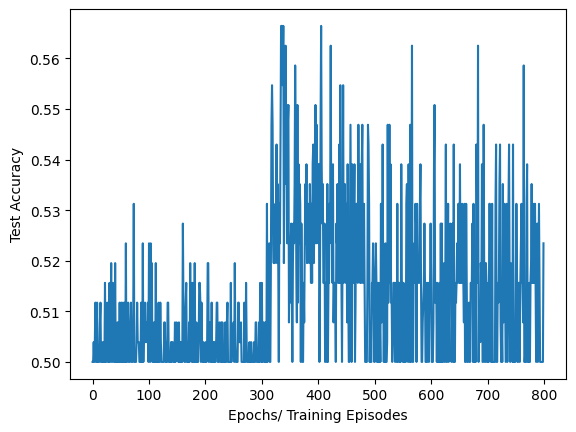

In [14]:
import matplotlib.pyplot as plt

plt.plot([i for i in range(len(ql.accuracy))], ql.accuracy)
plt.xlabel('Epochs/ Training Episodes')
plt.ylabel('Test Accuracy')
## next attempt: try putting the new token into target since it should be the future action thats being compared

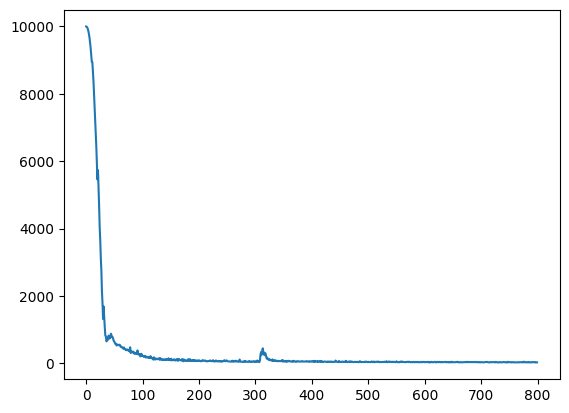

In [11]:
import matplotlib.pyplot as plt

plt.plot([i for i in range(len(ql.loss_))], ql.loss_)

## next attempt: try putting the new token into target since it should be the future action thats being compared

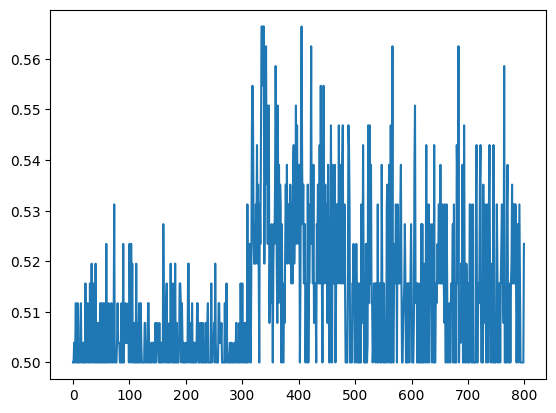

In [12]:
import matplotlib.pyplot as plt

plt.plot([i for i in range(len(ql.accuracy))], ql.accuracy)

## next attempt: try putting the new token into target since it should be the future action thats being compared

In [ ]:
ql.mlm.get_masked_word_class("good morning! ", "this is")

In [107]:
from transformers import GPT2Tokenizer
tokenizer = GPT2Tokenizer.from_pretrained('distilgpt2', truncation_side = 'right')

In [92]:
train_x

['hide new secretions from the parental units ',
 'contains no wit , only labored gags ',
 'remains utterly satisfied to remain the same throughout ',
 'on the worst revenge-of-the-nerds clichés the filmmakers could dredge up ',
 "that 's far too tragic to merit such superficial treatment ",
 "a depressed fifteen-year-old 's suicidal poetry ",
 'that loves its characters and communicates something rather beautiful about human nature ',
 'demonstrates that the director of such hollywood blockbusters as patriot games can still turn out a small , personal film with an emotional wallop . ',
 'of saucy ',
 "are more deeply thought through than in most ` right-thinking ' films ",
 'the greatest musicians ',
 'with his usual intelligence and subtlety ']

In [112]:
tokenizer.decode(tokenizer(' '.join(train_x[2].split(' ')[-3:]), return_tensors = 'pt', padding=True, max_length = 2)['input_ids'].flatten())

'same throughout'

In [171]:
x

{'input_ids': tensor([[24717,   649,  3200,   507,   422,   262, 21694,  4991,   220, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256],
        [ 3642,  1299,   645, 20868,   837,   691,  2248,  1850,   308,  3775,
           220, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256],
        [ 2787,  1299, 15950, 11378,   284,  3520,   262,   976,  3690,   220,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256],
        [  261,   262,  5290, 15827,    12,  1659,    12,  1169,    12,  1008,
          9310, 35478, 20954,   262, 28303,   714, 47478,   469,   510,   220,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 5

In [172]:
x['input_ids'].shape

torch.Size([12, 31])